In [1]:
%load_ext autoreload
%autoreload 2
import sys, os, glob, re, pickle, scipy, torch
from collections import defaultdict
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)
from openbabel import openbabel as ob
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

import matplotlib as mpl
from colorsys import rgb_to_hls

sys.path.append('/net/pulsar/home/koes/mtr22/param_search')
import param_search

os.chdir(os.environ['LIGAN_ROOT'])
import liGAN

base_dir = os.path.join(os.environ['LIGAN_ROOT'], 'new_atom_typing')
os.chdir(base_dir)

os.getcwd(), torch.cuda.is_available()

RDKit WARNING: [18:52:25] Enabling RDKit 2020.03.1dev1 jupyter extensions


('/net/pulsar/home/koes/mtr22/gan/new_atom_typing', True)

In [2]:
def find_work_dirs():
    '''
    Return mapping of job ids to works dirs
    based on stdout and stderr files.
    '''
    work_dir_pat = re.compile(r'^(.+)/(\d+)\.(stdout|stderr)$')
    work_dir_map = defaultdict(lambda: None)
    for f in glob.glob('*/*.std*'):
        m = work_dir_pat.match(f)
        if m:
            work_dir = m.group(1)
            job_id = int(m.group(2))
            if job_id in work_dir_map:
                assert work_dir_map[job_id] == work_dir
            else:
                work_dir_map[job_id] = work_dir
    return work_dir_map

def find_work_dir(x):
    '''
    If jobs are in queue, use the qstat value.
    Otherwise use the work_dir_map.
    '''
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    return work_dir_map[x['job_id']]

def find_job_state(x):
    '''
    If jobs are in the queue, use qstat value.
    Else if there's no work dir, assume the job
    was cancelled. If there's stderr, has error.
    '''
    if 'job_state' in x and not pd.isnull(x['job_state']):
        return x['job_state']
    if x['work_dir'] is None:
        return 'CAN'
    if x['stderr'] is not None:
        return 'ERR'
    return 'OK'

def catch_exc(func, exc_type=Exception, default=None):
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except exc_type as e:
            return default
    return wrapper

def as_timedelta(x):
    if pd.isnull(x):
        return np.nan
    x = x.split('-', 1)
    days = int(x[0]) if len(x) == 2 else 0
    x = x[-1].split(':', 2)
    hours = int(x[0])
    minutes = int(x[1])
    seconds = int(x[2]) if len(x) > 2 else 0
    return dt.timedelta(days=days, hours=hours, minutes=minutes, seconds=seconds)

def get_palette(n_hues, n_shades=1, n_repeat=1, hues=None, min_val=0.0, max_val=1.0, n_samples=100, mode=None):
    assert 0 <= min_val <= 1.0
    assert 0 <= max_val <= 1.0
    
    if hues is None:
        if n_hues <= 9:
            mode = mode or 'muted'
            hues = sns.color_palette(mode)[:n_hues]
        else:
            mode = mode or 'husl'
            hues = sns.color_palette(mode, n_hues)
            
    if not isinstance(n_shades, list):
        n_shades = [n_shades] * len(hues)

    colors = []
    for hue, n_shades in zip(hues, n_shades):
        
        # get n_samples different shades of hue
        shades = (
            sns.dark_palette(hue, n_colors=n_samples//2) + \
            sns.light_palette(hue, n_colors=n_samples//2, reverse=True)
        )
        # limit shade range with min_val and max_val
        min_idx = int(min_val * len(shades))
        max_idx = int(max_val * len(shades))
        shades = shades[min_idx:max_idx]
        
        # get n_shades evenly spaced shades in that range, avoiding endpoints
        vals = np.linspace(0, 1, n_shades + 2)
        idxs = [int(v * (len(shades) - 1)) for v in vals]
        shades = [shades[i] for i in idxs[1:-1]]
        
        # repeat each shade n_repeat times
        shades = sorted(n_repeat * shades, key=lambda x: sum(x))

        colors.extend(shades)
        
    return sns.color_palette(colors)

def get_gray_color(colors):
    light_vals = [rgb_to_hls(*c)[1] for c in colors]
    lum = min(light_vals) * .6
    return mpl.colors.rgb2hex((lum, lum, lum))

class TextHandler(mpl.legend_handler.HandlerBase):
    '''
    Allow text as the handle in a legend.
    '''
    def create_artists(
        self,
        legend,
        text,
        xdescent,
        ydescent,
        width,
        height,
        fontsize,
        trans,
    ):
        txt = mpl.text.Text(
            width/2,
            height/2,
            text,
            fontsize=fontsize,
            ha='center',
            va='center',
        )
        return [txt]

mpl.legend.Legend.update_default_handler_map({str: TextHandler()})

get_palette(n_hues=5, n_shades=[1,2,3,4,5], mode='bright')

[(0.00784313725490196, 0.24313725490196078, 1.0),
 (0.7303055126922927, 0.37401705098309446, 0.043187573664151865),
 (0.9844773267701052, 0.6343974503939503, 0.3054485381797389),
 (0.11765447059964117, 0.4644768631663434, 0.17588467018778384),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.5030029764381416, 0.8687267017335306, 0.563760629977106),
 (0.4706802763783887, 0.0814431506173033, 0.0983586076494307),
 (0.7634293731718812, 0.027147716872434446, 0.06154437248445076),
 (0.9176295076475914, 0.17345829730976864, 0.2086305836444825),
 (0.9349456981201926, 0.557280912633512, 0.574828587670488),
 (0.28221917951149533, 0.1502744739281356, 0.4109591598393532),
 (0.4182437057537802, 0.1597710725191288, 0.6569072188326472),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6752846353959335, 0.42043142881142276, 0.9073661857993561),
 (0.8070397447831716, 0.6752691895078875, 0.928711978373049)]

# Table of contents

1. [Atom type analysis](#1.-Atom-type-analysis)

2. [Bond adding experiment](#2.-Bond-adding-experiment)

3. [Atom fitting experiment](#3.-Atom-fitting-experiment)

4. [Training experiment](#4.-Training-experiment)

5. [Test evaluations](#5.-Test-evaluations)


# 1. Atom type analysis

Iterate through the Crossdock2020 dataset and display the distributions of atomic properties.

[Table of contents](#Table-of-contents)

In [800]:
os.chdir(base_dir)
data_file = '../data/it2_tt_0_lowrmsd_valid_mols.types'
data_root = os.environ['CROSSDOCK_ROOT']
src_pat = re.compile(r'(.+)_(\d+)')

with open(data_file) as f:
    lines = f.readlines()
n_lines = len(lines)

os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing'

In [209]:
from liGAN.atom_types import Atom

funcs = [
    Atom.atomic_num, 
    Atom.aromatic,
    Atom.h_acceptor,
    Atom.h_donor,
    Atom.h_count,
    Atom.formal_charge,
    Atom.hybridization,
]

def defaultdict_int(): # allow pickling
    return defaultdict(int)

if False:
    rec_counts = defaultdict(defaultdict_int)
    lig_counts = defaultdict(defaultdict_int)
    my_split_ext = lambda x: x.rsplit('.', 1 + x.endswith('.gz'))

    line_idx = 0
    with open(data_file) as f:
        lines = f.readlines()
    n_lines = len(lines)

In [792]:
while line_idx < n_lines:
    line = lines[line_idx]
    rec_src, lig_src = line.rstrip().split(' ')[3:5]

    rec_mol_file = os.path.join(data_root, rec_src)
    rec_mol = liGAN.molecules.read_ob_mols_from_file(rec_mol_file, '.pdb')[0]

    lig_mol_file = os.path.join(data_root, lig_src)
    lig_mol = liGAN.molecules.read_ob_mols_from_file(lig_mol_file, '.sdf')[0]

    for atom in ob.OBMolAtomIter(rec_mol):
        for func in funcs:
            rec_counts[func.__name__][func(atom)] += 1

    for atom in ob.OBMolAtomIter(lig_mol):
        for func in funcs:
            lig_counts[func.__name__][func(atom)] += 1

    line_idx += 1
    if line_idx % 100 == 0: 
        pct_done = line_idx/n_lines * 100
        print('[{:.2f}%]'.format(pct_done), end=' ')
        
        with open('rec_counts.pkl', 'wb') as f:
            pickle.dump(rec_counts, f)
        with open('lig_counts.pkl', 'wb') as f:
            pickle.dump(lig_counts, f)

[41.92%] [41.97%] [41.98%] [42.00%] [42.01%] [42.03%] [42.04%] [42.06%] [42.07%] [42.09%] [42.10%] [42.12%] [42.13%] [42.15%] [42.16%] [42.18%] [42.19%] [42.21%] [42.22%] [42.24%] [42.25%] [42.27%] [42.28%] [42.30%] [42.31%] [42.33%] [42.34%] [42.36%] [42.37%] [42.39%] [42.41%] [42.42%] [42.44%] [42.45%] [42.47%] [42.48%] [42.50%] [42.51%] [42.53%] [42.54%] [42.56%] [42.57%] [42.59%] [42.60%] [42.62%] [42.63%] [42.65%] [42.66%] [42.68%] [42.69%] [42.71%] [42.72%] [42.74%] [42.75%] [42.77%] [42.78%] [42.80%] [42.81%] [42.83%] [42.84%] [42.86%] [42.87%] [42.89%] [42.90%] [42.92%] [42.93%] [42.95%] [42.96%] [42.98%] [42.99%] [43.01%] [43.02%] [43.04%] [43.05%] [43.07%] [43.08%] [43.10%] [43.11%] [43.13%] [43.15%] [43.16%] [43.18%] [43.19%] [43.21%] [43.22%] [43.24%] [43.25%] [43.27%] [43.28%] [43.30%] [43.31%] [43.33%] [43.34%] [43.36%] [43.37%] [43.39%] [43.40%] [43.42%] [43.43%] [43.45%] [43.46%] [43.48%] [43.49%] [43.51%] [43.52%] [43.54%] [43.55%] [43.57%] [43.58%] [43.60%] [43.61%] [

[55.71%] [55.72%] [55.74%] [55.75%] [55.77%] [55.79%] [55.80%] [55.82%] [55.83%] [55.85%] [55.86%] [55.88%] [55.89%] [55.91%] [55.92%] [55.94%] [55.95%] [55.97%] [55.98%] [56.00%] [56.01%] [56.03%] [56.04%] [56.06%] [56.07%] [56.09%] [56.10%] [56.12%] [56.13%] [56.15%] [56.16%] [56.18%] [56.19%] [56.21%] [56.22%] [56.24%] [56.25%] [56.27%] [56.28%] [56.30%] [56.31%] [56.33%] [56.34%] [56.36%] [56.37%] [56.39%] [56.40%] [56.42%] [56.43%] [56.45%] [56.46%] [56.48%] [56.49%] [56.51%] [56.53%] [56.54%] [56.56%] [56.57%] [56.59%] [56.60%] [56.62%] [56.63%] [56.65%] [56.66%] [56.68%] [56.69%] [56.71%] [56.72%] [56.74%] [56.75%] [56.77%] [56.78%] [56.80%] [56.81%] [56.83%] [56.84%] [56.86%] [56.87%] [56.89%] [56.90%] [56.92%] [56.93%] [56.95%] [56.96%] [56.98%] [56.99%] [57.01%] [57.02%] [57.04%] [57.05%] [57.07%] [57.08%] [57.10%] [57.11%] [57.13%] [57.14%] [57.16%] [57.17%] [57.19%] [57.20%] [57.22%] [57.23%] [57.25%] [57.27%] [57.28%] [57.30%] [57.31%] [57.33%] [57.34%] [57.36%] [57.37%] [

[69.47%] [69.48%] [69.50%] [69.51%] [69.53%] [69.54%] [69.56%] [69.57%] [69.59%] [69.60%] [69.62%] [69.63%] [69.65%] [69.66%] [69.68%] [69.69%] [69.71%] [69.72%] [69.74%] [69.75%] [69.77%] [69.78%] [69.80%] [69.81%] [69.83%] [69.84%] [69.86%] [69.87%] [69.89%] [69.91%] [69.92%] [69.94%] [69.95%] [69.97%] [69.98%] [70.00%] [70.01%] [70.03%] [70.04%] [70.06%] [70.07%] [70.09%] [70.10%] [70.12%] [70.13%] [70.15%] [70.16%] [70.18%] [70.19%] [70.21%] [70.22%] [70.24%] [70.25%] [70.27%] [70.28%] [70.30%] [70.31%] [70.33%] [70.34%] [70.36%] [70.37%] [70.39%] [70.40%] [70.42%] [70.43%] [70.45%] [70.46%] [70.48%] [70.49%] [70.51%] [70.52%] [70.54%] [70.55%] [70.57%] [70.58%] [70.60%] [70.61%] [70.63%] [70.65%] [70.66%] [70.68%] [70.69%] [70.71%] [70.72%] [70.74%] [70.75%] [70.77%] [70.78%] [70.80%] [70.81%] [70.83%] [70.84%] [70.86%] [70.87%] [70.89%] [70.90%] [70.92%] [70.93%] [70.95%] [70.96%] [70.98%] [70.99%] [71.01%] [71.02%] [71.04%] [71.05%] [71.07%] [71.08%] [71.10%] [71.11%] [71.13%] [

[83.22%] [83.24%] [83.25%] [83.27%] [83.29%] [83.30%] [83.32%] [83.33%] [83.35%] [83.36%] [83.38%] [83.39%] [83.41%] [83.42%] [83.44%] [83.45%] [83.47%] [83.48%] [83.50%] [83.51%] [83.53%] [83.54%] [83.56%] [83.57%] [83.59%] [83.60%] [83.62%] [83.63%] [83.65%] [83.66%] [83.68%] [83.69%] [83.71%] [83.72%] [83.74%] [83.75%] [83.77%] [83.78%] [83.80%] [83.81%] [83.83%] [83.84%] [83.86%] [83.87%] [83.89%] [83.90%] [83.92%] [83.93%] [83.95%] [83.96%] [83.98%] [83.99%] [84.01%] [84.03%] [84.04%] [84.06%] [84.07%] [84.09%] [84.10%] [84.12%] [84.13%] [84.15%] [84.16%] [84.18%] [84.19%] [84.21%] [84.22%] [84.24%] [84.25%] [84.27%] [84.28%] [84.30%] [84.31%] [84.33%] [84.34%] [84.36%] [84.37%] [84.39%] [84.40%] [84.42%] [84.43%] [84.45%] [84.46%] [84.48%] [84.49%] [84.51%] [84.52%] [84.54%] [84.55%] [84.57%] [84.58%] [84.60%] [84.61%] [84.63%] [84.64%] [84.66%] [84.67%] [84.69%] [84.70%] [84.72%] [84.73%] [84.75%] [84.77%] [84.78%] [84.80%] [84.81%] [84.83%] [84.84%] [84.86%] [84.87%] [84.89%] [

KeyboardInterrupt: 

In [793]:
line_idx, n_lines, pct_done

(585724, 662183, 88.44986959798122)

In [801]:
colors = get_palette(
    n_hues=2,
    n_shades=1,
    #min_val=0.1,
    #max_val=0.9,
)
sns.set_palette(colors)
colors

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726)]

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:46: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index


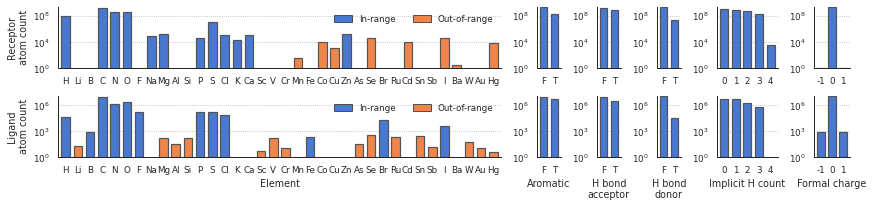

In [815]:
with open('rec_counts.pkl', 'rb') as f:
    rec_counts = pickle.load(f)
with open('lig_counts.pkl', 'rb') as f:
    lig_counts = pickle.load(f)


func_name_map = dict(
    atomic_num='Element',
    aromatic='Aromatic',
    h_acceptor='H bond\nacceptor',
    h_donor='H bond\ndonor',
    h_count='Implicit H count',
    formal_charge='Formal charge',
    hybridization='Hybridization',
)

def plot_counts(counts, ax, width=0.7, is_rec_counts=False, is_elem_counts=False):
    
    # get labels and counts as arrays
    labels = np.array(list(counts.keys()))
    counts = np.array(list(counts.values()))
        
    # sort arrays by count, in decreasing order
    idx = np.argsort(labels)
    labels = labels[idx]
    counts = counts[idx]
    
    if is_elem_counts:
        
        if is_rec_counts:
            elem_range = liGAN.atom_types.AtomTyper.rec_elem_range
        else:
            elem_range = liGAN.atom_types.AtomTyper.lig_elem_range
            
        # color bars by whether they are in-range or not
        color = [colors[l not in elem_range and l != 1] for l in labels]
        
        # replace atomic number with symbol
        labels = np.array([ob.GetSymbol(int(l)) for l in labels])
    else:
        color = [colors[0] for l in labels]
        
    # abbreviate boolean values
    boolean = False
    if set(labels) == {False, True}:
        labels = ['FT'[l] for l in labels]
        boolean = True

    n_values = len(counts)
    x = np.arange(n_values)
    ax.bar(x, counts, width=width, color=color)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    lw = mpl.rcParams["lines.linewidth"]
    gray = get_gray_color(colors)
    plt.setp(ax.patches, linewidth=lw, edgecolor=gray)
    
    x_min = x.min() - 0.5*width - (1-width)
    x_max = x.max() + 0.5*width + (1-width)
    ax.set_xlim(x_min, x_max)
    
    if is_elem_counts:
        handles = [mpl.patches.Patch(facecolor=c, edgecolor='0.2') for c in colors[:2]]
        labels = ['In-range', 'Out-of-range']
        return ax.legend(handles, labels, frameon=False, ncol=2)
        for tick in ax.xaxis.get_major_ticks():
            tick.label.set_fontsize('xx-small')
           
        
# make the rec and lig histograms have the same value ranges
#   and get the max counts in order to set the ylim
n_func_values = []
max_rec_count = 0
max_lig_count = 0
for f in list(rec_counts.keys())[:-1]:
    values = set(rec_counts[f].keys()) | set(lig_counts[f].keys())
    n_func_values.append(len(values))
    for v in values:
        if rec_counts[f][v] > max_rec_count:
            max_rec_count = rec_counts[f][v]
        if lig_counts[f][v] > max_lig_count:
            max_lig_count = lig_counts[f][v]

fig, axes = plt.subplots(
    2, len(funcs)-1,
    figsize=(12, 3),
    gridspec_kw=dict(width_ratios=n_func_values)
)

for i, counts in enumerate([rec_counts, lig_counts]):
    for j, func in list(enumerate(funcs))[:-1]:
        ax = axes[i][j]
        plot_counts(counts[func.__name__], ax, is_rec_counts=(i==0), is_elem_counts=(j==0))
        if i == 0:
            if j == 0:
                ax.set_ylabel('Receptor\natom count')
            ax.set_ylim([1e0, max_rec_count])
        else:
            if j == 0:
                ax.set_ylabel('Ligand\natom count')
            ax.set_ylim([1e0, max_lig_count])
            ax.set_xlabel(func_name_map[func.__name__])
        ax.set_yscale('log')
        ax.grid(axis='y', linestyle=':', color='#b0b0b0')

sns.despine(fig)
fig.tight_layout()
for ext in ['png', 'pdf']:
    fig.savefig(f'plots/atom_properties.{ext}', bbox_inches='tight', dpi=400)

In [24]:
for atomic_num in sorted(rec_counts[funcs[0].__name__].keys()):
    symbol = ob.GetSymbol(atomic_num)
    cov_radius = ob.GetCovalentRad(atomic_num)
    vdw_radius = ob.GetVdwRad(atomic_num)
    print('{}\t{}\t{}\t{}'.format(atomic_num, symbol, cov_radius, vdw_radius))

1	H	0.31	1.1
6	C	0.76	1.7
7	N	0.71	1.55
8	O	0.66	1.52
11	Na	1.66	2.27
12	Mg	1.41	1.73
15	P	1.07	1.8
16	S	1.05	1.8
17	Cl	1.02	1.75
19	K	2.03	2.75
20	Ca	1.76	2.31
30	Zn	1.22	2.1
48	Cd	1.44	2.2
53	I	1.39	1.98


# 2. Bond adding experiment

Test the ability to reconstruct molecules from atom types and coordinates by bond adding, using different atom typing schemes.

[Table of contents](#Table-of-contents)

In [212]:
os.chdir(os.path.join(base_dir, 'bond_adding'))
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/bond_adding'

In [ ]:
add_params = param_search.ParamSpace(
    data_root='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples=100000,
    typer_fns=['oad', 'oadc', 'on', 'onc', 'oh'],
    use_ob_mol=[0, 1],
    remove_h=[0, 1],
)
len(add_params)

In [ ]:
name_format = 'add_{typer_fns}_{use_ob_mol}_{remove_h}'
template_file = 'add.sh'

add_job_files = param_search.setup(
    expt_dir=add_expt_dir,
    name_format=name_format,
    template_file=template_file,
    param_space=add_params,
)
add_job_files

In [ ]:
job_ids = param_search.submit(add_job_files)
print(job_ids)

In [50]:
add_jobs = pd.DataFrame(dict(
    job_id=[
        #[6813229, 6813230, 6813231, 6813232, 6813233, 6813234, 6813235, 6813236],
        #[6813240, 6813241, 6813242, 6813243, 6813244, 6813245, 6813246, 6813247],
        #[6813291, 6813292, 6813293, 6813294, 6813295, 6813296, 6813297, 6813298],
        #[6814300, 6814301, 6814302, 6814303, 6814304, 6814305, 6814306, 6814307],
        #[6814308, 6814309, 6814310, 6814311, 6814312, 6814313, 6814314, 6814315],
        #[6814316, 6814317, 6814318, 6814319, 6814320, 6814321, 6814322, 6814323],
        #[6814326, 6814327, 6814328, 6814329, 6814330, 6814331, 6814332, 6814333],
        #[6814344, 6814345, 6814346, 6814347, 6814348, 6814349, 6814350, 6814351],
        #[6814416, 6814417, 6814418, 6814419, 6814420, 6814421, 6814422, 6814423],
        #[6815396, 6815397, 6815398, 6815399, 6815400, 6815401, 6815402, 6815403, 6815404, 6815405, 6815406, 6815407, 6815408, 6815409, 6815410, 6815411, 6815412, 6815413, 6815414, 6815415],
        #[6815426, 6815427, 6815428, 6815429, 6815430, 6815431, 6815432, 6815433, 6815434, 6815435, 6815436, 6815437, 6815438, 6815439, 6815440, 6815441, 6815442, 6815443, 6815444, 6815445],
        #[6815523, 6815524, 6815525, 6815526, 6815527, 6815528, 6815529, 6815530, 6815531, 6815532, 6815533, 6815534, 6815535, 6815536, 6815537, 6815538, 6815539, 6815540, 6815541, 6815542],
        #[6815543, 6815544, 6815545, 6815546, 6815547, 6815548, 6815549, 6815550, 6815551, 6815552, 6815553, 6815554, 6815555, 6815556, 6815557, 6815558, 6815559, 6815560, 6815561, 6815562],
        #[6815565, 6815566, 6815567, 6815568, 6815569, 6815570, 6815571, 6815572, 6815573, 6815574, 6815575, 6815576, 6815577, 6815578, 6815579, 6815580, 6815581, 6815582, 6815583, 6815584],
        #[6815588, 6815589, 6815590, 6815591, 6815592, 6815593, 6815594, 6815595, 6815596, 6815597, 6815598, 6815599, 6815600, 6815601, 6815602, 6815603, 6815604, 6815605, 6815606, 6815607],
        [6816993, 6816994, 6816995, 6816996, 6816997, 6816998, 6816999, 6817000, 6817001, 6817002, 6817003, 6817004, 6817005, 6817006, 6817007, 6817008, 6817009, 6817010, 6817011, 6817012],
        #
    ]
)).explode('job_id')

In [51]:
qstat = param_search.status(job=add_jobs['job_id'])
#qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
#qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

work_dir_map = find_work_dirs()
add_jobs['work_dir'] = add_jobs.apply(find_work_dir, axis=1)
add_jobs['job_name'] = add_jobs['work_dir'].map(catch_exc(os.path.basename, TypeError))
add_jobs['job_file'] = add_jobs.apply(lambda x: '{work_dir}/add.sh'.format(**x), axis=1)
add_jobs['stdout_file'] = add_jobs.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
add_jobs['stderr_file'] = add_jobs.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)

In [52]:
%%time

print('Reading stdout files')
add_jobs['stdout'] = add_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError)
)
print()

print('Reading stderr files')
add_jobs['stderr'] = add_jobs['stderr_file'].apply(
    catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError),
    break_pat='^==============================',
    error_pat=r'^(.*(Error|Exception|error|fault|failed|Errno|Killed).*)$'
)
print()

add_jobs['job_state'] = add_jobs.apply(find_job_state, axis=1)

# make the order that job_names appear explicit so we can use it
#   to easily view different job_ids associated with each job_name
job_name_idx = {j:i for i, j in enumerate(add_jobs['job_name'].unique())}
add_jobs['job_name_idx'] = add_jobs['job_name'].map(job_name_idx)
add_jobs.set_index(['job_id', 'job_name'])[['job_state', 'stdout', 'stderr']]

Reading stdout files
....................
Reading stderr files
....................
CPU times: user 22.1 ms, sys: 3.85 ms, total: 25.9 ms
Wall time: 33.4 ms


,,job_state,stdout,stderr
job_id,job_name,,,
6816993,add_oad_0_0,OK,None,None
6816994,add_oad_0_1,OK,None,None
6816995,add_oad_1_0,OK,None,None
6816996,add_oad_1_1,OK,None,None
6816997,add_oadc_0_0,OK,None,None
6816998,add_oadc_0_1,OK,None,None
6816999,add_oadc_1_0,OK,None,None
6817000,add_oadc_1_1,OK,None,None
6817001,add_on_0_0,OK,None,None


In [53]:
add_metrics = param_search.metrics(add_jobs['job_file'].unique(), metric_pat='(.*)metrics')
add_metrics.groupby(['job_name'])[['example_idx']].count()

,example_idx
job_name,
add_oad_0_0,100000
add_oad_0_1,100000
add_oad_1_0,100000
add_oad_1_1,100000
add_oadc_0_0,100000
add_oadc_0_1,100000
add_oadc_1_0,100000
add_oadc_1_1,100000
add_oh_0_0,90903


In [54]:
# why are some REAL molecules invalid?
#   NOTE that oh did not fully complete, so the set of molecules is different
#   i.e. it is just a data artifact that it appears to have fewer invalid
plot_df = add_metrics.reset_index()
plot_df.groupby(
    ['typer_fns', 'remove_h', 'use_ob_mol', 'lig_reason']
)[['lig_name']].count().unstack() / 100000 * 100

lig_name               
lig_reason                    invalid valence valid molecule
typer_fns remove_h use_ob_mol                               
oad       0        0                    8.556         91.444
                   1                    8.556         91.444
          1        0                    8.556         91.444
                   1                    8.556         91.444
oadc      0        0                    8.556         91.444
                   1                    8.556         91.444
          1        0                    8.556         91.444
                   1                    8.556         91.444
oh        0        0                    7.786         83.117
                   1                    7.991         85.307
          1        0                    7.683         81.972
                   1                    7.991         85.307
on        0        0                    8.556         91.444
                   1                    8.556         91.444
          1        0                    8.556         91.444
                   1                    8.556         91.444
onc       0        0                    8.556         91.444
                   1                    8.556         91.444
          1        0                    8.556         91.444
                   1                    8.556         91.444

In [325]:
colors = get_palette(
    n_hues=5,
    n_shades=1,
    min_val=0.1,
    max_val=0.9,
)
sns.set_palette(colors)
colors

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765)]

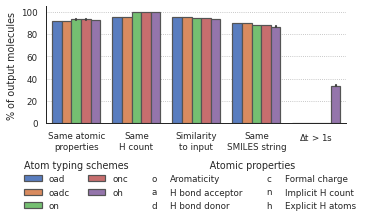

In [326]:
sns.set_context('paper')

def my_add_plot(y, *args, **kwargs):
    lw = mpl.rcParams["lines.linewidth"]
    gray = get_gray_color(colors)
    ax = sns.barplot(y=y, *args, **kwargs)
    plt.setp(ax.patches, linewidth=lw, edgecolor=gray)
    return ax

typer_fn_map = dict(
    oad ='H acceptor/donor',
    oadc='H acceptor/donor + formal charge',
    on  ='H count',
    onc ='H count + formal charge',
    oh  ='explicit H atoms',
)

plot_df = add_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid REAL molecules
plot_df['Same elements'] = (plot_df['elem_count_diff'] == 0)*100
plot_df['Same atomic\nproperties'] = (plot_df['prop_count_diff'] == 0)*100
plot_df['Same\nH count'] = (plot_df['n_atoms_diff'] == 0)*100
plot_df['Same\nSMILES string'] = plot_df['smi_match'].where(plot_df['lig_add_valid'])*100
plot_df['Similarity\nto input'] = (plot_df['ob_sim'])*100
plot_df['$\Delta$t > 1s'] = (plot_df['add_time'] > 1)*100

y = [
    'Same atomic\nproperties',
    'Same\nH count',
    'Similarity\nto input',
    'Same\nSMILES string',
    '$\Delta$t > 1s'
]
ylim = {k:[0, 100] for k in y}
hue = 'typer_fns'

fig = param_search.plot(
    plot_df[
        (plot_df['use_ob_mol'] == 0) &
        (plot_df['remove_h'] == 0)
    ].set_index(hue)[y].stack().reset_index(),
    x='level_1',
    y=0,
    hue=hue,
    n_cols=1,
    width=5,
    height=2.5,
    plot_func=my_add_plot,
    ylim=ylim,
    legend=False,
    tight=True,
)

ax = fig.axes[0]
ax.set_ylabel('% of output molecules')
ax.set_xlabel(None)
ax.grid(axis='y', linestyle=':', color='#b0b0b0')

#txt = fig.suptitle(f'Atom Typing and Bond Adding', y=1.05)

handles, labels = ax.get_legend_handles_labels()
handles = handles + [' ']
labels = labels + [' ']
handles = handles + ['o', 'a', 'd', 'c', 'n', 'h']
labels = labels + \
    ['Aromaticity', 'H bond acceptor', 'H bond donor', 'Formal charge', 'Implicit H count', 'Explicit H atoms']
lgd = ax.legend(
    handles, labels,
    loc='upper left',
    ncol=4,
    bbox_to_anchor=[-0.1,-0.25],
    title='Atom typing schemes' + 27*' ' + 'Atomic properties',
    frameon=False
)
lgd._legend_box.align = 'left'
for ext in ['pdf', 'png']:
    fig.savefig(f'plots/bond_adding.{ext}', bbox_inches='tight', bbox_extra_artists=(lgd,), dpi=400)

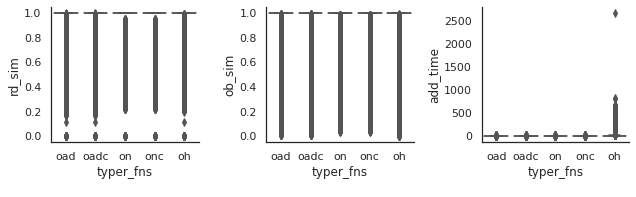

In [113]:
fig = param_search.plot(
    plot_df[
        (plot_df['use_ob_mol'] == 0) &
        (plot_df['remove_h'] == 0)
    ],
    x='typer_fns',
    y=['rd_sim', 'ob_sim', 'add_time'],
    n_cols=3,
    hue=None,
    plot_func=sns.boxplot,
)

In [ ]:
plot_df.groupby(['typer_fns'])[
    ['exact_elems', 'exact_props', 'exact_n_atoms', 'smi_match', 'lig_valid', 'lig_add_valid', 'valid_smi_match', 'rd_sim', 'ob_sim', 'add_time']
].mean() * 100

In [ ]:
reasons = plot_df['lig_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_reason'] == r)

plot_df.groupby(['typer_fns'])[reasons].mean() * 100

In [ ]:
reasons = plot_df['lig_add_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_add_reason'] == r)

plot_df.groupby(['typer_fns'])[reasons].mean() * 100

In [ ]:
plot_df = add_metrics.reset_index()
plot_df = plot_df[plot_df['lig_valid']] # filter invalid
plot_df['exact_elems'] = (plot_df['elem_count_diff'] == 0)
plot_df['exact_props'] = (plot_df['prop_count_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['n_atoms_diff'] == 0)
plot_df['valid_smi_match'] = plot_df['smi_match'].where(plot_df['lig_valid'] & plot_df['lig_add_valid'])

plot_df[
    (plot_df['use_ob_mol'] == 0) &
    (plot_df['remove_h'] == 0) & 
    (plot_df['typer_fns'] == 'on') &
    (plot_df['exact_elems'] == 1) &
    (plot_df['exact_props'] == 1) &
    (plot_df['exact_n_atoms'] == 1) &
    (plot_df['smi_match'] == 0)
]

# 3. Atom fitting experiment

Test the ability to reconstruct molecules from atoms that were fit to atomic density grids, through atom fitting + bond adding, using the different typing schemes.

[Table of contents](#Table-of-contents)

In [347]:
fit_expt_dir = os.path.join(base_dir, 'atom_fitting')
os.chdir(fit_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting'

In [174]:
fit_params = param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples= 10000,
    typer_fns = ['oad', 'oadc', 'on', 'oh'],
    radius_fn = [0.5, 1.0, 1.5],
    apply_prop_conv = [0],
)

fit_params = param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples= 10000,
    typer_fns = ['oad', 'oadc', 'on', 'onc', 'oh'],
    radius_fn = ['c', 'v'],
    apply_prop_conv = [0],
) + param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples= 10000,
    typer_fns = ['onc'],
    radius_fn = [0.5, 1.0, 1.5],
    apply_prop_conv = [0],
)

fit_params = param_search.ParamSpace(
    data_root ='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    data_file ='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_mols_rand.types',
    n_examples= 1000,
    typer_fns = ['oad', 'oadc', 'on', 'onc', 'oh'],
    radius_fn = [0.5, 1.0, 1.5, 'c', 'v'],
    apply_prop_conv = [0],
    group_name=1
)
len(fit_params)

25

In [249]:
name_format = 'fit{group_name}_{typer_fns}-{radius_fn}_{apply_prop_conv}'

for template_file in ['generate.config', 'generate.sh']:
    fit_job_files = param_search.setup(
        expt_dir=fit_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=fit_params,
    )

fit_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit1_oad-0.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit1_oad-1.0_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit1_oad-1.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit1_oad-c_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit1_oad-v_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit1_oadc-0.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit1_oadc-1.0_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit1_oadc-1.5_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit1_oadc-c_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit1_oadc-v_0/generate.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/atom_fitting/fit1_on-0.5_0/genera

In [250]:
job_ids = param_search.submit(fit_job_files)
print(job_ids)

[7080892, 7080893, 7080894, 7080895, 7080896, 7080897, 7080898, 7080899, 7080900, 7080901, 7080902, 7080903, 7080904, 7080905, 7080906, 7080907, 7080908, 7080909, 7080910, 7080911, 7080912, 7080913, 7080914, 7080915, 7080916]


In [348]:
fit_jobs = pd.DataFrame(dict(
    job_id=[
        #[6814426, 6814427, 6814428, 6814429, 6814430, 6814431, 6814432, 6814433, 6814434, 6814435, 6814436, 6814437, 6814438, 6814439, 6814440, 6814441],
        #[6814442, 6814443, 6814444, 6814445, 6814446, 6814447, 6814448, 6814449, 6814450, 6814451, 6814452, 6814453, 6814454, 6814455, 6814456, 6814457],
        # fix atom radius, don't shuffle data order
        #[6817013, 6817014, 6817015, 6817016, 6817017, 6817018, 6817019, 6817020, 6817021, 6817022, 6817023, 6817024],
        # rerun covalent radius, vdw radius, and ohc without shuffling
        #[7063727, 7063728, 7063729, 7063730, 7063731, 7063732, 7063733, 7063734, 7063735, 7063736, 7063737, 7063738, 7063739],
        # group 1, resubmit all with 1000 shuffled examples
        [7080892, 7080893, 7080894, 7080895, 7080896, 7080897, 7080898, 7080899, 7080900, 7080901, 7080902, 7080903, 7080904, 7080905, 7080906, 7080907, 7080908, 7080909, 7080910, 7080911, 7080912, 7080913, 7080914, 7080915, 7080916],
    ]
)).explode('job_id')
#df.index.rename('submit_id', inplace=True)
#df.groupby('submit_id').count()

In [349]:
qstat = param_search.status(job=fit_jobs['job_id'])

fit_jobs = fit_jobs.merge(qstat, on='job_id', how='left')

work_dir_map = find_work_dirs()
fit_jobs['work_dir'] = fit_jobs.apply(find_work_dir, axis=1)
fit_jobs['job_name'] = fit_jobs['work_dir'].map(catch_exc(os.path.basename, TypeError))
fit_jobs['job_file'] = fit_jobs.apply(lambda x: '{work_dir}/generate.sh'.format(**x), axis=1)
fit_jobs['stdout_file'] = fit_jobs.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
fit_jobs['stderr_file'] = fit_jobs.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)

job_name_idx = {j:i for i, j in enumerate(fit_jobs['job_name'].unique())}
fit_jobs['job_name_idx'] = fit_jobs['job_name'].map(job_name_idx)

In [350]:
import datetime as dt
has = lambda x: not pd.isnull(x)

print('Reading stdout files')
fit_jobs['stdout'] = fit_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError)
)
print()

print('Reading stderr files')
fit_jobs['stderr'] = fit_jobs['stderr_file'].apply(
    catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError),
    break_pat='^==============================',
    error_pat=r'^(.*(Error|Exception|error|fault|failed|Errno|Killed).*)$'
)
print()

fit_jobs['job_state'] = fit_jobs.apply(find_job_state, axis=1)

fit_jobs['example_idx'] = fit_jobs['stdout'].map(
    lambda x: int(re.match(r'^\[example_idx=(\d+) ', x).group(1)) if has(x) else x
)
fit_jobs['sample_idx'] = fit_jobs['stdout'].map(
    lambda x: int(re.match(r'^\[example_idx=\d+ sample_idx=(\d+) ', x).group(1)) if has(x) else np.nan
)
fit_jobs['samples_done'] = fit_jobs['example_idx']*10 + fit_jobs['sample_idx']
fit_jobs['pct_done'] = fit_jobs['samples_done']/(100000)

fit_jobs['t_left'] = fit_jobs['runtime'].map(as_timedelta) / fit_jobs['pct_done'] * (1-fit_jobs['pct_done'])
#fit_jobs['t_left'] = fit_jobs['t_left'].map(lambda x: (x.total_seconds() / 3600 if has(x) else x))
fit_jobs['pct_done'] *= 100

running_jobs = (fit_jobs.groupby('job_name')['job_state'].last() == 'R')
running_jobs = running_jobs[running_jobs] # drop non-running jobs

fit_jobs[
    fit_jobs['job_name'].isin(running_jobs.index) &
    True
].set_index(['job_name', 'job_id']).sort_values(['job_name_idx','job_id'])[
    ['queue', 'job_state', 'runtime', 'samples_done', 'pct_done', 't_left', 'stdout', 'stderr']
]

Reading stdout files
.........................
Reading stderr files
.........................


,,queue,job_state,runtime,samples_done,pct_done,t_left,stdout,stderr
job_name,job_id,,,,,,,,


In [351]:
fit_metrics = param_search.metrics(
    fit_jobs[~fit_jobs['work_dir'].isnull()]['job_file'].unique(),
    metric_pat='(.*)metrics'
)
fit_metrics.groupby(['typer_fns', 'radius_fn'])[['sample_idx']].count()

fit1_on-0.5_0/generate.sh No objects to concatenate
fit1_oh-1.0_0/generate.sh No objects to concatenate
fit1_oh-1.5_0/generate.sh No objects to concatenate
fit1_oh-c_0/generate.sh No objects to concatenate
fit1_oh-v_0/generate.sh No objects to concatenate


sample_idx
typer_fns radius_fn            
oad       0.5             10000
          1.0             10000
          1.5             10000
          c               10000
          v               10000
oadc      0.5             10000
          1.0             10000
          1.5             10000
          c               10000
          v               10000
oh        0.5             10000
on        1.0             10000
          1.5             10000
          c               10000
          v               10000
onc       0.5             10000
          1.0             10000
          1.5             10000
          c               10000
          v               10000

In [352]:
colors = get_palette(n_hues=5)
sns.set_palette(colors)
colors

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.41568627450980394, 0.8, 0.39215686274509803),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.5843137254901961, 0.4235294117647059, 0.7058823529411765)]

In [353]:
fit_metrics[['lig_valid', 'sample_idx']].fillna('nan').groupby('lig_valid').count()

,sample_idx
lig_valid,
False,17800
True,182200


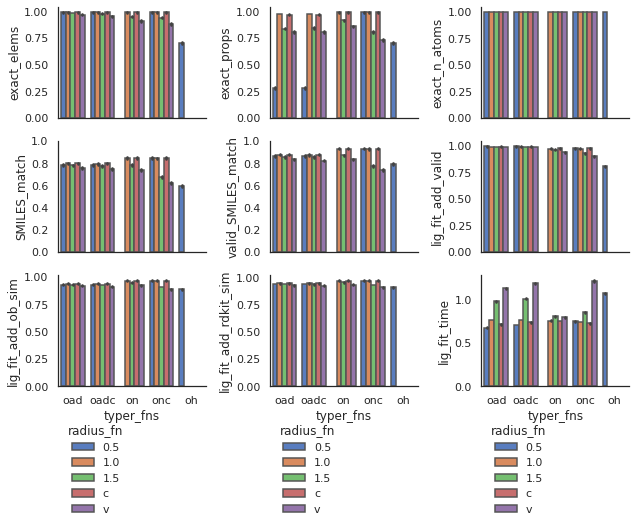

In [354]:
def my_fit_plot(y, *args, **kwargs):
    lw = mpl.rcParams["lines.linewidth"]
    gray = get_gray_color(colors)
    ax = sns.barplot(y=y, *args, **kwargs)
    plt.setp(ax.patches, linewidth=lw, edgecolor=gray)
    return ax

plot_df = fit_metrics.reset_index()
plot_df = plot_df[~plot_df['lig_valid'].fillna(False).isnull()] # filter invalid mols
plot_df['exact_elems'] = (plot_df['lig_fit_elem_diff'] == 0)
plot_df['exact_props'] = (plot_df['lig_fit_prop_diff'] == 0)
plot_df['exact_n_atoms'] = (plot_df['lig_fit_add_n_atoms_diff'] == 0)
plot_df['SMILES_match'] = plot_df['lig_fit_add_SMILES_match']
plot_df['valid_SMILES_match'] = plot_df['lig_fit_add_SMILES_match'].where(plot_df['lig_valid'] & plot_df['lig_fit_add_valid'])

fig = param_search.plot(
    plot_df, #[plot_df['radius_fn'] == 'c'],
    x='typer_fns',
    y=[
        'exact_elems',
        'exact_props',
        'exact_n_atoms',
        
        'SMILES_match',
        'valid_SMILES_match',
        'lig_fit_add_valid',
        
        'lig_fit_add_ob_sim',
        'lig_fit_add_rdkit_sim',
        'lig_fit_time',
    ],
    hue='radius_fn',
    n_cols=3,
    width=3,
    height=2.5,
    plot_func=my_fit_plot,
    ylim=dict(SMILES_match=[0,1], valid_SMILES_match=[0,1])
)
lgd = fig.axes[-1].get_legend()
for ext in ['png', 'pdf']:
    fig.savefig(f'plots/atom_fitting.{ext}', bbox_inches='tight', bbox_extra_artists=(lgd,), dpi=400)

In [ ]:
plot_df = fit_metrics.reset_index()
reasons = plot_df['lig_fit_add_reason'].unique()
for r in reasons:
    plot_df[r] = (plot_df['lig_fit_add_reason'] == r)

plot_df.groupby(['typer_fns', 'radius_fn'])[reasons].mean() * 100

In [ ]:
plot_df = fit_metrics[
    fit_metrics['job_name'] == 'fit_on-1.0_0'
]
ax = plot_df.hist('lig_radius', bins=25)[0,0]
ax.set_xlim(0, 23.5)

In [ ]:
plot_df = fit_metrics[
    fit_metrics['job_name'] == 'fit_on-1.0_0'
]
y = 'lig_fit_n_atoms_diff'
ax = plot_df.plot(x='lig_radius', y=y, kind='scatter', alpha=0.01, s=10)
ylim = ax.get_ylim()
ax.vlines(23.5/2, *ax.get_ylim(), 'k', linestyle='--')
ax.vlines(23.5/2*(3**0.5), *ax.get_ylim(), 'k', linestyle='--')
ax.set_ylim(ylim)
ax.set_xlim(0, 23.5)
plot_df[['lig_radius', y]].corr()

# 4. Training experiment

Train generative models to produce atomic density grids and periodically test atom fitting performance.

[Table of contents](#Table-of-contents)

In [490]:
train_expt_dir = os.path.join(base_dir, 'training')
os.chdir(train_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training'

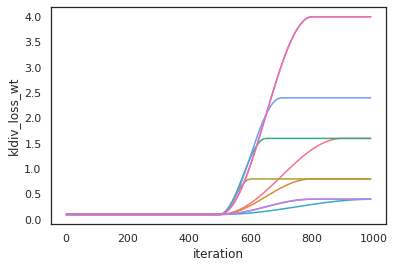

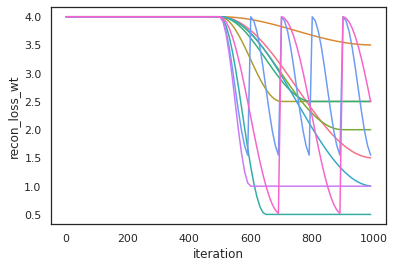

In [4]:
import liGAN
import random, torch

sns.set_palette('husl', 10)

def plot_ls(ylabel, start_wt, type, period, end_wt):
    f, _ = liGAN.loss_fns.get_loss_schedule(
        start_wt=start_wt,
        end_wt=end_wt,
        start_iter=500,
        period=period,
        type=type
    )
    x = torch.arange(1, 1000, 10)
    y = [f(x_) for x_ in x]
    plt.plot(x, y)
    plt.ylabel(ylabel)
    plt.xlabel('iteration')

plt.figure()
for i in range(10):
    plot_ls(
        'kldiv_loss_wt', 0.1,
        random.choice('ddcr'),
        random.choice([100, 150, 200, 250, 300, 400, 500]),
        random.choice([0.2, 0.4, 0.8, 1.6, 2.4, 3.2, 4.0])
    )
plt.figure()
for i in range(10):
    plot_ls(
        'recon_loss_wt', 4.0,
        random.choice('ddcr'),
        random.choice([100, 150, 200, 250, 300, 400, 500]),
        random.choice([3.5, 3.0, 2.5, 2.0, 1.5, 1.0, 0.5])
    )

In [368]:
import param_search

base_params = param_search.ParamSpace( # train7 - different conditional transform
    
    # data params
    data_root='/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output',
    train_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types',
    test_file='/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types',
    diff_cond_transform=True,
    batch_size=8,
    
    # typer params
    typer_fns=['oadc', 'onc'],
    use_rec_elems=True,
    radius_fn=[1.0, 'c'],
    
    # gen model params
    gen_n_filters=28,
    gen_init_conv_pool=0,
    gen_n_levels=4,
    gen_conv_per_level=4,
    gen_spectral_norm=1,
    n_latent=128,
    skip_connect=True,
    block_type='r',
    growth_rate=0,
    width_factor=2,
    bn_factor=0,
    
    # loss fn params
    kldiv_loss_start_wt=0.1,
    recon_loss_start_wt=4.0,
    steric_loss_start_wt=1.0,
    gan_loss_start_wt=0.0,

    # optimizer params
    optim_type='RMSprop',
    gen_lr=1e-5,
    gen_grad_clip=0,
    disc_grad_clip=0,
    n_gen_train_iters=1,
    learn_recon_var=0,
    
    # other stuff
    group_name='7',
    gen_k_iter=500,
    sbatch_line='#SBATCH -C M12|2080Ti',
    
    # no GAN disc
    disc_n_filters=0,
    disc_init_conv_pool=0,
    disc_n_levels=0,
    disc_conv_per_level=0,
    n_disc_train_iters=0,
    disc_lr=0.0,

    # stage2 VAE params
    model_type='CVAE',
    prior_n_layers=0,
    kldiv2_loss_start_wt=0.0,
    recon2_loss_start_wt=0.0,
    random_seed=65,
)

sched_params = (
    param_search.ParamSpace( # increase kl div loss wt
        start_iter=250000,
        kldiv_loss_end_wt=4.0,
        kldiv_loss_period=250,
        kldiv_loss_sched_type=['d'],
        recon_loss_end_wt=4.0,
        recon_loss_period=0,
        recon_loss_sched_type='n'
    ) +
    param_search.ParamSpace( # increase kl div loss wt
        start_iter=500000,
        kldiv_loss_end_wt=4.0,
        kldiv_loss_period=500,
        kldiv_loss_sched_type=['d'],
        recon_loss_end_wt=4.0,
        recon_loss_period=0,
        recon_loss_sched_type='n'
    )
)

# evenly sample each subspace
train_params = base_params * sched_params

name_format = 'train{group_name}_{model_type}_{typer_fns}_{radius_fn}_' \
    'k{kldiv_loss_period}_{kldiv_loss_sched_type}_{kldiv_loss_end_wt}_' \
    '{random_seed}'

len(train_params)

8

In [369]:
import random
random.seed(0)
np.random.seed(0)

sampled_params = train_params #.sample(100, replace=False)

for p in sampled_params:
    name = name_format.format(**p)
    print(name)

print(len(sampled_params))

train7_CVAE_oadc_1.0_k250_d_4.0_65
train7_CVAE_oadc_1.0_k500_d_4.0_65
train7_CVAE_oadc_c_k250_d_4.0_65
train7_CVAE_oadc_c_k500_d_4.0_65
train7_CVAE_onc_1.0_k250_d_4.0_65
train7_CVAE_onc_1.0_k500_d_4.0_65
train7_CVAE_onc_c_k250_d_4.0_65
train7_CVAE_onc_c_k500_d_4.0_65
8


In [370]:
for template_file in [
    'gen_poster.config', 'gen_poster.sh',
    'gen_prior.config', 'gen_prior.sh',
    'gen_poster2.config', 'gen_poster2.sh',
    'gen_prior2.config', 'gen_prior2.sh',
    'train.config', 'train.sh'
]:
    train_job_files = param_search.setup(
        expt_dir=train_expt_dir,
        name_format=name_format,
        template_file=template_file,
        param_space=train_params,
    )

train_job_files

['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train7_CVAE_oadc_1.0_k250_d_4.0_65/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train7_CVAE_oadc_1.0_k500_d_4.0_65/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train7_CVAE_oadc_c_k250_d_4.0_65/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train7_CVAE_oadc_c_k500_d_4.0_65/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train7_CVAE_onc_1.0_k250_d_4.0_65/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train7_CVAE_onc_1.0_k500_d_4.0_65/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train7_CVAE_onc_c_k250_d_4.0_65/train.sh',
 '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train7_CVAE_onc_c_k500_d_4.0_65/train.sh']

In [371]:
job_ids = param_search.submit(train_job_files)
job_ids

NameError: name 'jobs_ids' is not defined

In [372]:
job_ids

[7081127, 7081128, 7081129, 7081130, 7081131, 7081132, 7081133, 7081134]

In [606]:
train_jobs = pd.DataFrame(dict(
    job_id=[
        # these first jobs were full-scale, had major performance issues, didn't have separate receptor element ranges
        #[6814533, 6814534, 6814535, 6814536, 6814537, 6814538, 6814539, 6814540, 6814541, 6814542, 6814543, 6814544, 6814545, 6814546, 6814547, 6814548, 6814549, 6814550, 6814551, 6814552, 6814553, 6814554, 6814555, 6814556, 6814557, 6814558, 6814559, 6814560, 6814561, 6814562, 6814563, 6814564, 6814565, 6814566, 6814567, 6814568, 6814569, 6814570, 6814571, 6814572, 6814573, 6814574, 6814575, 6814576, 6814577, 6814578, 6814579, 6814580, 6814581, 6814582, 6814583, 6814584, 6814585, 6814586, 6814587, 6814588, 6814589, 6814590, 6814591, 6814592, 6814593, 6814594, 6814595, 6814596, 6814597, 6814598, 6814599, 6814600, 6814601, 6814602, 6814603, 6814604, 6814605, 6814606, 6814607, 6814608, 6814609, 6814610, 6814611, 6814612, 6814613, 6814614, 6814615, 6814616, 6814617, 6814618, 6814619, 6814620, 6814621, 6814622, 6814623, 6814624, 6814625, 6814626, 6814627, 6814628, 6814629, 6814630, 6814631, 6814632, 6814633, 6814634, 6814635, 6814636, 6814637, 6814638, 6814639, 6814640, 6814641, 6814642, 6814643, 6814644, 6814645, 6814646, 6814647, 6814648, 6814649, 6814650, 6814651, 6814652, 6814653, 6814654, 6814655, 6814656, 6814657, 6814658, 6814659, 6814660, 6814661, 6814662, 6814663, 6814664, 6814665, 6814666, 6814667, 6814668, 6814669, 6814670, 6814671, 6814672, 6814673, 6814674, 6814675, 6814676],

        # train0 CVAEs, CVAEGANs, and CGANs, first submit
        [6818214, 6818215, 6818216, 6818217, 6818218, 6818219, 6818220, 6818221, 6818222, 6818223, 6818224, 6818225, 6818226, 6818227, 6818228, 6818229, 6818230, 6818231, 6818232, 6818233, 6818234, 6818235, 6818236, 6818237, 6818238, 6818239, 6818240, 6818241, 6818242, 6818243],

        # train1 CVAEs, CVAEGANs, and CGANs, first submit (held most CVAEGANs and CGANs to allow full data jobs)
        [6820019, 6820020, 6820021, 6820022, 6820023, 6820024, 6820025, 6820026, 6820027, 6820028, 6820029, 6820030, 6820031, 6820032, 6820033, 6820034, 6820035, 6820036, 6820037, 6820038, 6820039, 6820040, 6820041, 6820042, 6820043, 6820044, 6820045, 6820046, 6820047, 6820048, 6820049, 6820050, 6820051, 6820052, 6820053, 6820054, 6820055, 6820056, 6820057, 6820058, 6820059, 6820060, 6820061, 6820062, 6820063, 6820064, 6820065, 6820066, 6820067, 6820068, 6820069, 6820070, 6820071, 6820072, 6820073, 6820074, 6820075, 6820076, 6820077, 6820078, 6820079, 6820080, 6820081, 6820082, 6820083, 6820084, 6820085, 6820086, 6820087, 6820088, 6820089, 6820090, 6820091, 6820092, 6820093, 6820094, 6820095, 6820096, 6820097, 6820098, 6820099, 6820100, 6820101, 6820102, 6820103, 6820104, 6820105, 6820106, 6820107, 6820108],

        # train1 models that got CUDA error on g005, resubmit with -x g005
        [6820859, 6820860, 6820861, 6820862, 6820863, 6820864, 6820865, 6820866, 6820867, 6820868, 6820869, 6820870, 6820871, 6820872, 6820873, 6820874, 6820875, 6820876, 6820877, 6820878, 6820879, 6820880, 6820881, 6820882, 6820883, 6820884, 6820885, 6820886, 6820887, 6820888, 6820889, 6820890, 6820891, 6820892, 6820893, 6820894, 6820895, 6820896, 6820897, 6820898, 6820899, 6820900, 6820901, 6820902, 6820903, 6820904, 6820905, 6820906, 6820907, 6820908, 6820909, 6820910, 6820911, 6820912, 6820913, 6820914, 6820915, 6820916, 6820917, 6820918, 6820919, 6820920, 6820921, 6820922, 6820923, 6820924, 6820925, 6820926, 6820927, 6820928],

        # train2 CVAEs on full dataset, first submit
        [6820935, 6820936, 6820937, 6820938, 6820939, 6820940, 6820941, 6820942, 6820943, 6820944, 6820945, 6820946, 6820947, 6820948, 6820949, 6820950, 6820951, 6820952, 6820953, 6820954, 6820955, 6820956, 6820957, 6820958],

        # train1 CVAEs with gen_lr=1e-5 that hit 100k, resubmit to train to 200k- errors loading state
        #[6831137, 6831138, 6831139, 6831140, 6831141, 6831142, 6831143],
        
        # train1- same jobs as last submit, but fixed loading solver state
        [6834544, 6834545, 6834546, 6834547, 6834548, 6834549],

        # BUG STARTS HERE- switched from lig elems to rec elems (for rec AND lig)
        # train2- resubmit all jobs, training to 200k- these did not have continue set, so they started from 0
        #[6837351, 6837352, 6837353, 6837354, 6837355, 6837356, 6837357, 6837358, 6837359, 6837360, 6837361, 6837362, 6837363, 6837364, 6837365, 6837366, 6837367, 6837368, 6837369, 6837370, 6837371, 6837372, 6837373, 6837374],

        # train2- let's try that again
        [6837376, 6837377, 6837378, 6837379, 6837380, 6837381, 6837382, 6837383, 6837384, 6837385, 6837386, 6837387, 6837388, 6837389, 6837390, 6837391, 6837392, 6837393, 6837394, 6837395, 6837396, 6837397, 6837398, 6837399],

        # train1- released jobs tried to continue from iter 0, but no metrics file was found. add try-except to ignore this
        [6837497, 6837498, 6837499, 6837500, 6837501, 6837502, 6837503, 6837504, 6837505, 6837506, 6837507, 6837508, 6837509, 6837510, 6837511, 6837512, 6837513, 6837514, 6837515, 6837516, 6837517, 6837518, 6837519, 6837520, 6837521, 6837522, 6837523, 6837524, 6837525, 6837526, 6837527, 6837528, 6837529, 6837530, 6837531, 6837532, 6837533, 6837534, 6837535, 6837536, 6837537, 6837538, 6837539, 6837540, 6837541, 6837542, 6837543, 6837544, 6837545, 6837546, 6837547, 6837548],

        # train2- train full data CVAEs to 300k
        [6837556, 6837557, 6837558, 6837559, 6837560, 6837561, 6837562, 6837563, 6837564, 6837565, 6837566, 6837567, 6837568, 6837569, 6837570, 6837571, 6837572, 6837573, 6837574, 6837575, 6837576, 6837577, 6837578, 6837579],

        # train2- manually resubmitted with fixed SBATCH -c M16 due to cuda oom (expecting more...)
        [6837581, 6837582],
        
        # train1- resubmit best lrs combos of each model (CVAEs to 300k, others to 200k)
        [6845980, 6845981, 6845982, 6845983, 6845984, 6845985, 6845986, 6845987, 6845988, 6845989, 6845990, 6845991, 6845992, 6845993, 6845994, 6845995, 6845996, 6845997],

        # train2- manually resubmitted job, got unable to allocate bytes on torch.save
        [6845999],
        
        # BUG FIXED HERE- switched to rec elems for rec, lig elems for lig
        # train1- resubmit best of each model type to train out the bug
        [6853415, 6853416, 6853417, 6853418, 6853419, 6853420, 6853421, 6853422, 6853423, 6853424, 6853425, 6853426, 6853427, 6853428, 6853429, 6853430, 6853431, 6853432],
        # train2- resubmit best lr combo models to train out the bug
        [6853433, 6853434, 6853435, 6853436, 6853437, 6853438, 6853439, 6853440],
        
        # train3- random search space seed 0 (held)
        [6879506, 6879509, 6879511, 6879513, 6879514, 6879515, 6879516, 6879517, 6879518, 6879519, 6879520, 6879521, 6879522, 6879523, 6879524, 6879525, 6879526, 6879527, 6879528, 6879529, 6879530, 6879531, 6879532, 6879533, 6879534, 6879535, 6879536, 6879537, 6879538, 6879539, 6879541, 6879542, 6879544, 6879546, 6879551, 6879553, 6879555, 6879560, 6879561, 6879564, 6879567, 6879569, 6879571, 6879572, 6879573, 6879575, 6879576, 6879577, 6879578, 6879579, 6879580, 6879581, 6879582, 6879583, 6879584, 6879585, 6879586, 6879587, 6879588, 6879589, 6879590, 6879591, 6879592, 6879593, 6879594, 6879595, 6879596, 6879599, 6879602, 6879603, 6879605, 6879608, 6879613, 6879617, 6879619, 6879622, 6879624, 6879626, 6879627, 6879628, 6879629, 6879631, 6879632, 6879633, 6879634, 6879635, 6879636, 6879637, 6879638, 6879639, 6879640, 6879641, 6879642, 6879643, 6879644, 6879645, 6879646, 6879647, 6879648, 6879649, 6879650, 6879651, 6879652, 6879653, 6879654, 6879655, 6879656, 6879665, 6879666, 6879667, 6879668, 6879669, 6879670, 6879671, 6879672, 6879673, 6879674, 6879675, 6879676, 6879677, 6879678, 6879679, 6879680, 6879681, 6879682, 6879683, 6879684, 6879685, 6879686, 6879687, 6879688, 6879689, 6879702, 6879703, 6879704, 6879705, 6879706, 6879707, 6879708, 6879709, 6879710, 6879711, 6879712, 6879713, 6879714, 6879715, 6879716, 6879717, 6879718, 6879719, 6879720, 6879721, 6879722, 6879723, 6879724, 6879725, 6879752, 6879753, 6879754, 6879755, 6879756, 6879757, 6879758, 6879759, 6879760, 6879761, 6879762, 6879763, 6879764, 6879765, 6879766, 6879767, 6879768, 6879769, 6879770, 6879771, 6879772, 6879783, 6879784, 6879785, 6879786, 6879787, 6879788, 6879789, 6879790, 6879791, 6879792, 6879793, 6879794, 6879795, 6879796, 6879797, 6879798, 6879799, 6879800, 6879801, 6879802, 6879803, 6879804, 6879805, 6879806, 6879807, 6879820, 6879821, 6879822, 6879823, 6879824, 6879825, 6879826, 6879827, 6879828, 6879829, 6879830, 6879831, 6879832, 6879833, 6879834, 6879835, 6879836, 6879837, 6879838, 6879839, 6879840, 6879841, 6879842, 6879843, 6879844, 6879865, 6879866, 6879867, 6879868, 6879869, 6879870, 6879871, 6879872, 6879873, 6879874, 6879875, 6879876, 6879877, 6879878, 6879879, 6879880, 6879881, 6879882, 6879883, 6879884, 6879885, 6879886, 6879887, 6879888, 6879897, 6879898, 6879899, 6879900, 6879901, 6879902, 6879903, 6879904, 6879905, 6879906, 6879907, 6879908, 6879909, 6879910, 6879911, 6879912, 6879913, 6879914, 6879915, 6879916, 6879917, 6879918, 6879919, 6879920, 6879921, 6879939, 6879940, 6879941, 6879942, 6879943, 6879944, 6879945, 6879946, 6879947, 6879948, 6879949, 6879950, 6879951, 6879952, 6879953, 6879954, 6879955, 6879956, 6879957, 6879958, 6879959, 6879960, 6879984, 6879985],

        # train3- fix unbound loss_gen error and resubmit (jobs with disc_train_iters=1) (released)
        [6883168, 6883169, 6883170, 6883171, 6883172, 6883173, 6883174, 6883175, 6883176, 6883177, 6883178, 6883179],
        
        # train3- resubmit CUDA oom models with -C M12 (released)
        [6883206, 6883207, 6883208, 6883209],
        
        # train3- jobs that already reached < 150 test recon loss by 100k
        [6889371, 6889372, 6889373, 6889374, 6889375, 6889376, 6889377],
        
        # train3- resubmitted jobs with under < 200 test recon loss (same models as prev to 300k plus some new to 200k)
        [6890657, 6890658, 6890659, 6890660, 6890661, 6890662, 6890663, 6890664, 6890665, 6890666, 6890667, 6890668, 6890669, 6890670, 6890671, 6890672],

        # train3- resubmit CUDA oom models with -C M16, then cancel ones already running (reason=dependency)
        [6890882, 6890883, 6890884, 6890885, 6890886, 6890887, 6890888, 6890889, 6890890, 6890891, 6890892, 6890893, 6890894, 6890895, 6890896, 6890897, 6890898, 6890899, 6890900, 6890901, 6890902, 6890903, 6890904, 6890905, 6890906],

        # train4 - submit all with clamped steric loss
        [6922074, 6922075, 6922076, 6922077, 6922078, 6922079, 6922080, 6922081, 6922082, 6922083, 6922084, 6922085, 6922086, 6922087, 6922088, 6922089, 6922090, 6922091, 6922092, 6922093, 6922094, 6922095, 6922096, 6922097, 6922098, 6922099, 6922100, 6922101, 6922102, 6922103, 6922104, 6922105, 6922106, 6922107, 6922108, 6922109, 6922110, 6922111, 6922112, 6922113, 6922114, 6922115, 6922116, 6922117, 6922118, 6922119, 6922120, 6922121, 6922122, 6922123, 6922124, 6922125, 6922126, 6922127, 6922128, 6922129, 6922130, 6922131, 6922132, 6922133, 6922134, 6922135, 6922136, 6922137, 6922138, 6922139, 6922140, 6922141, 6922142, 6922143, 6922144, 6922145, 6922146, 6922147, 6922148, 6922149, 6922150, 6922151, 6922152, 6922153, 6922154, 6922155, 6922156, 6922157, 6922158, 6922159, 6922160, 6922161, 6922162, 6922163, 6922164, 6922165, 6922166, 6922167, 6922168, 6922169, 6922170, 6922171, 6922172, 6922173],

        # train4- resubmit better-than-train3 jobs that errored out
        [6970651, 6970652, 6970653, 6970654, 6970655, 6970656, 6970657, 6970658, 6970659, 6970660],
        
        # train4- resubmit all cuda oom jobs with more requested GPU memory
        [6970667, 6970668, 6970669, 6970670, 6970671, 6970672, 6970673, 6970674, 6970675, 6970676, 6970677, 6970678, 6970679, 6970680, 6970681, 6970682, 6970683, 6970684, 6970685],

        # train5 - submit all in order of decreasing estimated GPU memory
        [6971032, 6971033, 6971034, 6971035, 6971036, 6971037, 6971038, 6971039, 6971040, 6971041, 6971042, 6971043, 6971044, 6971045, 6971046, 6971047, 6971048, 6971049, 6971050, 6971051, 6971052, 6971053, 6971054, 6971055, 6971056, 6971057, 6971058, 6971059, 6971060, 6971061, 6971062, 6971063, 6971064, 6971065, 6971066, 6971067, 6971068, 6971069, 6971070, 6971071, 6971072, 6971073, 6971074, 6971075, 6971076, 6971077, 6971078, 6971079, 6971080, 6971081, 6971082, 6971083, 6971084, 6971085, 6971086, 6971087, 6971088, 6971089, 6971090, 6971091, 6971092, 6971093, 6971094, 6971095, 6971096, 6971097, 6971098, 6971099, 6971100, 6971101, 6971102, 6971103, 6971104, 6971105, 6971106, 6971107, 6971108, 6971109, 6971110, 6971111, 6971112, 6971113, 6971114, 6971115, 6971116, 6971117, 6971118, 6971119, 6971120, 6971121, 6971122, 6971123, 6971124, 6971125, 6971126, 6971127, 6971128, 6971129, 6971130, 6971131],

        # train5 - resubmit OOM jobs with batch size = 4 and no SBATCH line
        [6971166, 6971167, 6971168, 6971169, 6971170, 6971171, 6971172, 6971173, 6971174, 6971175, 6971176, 6971177, 6971178, 6971179, 6971180, 6971181, 6971182, 6971183, 6971184, 6971185, 6971186, 6971187, 6971188, 6971189, 6971190, 6971191, 6971192, 6971193, 6971194, 6971195, 6971196, 6971197, 6971198, 6971199],

        # train4 and train5 - resubmit promising jobs that are not currently running
        [6971523, 6971524, 6971525, 6971526, 6971527, 6971528, 6971529, 6971530, 6971531, 6971532, 6971533, 6971534],
        [6971535, 6971536, 6971537, 6971538, 6971539, 6971540, 6971541, 6971542, 6971543, 6971544, 6971545, 6971546, 6971547, 6971548, 6971549, 6971550, 6971551, 6971552, 6971553, 6971554, 6971555, 6971556, 6971557, 6971558, 6971559, 6971560, 6971561, 6971562, 6971563, 6971564, 6971565, 6971566],
        
        # train6- first submit with no mem request, few gpus available, most failed with cuda oom
        [6987997, 6987998, 6987999, 6988000, 6988001, 6988002, 6988003, 6988004, 6988005, 6988006, 6988007, 6988008, 6988009, 6988010, 6988011, 6988012, 6988013, 6988014, 6988015, 6988016, 6988017, 6988018, 6988019, 6988020, 6988021, 6988022, 6988023, 6988024, 6988025, 6988026, 6988027, 6988028, 6988029, 6988030, 6988031, 6988032, 6988033, 6988034, 6988035, 6988036, 6988037, 6988038, 6988039, 6988040, 6988041, 6988042, 6988043, 6988044, 6988045, 6988046, 6988047, 6988048, 6988049, 6988050, 6988051, 6988052, 6988053, 6988054, 6988055, 6988056, 6988057, 6988058, 6988059, 6988060, 6988061, 6988062, 6988063, 6988064, 6988065, 6988066, 6988067, 6988068, 6988069, 6988070, 6988071, 6988072, 6988073, 6988074, 6988075, 6988076, 6988077, 6988078, 6988079, 6988080, 6988081, 6988082, 6988083, 6988084, 6988085, 6988086, 6988087, 6988088, 6988089, 6988090, 6988091, 6988092, 6988093, 6988094, 6988095, 6988096],
        
        # train6- resubmit with M12 and fix solver state files after name format change
        [6988124, 6988125, 6988126, 6988127, 6988128, 6988129, 6988130, 6988131, 6988132, 6988133, 6988134, 6988135, 6988136, 6988137, 6988138, 6988139, 6988140, 6988141, 6988142, 6988143, 6988144, 6988145, 6988146, 6988147, 6988148, 6988149, 6988150, 6988151, 6988152, 6988153, 6988154, 6988155, 6988156, 6988157, 6988158, 6988159, 6988160, 6988161, 6988162, 6988163, 6988164, 6988165, 6988166, 6988167, 6988168, 6988169, 6988170, 6988171, 6988172, 6988173, 6988174, 6988175, 6988176, 6988177, 6988178, 6988179, 6988180, 6988181, 6988182, 6988183, 6988184, 6988185, 6988186, 6988187, 6988188, 6988189, 6988190, 6988191, 6988192, 6988193, 6988194, 6988195, 6988196, 6988197, 6988198, 6988199, 6988200, 6988201, 6988202, 6988203, 6988204, 6988205, 6988206, 6988207, 6988208, 6988209, 6988210, 6988211, 6988212, 6988213, 6988214, 6988215, 6988216, 6988217, 6988218, 6988219, 6988220, 6988221, 6988222, 6988223],

        # train6- cancel and resubmit me with revised vae2 loss weights
        [6988235, 6988236, 6988237, 6988238, 6988239, 6988240, 6988241, 6988242, 6988243, 6988244, 6988245, 6988246, 6988247, 6988248, 6988249, 6988250, 6988251, 6988252, 6988253, 6988254, 6988255, 6988256, 6988257, 6988258, 6988259, 6988260, 6988261, 6988262, 6988263, 6988264, 6988265, 6988266, 6988267, 6988268, 6988269, 6988270, 6988271, 6988272, 6988273, 6988274, 6988275, 6988276, 6988277, 6988278, 6988279, 6988280, 6988281, 6988282, 6988283, 6988284, 6988285, 6988286, 6988287, 6988288, 6988289, 6988290, 6988291, 6988292, 6988293, 6988294, 6988295, 6988296, 6988297, 6988298, 6988299, 6988300, 6988301, 6988302, 6988303, 6988304, 6988305, 6988306, 6988307, 6988308, 6988309, 6988310, 6988311, 6988312, 6988313, 6988314, 6988315, 6988316, 6988317, 6988318, 6988319, 6988320, 6988321, 6988322, 6988323, 6988324, 6988325, 6988326, 6988327, 6988328, 6988329, 6988330, 6988331, 6988332, 6988333, 6988334],
        
        # train6- accidentally cancelled all jobs, resumbit ones with increased prior n_atoms
        [7017136, 7017139, 7017141, 7017142, 7017146, 7017147, 7017148, 7017149, 7017150, 7017151, 7017152, 7017153, 7017154, 7017155, 7017156, 7017157, 7017158, 7017159, 7017160, 7017161, 6988316, 6988317, 6988318, 6988319, 6988320, 6988321, 6988322, 6988323, 6988324, 6988325, 6988326, 6988327, 6988328, 6988329, 6988330, 6988331, 6988332, 6988333, 6988334, 7017120, 7017121, 7017122, 7017123, 7017124, 7017125, 7017126, 7017127, 7017128, 7017129, 7017130, 7017131, 7017133],

        # train6- manually resubmit two best models (CVAE1,CVAE2), along with a tweaked version of each
        # the tweaked CVAE1 uses a decay schedule instead of cosine-restart, which I interpretted as a bug
        # the tweaked CVAE2 is decaying all loss wts to 0, no learn_recon_var, so is just training stage 2
        # also manually submit final train4 model (starting point of train6)
        [7063769, 7063773, 7063768, 7063771],
        # continue training the two train4 jobs on param path as well
        [7063801,7063802],
        # train6 - continue from 450k, decay kldiv loss wt up to 4.0
        [7063924],
        # train6 - remove check for zero gradient and resubmit prior-training-only model
        [7064053],
        # train7 - training with different conditional transforms
        [7081127, 7081128, 7081129, 7081130, 7081131, 7081132, 7081133, 7081134],
        # train6- manually submit model that stopped at 950k instead of 1m
        [7087076],
    ],
    group_name=[0,1,1,2,1,2,1,2,2,1,2,1,2,3,3,3,3,3,3,4,4,4,5,5,4,5,6,6,6,6,6,4,6,6,7,6]
)).explode('job_id')

In [607]:
%%time
import param_search
param_search.job_queues.verbose = False
from collections import defaultdict

print('Getting queue status')
qstat = param_search.status(job=train_jobs['job_id'])

if qstat['job_id'].dtype in {str, object}:
    qstat[['job_id', 'array_idx']] = qstat['job_id'].str.split('_', expand=True)
qstat['job_id'] = qstat['job_id'].map(pd.to_numeric)

print('Merging data frames')
train_jobs = train_jobs.merge(qstat, on='job_id', how='left')

print('Finding work dirs')
work_dir_map = find_work_dirs()
train_jobs['work_dir'] = train_jobs.apply(find_work_dir, axis=1)

print('Getting job names and files')
train_jobs['job_name'] = train_jobs['work_dir'].map(catch_exc(os.path.basename, TypeError))
train_jobs['job_file'] = train_jobs.apply(lambda x: '{work_dir}/train.sh'.format(**x), axis=1)
train_jobs['stdout_file'] = train_jobs.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
train_jobs['stderr_file'] = train_jobs.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
train_jobs['metrics_file'] = train_jobs.apply(lambda x: '{work_dir}/{job_name}.train_metrics'.format(**x), axis=1)

Getting queue status
Merging data frames
Finding work dirs
Getting job names and files
CPU times: user 451 ms, sys: 140 ms, total: 591 ms
Wall time: 939 ms


In [608]:
# read in ALL training params
train_jobs = train_jobs[
    ~train_jobs['work_dir'].isnull()
].groupby(['job_name']).last().reset_index()
train_params = train_jobs['job_file'].apply(param_search.params.read_params, line_start='# ')
train_params = pd.DataFrame(train_params.tolist()).set_index('job_name')
train_params['out_prefix'] = train_params.index.map(lambda x: '{}/{}'.format(x, x))
train_params['last_iter'] = train_params['out_prefix'].map(catch_exc(liGAN.training.find_last_iter, FileNotFoundError))
train_params

,data_root,train_file,test_file,batch_size,typer_fns,use_rec_elems,radius_fn,gen_n_filters,gen_conv_per_level,bn_factor,gen_spectral_norm,n_latent,skip_connect,kldiv_loss_start_wt,recon_loss_start_wt,steric_loss_start_wt,optim_type,gen_lr,gen_grad_clip,disc_grad_clip,n_gen_train_iters,group_name,gen_k_iter,random_seed,gen_init_conv_pool,gen_n_levels,block_type,growth_rate,width_factor,model_type,disc_init_conv_pool,disc_n_levels,disc_conv_per_level,disc_n_filters,n_disc_train_iters,disc_lr,gan_loss_wt,sbatch_line,gan_loss_start_wt,learn_recon_var,prior_n_layers,kldiv2_loss_start_wt,recon2_loss_start_wt,start_iter,kldiv_loss_end_wt,kldiv_loss_period,kldiv_loss_sched_type,recon_loss_end_wt,recon_loss_period,recon_loss_sched_type,diff_cond_transform,out_prefix,last_iter
job_name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34,/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types,10,oadc,True,1.0,32,3,0,1,128,True,0.2,2.0,0.0,RMSprop,0.00001,0,0,1,4,100,34,0,4,c,0,2,CVAE,0,0,0,0,0,0.0,0.0,,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34/train4_CVAE_c200_G3243_1.0e-05_D...,None
train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45,/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types,10,oadc,True,1.0,28,4,0,1,128,True,0.1,4.0,1.0,RMSprop,0.00001,0,0,1,4,100,45,0,4,r,0,2,CVAE,0,0,0,0,0,0.0,0.0,#SBATCH -C M16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45/train4_CVAE_r200_G2844_1.0e-05_D...,None
train6_CVAE2_0_p2_1.0_1.0_k100_d_0.0_r100_d_0.0_8,/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types,8,oadc,True,1.0,28,4,0,1,128,True,0.1,4.0,1.0,RMSprop,0.00001,5000,0,1,6,600,8,0,4,r,0,2,CVAE2,0,0,0,0,0,0.0,NaN,#SBATCH -C M12,0.0,0.0,2.0,1.0,1.0,450000.0,0.0,100.0,d,0.0,100.0,d,NaN,train6_CVAE2_0_p2_1.0_1.0_k100_d_0.0_r100_d_0.0_8/train6_CVAE2_0_p2_1.0_1.0_k100_d_0.0_r100_d_0.0_8,None
train6_CVAE_0_p0_0.0_0.0_k400_d_4.0_r0_n_4.0_65,/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types,8,oadc,True,1.0,28,4,0,1,128,True,0.1,4.0,1.0,RMSprop,0.00001,5000,0,1,6,600,65,0,4,r,0,2,CVAE,0,0,0,0,0,0.0,NaN,#SBATCH -C M12,0.0,0.0,0.0,0.0,0.0,450000.0,4.0,400.0,d,4.0,0.0,n,NaN,train6_CVAE_0_p0_0.0_0.0_k400_d_4.0_r0_n_4.0_65/train6_CVAE_0_p0_0.0_0.0_k400_d_4.0_r0_n_4.0_65,None
train7_CVAE_oadc_1.0_k250_d_4.0_65,/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types,8,oadc,True,1.0,28,4,0,1,128,True,0.1,4.0,1.0,RMSprop,0.00001,0,0,1,7,500,65,0,4,r,0,2,CVAE,0,0,0,0,0,0.0,NaN,#SBATCH -C M12|2080Ti,0.0,0.0,0.0,0.0,0.0,250000.0,4.0,250.0,d,4.0,0.0,n,True,train7_CVAE_oadc_1.0_k250_d_4.0_65/train7_CVAE_oadc_1.0_k250_d_4.0_65,None
train7_CVAE_oadc_1.0_k500_d_4.0_65,/net/pulsar/home/koes/paf46_shared/PocketomeGenCross_Output,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_train0.types,/net/pulsar/home/koes/mtr22/gan/data/it2_tt_0_lowrmsd_valid_mols_test0.types,8,oadc,True,1.0,28,4,0,1,128,True,0.1,4.0,1.0,RMSprop,0.00001,0,0,1,7,500,65,0,4,r,0,2,CVAE,0,0,0,0,0,0.0,NaN,#SBATCH -C M12|2080Ti,0.0,0.0,0.0,0.0,0.0,500000.0,4.0,500.0,d,4.0,0.0,n,Tr

In [609]:
pd.set_option('display.max_columns', 100)
has = lambda x: not pd.isnull(x)

train_param_path = [
    'train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0',
    'train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0',   # reduce latent space size, use receptor elements
    'train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0', # switch to acceptor/donor/charge atom typer
    'train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93', # < kldiv wt, > recon wt
    'train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34', # spectral norm, < kldiv wt, skip connect
    'train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45', # deeper/narrower, resnet, > recon wt, steric loss
    'train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65', # CVAE1- > kldiv wt w/ loss schedule, gradient clipping
    'train6_CVAE2_0_p0_4.0_4.0_k200_d_1.6_r0_n_4.0_65', # CVAE1 with decay schedule instead of cosine restart
    'train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8', # CVAE2- stage 2 VAE, learn recon variance
    'train6_CVAE2_0_p2_1.0_1.0_k100_d_0.0_r100_d_0.0_8', # CVAE2 but training only the stage 2 VAE
    'train6_CVAE_0_p0_0.0_0.0_k400_d_4.0_r0_n_4.0_65', # CVAE1 but decay kldiv wt to 4.0
    'train7_CVAE_oadc_1.0_k250_d_4.0_65',
    'train7_CVAE_oadc_1.0_k500_d_4.0_65',
]
ignore_cols = {'sbatch_line', 'gen_iteration', 'group_name', 'random_seed', 'batch_size', 'gen_k_iter'}

default_train_params = dict(
    gen_init_conv_pool=0,
    gen_n_levels=4,
    gen_conv_per_level=3,
    gen_block_type='c',
    gen_n_filters=32,
    #kldiv_loss_wt=1,
    #recon_loss_wt=1,
    #gan_loss_wt=0,
    disc_init_conv_pool=0,
    disc_block_type='c',
    disc_conv_per_level=0,
    disc_n_levels=0,
    disc_n_filters=0,
    bn_factor=0,
    skip_connect=False,
    steric_loss_wt=0,
    block_type='c',
    growth_rate=0,
    width_factor=2,
)

for k, v in default_train_params.items():
    train_params[k] = train_params[k].fillna(v)

def param_diff(param_path):
    row1 = train_params.loc[param_path[0]]
    row2 = train_params.loc[param_path[-1]]
    diff_cols = [
        c for c in train_params if (row2[c] != row1[c] and (has(row2[c]) or has(row1[c]))) and c not in ignore_cols
    ]
    return train_params.loc[param_path][diff_cols]

param_diff(train_param_path)

KeyError: 'gen_block_type'

In [610]:
%%time

train_jobs = train_jobs[
    train_jobs['job_name'].isin(train_param_path) &
    ~train_jobs['work_dir'].isnull()
]

print('Reading stdout files (train)')
train_jobs['stdout_train'] = train_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError),
    ignore_pat=r'^\[iteration=\d+( disc_iter=\d+)? data_phase=(test.*?|train model_phase=disc.*?)\]',
    output_pat=r'^(\[.+\].*)'
)
print()

print('Reading stdout files (test)')
train_jobs['stdout_test'] = train_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError),
    ignore_pat=r'^\[iteration=\d+( disc_iter=\d+)? data_phase=(train.*?|test model_phase=disc.*?)\]',
    output_pat=r'^(\[.+\].*)'
)
print()

print('Reading stderr files')
train_jobs['stderr'] = train_jobs['stderr_file'].apply(
    catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError),
    break_pat='^==============================',
    ignore_pat=None,
    error_pat=r'^(.*(Error|Exception|error|fault|failed|Errno|Killed).*)$'
) #
print()
train_jobs['job_state'] = train_jobs.apply(find_job_state, axis=1)

# make the order that job_names appear explicit so we can use it
#   to easily view different job_ids associated with each job_name
job_name_idx = {j:i for i, j in enumerate(train_jobs['job_name'].unique())}
#train_jobs['job_name_idx'] = train_jobs['job_name'].map(train_param_path.index)
#train_jobs['job_name_idx'] = train_jobs['job_file'].map(train_job_files.index)

Reading stdout files (train)
......
Reading stdout files (test)
......
Reading stderr files
......
CPU times: user 18.1 ms, sys: 423 µs, total: 18.5 ms
Wall time: 28.7 ms


In [509]:
pd.set_option('display.max_rows', 350)
pd.set_option('display.max_colwidth', 100)
import re
import datetime as dt

def as_timedelta(x):
    if pd.isnull(x):
        return np.nan
    x = x.split('-', 1)
    days = int(x[0]) if len(x) == 2 else 0
    x = x[-1].split(':', 2)
    hours = int(x[0])
    minutes = int(x[1])
    seconds = int(x[2]) if len(x) > 2 else 0
    return days + (hours + (minutes + seconds/60)/60)/24

train_jobs['iteration'] = train_jobs['stdout_train'].map(
    lambda x: int(re.search('iteration=(\d+) ', x).group(1)) if x else np.nan
)
train_jobs['train_recon_loss'] = train_jobs['stdout_train'].map(
    lambda x: np.round(float(re.search('recon_loss=(\S+) ', x).group(1))) if x and 'recon_loss' in x else np.nan
)
train_jobs['test_recon_loss'] = train_jobs['stdout_test'].map(
    lambda x: np.round(float(re.search('recon_loss=(\S+) ', x).group(1))) if x and 'recon_loss' in x else np.nan
)
train_jobs['test_type_diff'] = train_jobs['stdout_test'].map(
    lambda x: np.round(float(re.search('lig_gen_fit_type_diff=(\S+) ', x).group(1))) if x and 'type_diff' in x else np.nan
)

train_jobs['days'] = train_jobs['runtime'].map(as_timedelta)
train_jobs['iters_day'] = ((train_jobs['iteration'] - (train_jobs['group_name'] == 6)*450000) / train_jobs['days']).map(np.round)

running_jobs = train_jobs[
    (train_jobs['job_state'] == 'R')
]

train_jobs.set_index(['group_name', 'job_name', 'job_id']) \
    .sort_values(['job_id'])[[
    'runtime', 'node_id', 'job_state',
    'iteration', 'days', 'iters_day',
    'train_recon_loss', 'test_recon_loss', 'test_type_diff',
    #'stdout_train', 'stdout_test',
    #'stderr',
]]

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

runtime node_id job_state  iteration       days  iters_day  train_recon_loss  test_recon_loss  \
group_name job_name                                                                 job_id                                                                                                       
2          train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0                               6853433          NaN     NaN        OK     400000        NaN        NaN             151.0            134.0   
           train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0                             6853435          NaN     NaN        OK     400000        NaN        NaN             138.0            120.0   
           train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0                              6853438          NaN     NaN        OK     390000        NaN        NaN             167.0            150.0   
3          train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93 6890667          NaN     NaN        OK     400000        NaN        NaN              44.0             47.0   
6          train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65                         7063768          NaN     NaN       ERR     640253        NaN        NaN               NaN              NaN   
           train6_CVAE2_0_p0_4.0_4.0_k200_d_1.6_r0_n_4.0_65                         7063769          NaN     NaN        OK    1000000        NaN        NaN              46.0              NaN   
           train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8                          7063771          NaN     NaN        OK    1000000        NaN        NaN        -7689014.0              NaN   
4          train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45          7063801  12-23:45:40    g002         R     812099  12.990046    62517.0               NaN              NaN   
           train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34          7063802  12-23:43:44    g002         R     642459  12.988704    49463.0              56.0              NaN   
6          train6_CVAE_0_p0_0.0_0.0_k400_d_4.0_r0_n_4.0_65                          7063924          NaN     NaN        OK     950000        NaN        NaN             107.0              NaN   
           train6_CVAE2_0_p2_1.0_1.0_k100_d_0.0_r100_d_0.0_8                        7064053   9-23:47:17    g017         R     892054   9.991169    44244.0              32.0              NaN   
7          train7_CVAE_oadc_1.0_k250_d_4.0_65                                       7081127   6-17:55:21    g014         R     317721   6.746771    47092.0               NaN              NaN   
           train7_CVAE_oadc_1.0_k500_d_4.0_65                                       7081128   6-17:55:18    g018         R     337825   6.746736    50072.0               NaN              NaN   

                                                                                             test_type_diff  
group_name job_name                                                                 job_id                   
2          train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0                               6853433            39.0  
           train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0                             6853435            36.0  
           train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0                              6853438            41.0  
3          train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93 6890667            13.0  
6          train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65                         7063768             NaN  
           train6_CVAE2_0_p0_4.0_4.0_k200_d_1.6_r0_n_4.0_65                         7063769             NaN  
           train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8                          7063771             NaN  
4          train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45          7063801             NaN  
           train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34          70

In [510]:
%%time
# read in training metrics

import param_search
try:
    del train_metrics # this is very big (>12gb), delete it before we reload it
    del last_iter_df
except NameError:
    pass

metric_jobs = train_jobs

dfs = []
for job_file, metrics_file in zip(metric_jobs['job_file'], metric_jobs['metrics_file']):
    try:
        df = pd.read_csv(metrics_file, sep=' ')
        print(metrics_file)
        #print('.', end='')
    except Exception as e:
        print(metrics_file, e, file=sys.stderr)
        continue
    params = param_search.params.read_params(job_file, line_start='# ')
    for param, value in params.items():
        assert param not in df, param + ' is both a param and a metric ' + metrics_file
        df[param] = value
        
    dfs.append(df)

train_metrics = pd.concat(dfs)
del dfs
train_metrics.groupby(['group_name', 'job_name'])[['iteration']].max()

train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0/train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0.train_metrics
train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0/train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0.train_metrics
train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0/train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0.train_metrics
train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93/train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93.train_metrics
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34/train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34.train_metrics
/net/pulsar/home/koes/mtr22/gan/new_atom_typing/training/train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45/train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45.train_metrics
train6_CVAE2_0_p0_4.0_4.0_k200_d_1.6_r0_n_4.0_65/train6_CVAE2_0_p0_4.0_4.0_k200_d_1.6_r0_n_4.0_65.train_metrics
train6_CVAE2_0_p0_4.0_4.

iteration
group_name job_name                                                                           
2          train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0                                 400000
           train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0                                  390000
           train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0                                   400000
3          train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93     400000
4          train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34              642400
           train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45              641700
6          train6_CVAE2_0_p0_4.0_4.0_k200_d_1.6_r0_n_4.0_65                            1000000
           train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65                             640200
           train6_CVAE2_0_p2_1.0_1.0_k100_d_0.0_r100_d_0.0_8                            892000
           train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8                             1000000
           train6_CVAE_0_p0_0.0_0.0_k400_d_4.0_r0_n_4.0_65                              950000
7          train7_CVAE_oadc_1.0_k250_d_4.0_65                                           317700
           train7_CVAE_oadc_1.0_k500_d_4.0_65                                           337800

In [524]:
def safe_sem(x):
    return scipy.stats.sem(x) if len(x) > 1 else np.nan

def my_plot(data, x, y, hue, ax, **kwargs):
    for h, hue_data in data.groupby(hue, sort=False):
        hue_data = hue_data[~hue_data[y].isna()]
        try:
            mean = hue_data.groupby(x)[y].agg(np.nanmean)
            sem = hue_data.groupby(x)[y].agg(safe_sem)
            ax.fill_between(mean.index, mean - 2*sem, mean + 2*sem, alpha=0.5, label=h)
            ax.plot(mean.index, mean, label=h) #, marker='x')
        except Exception as e:
            print(e, hue_data[y].dtype, y)
    ax.set_xlabel(x)
    ax.set_ylabel(y)


iter_bin_size = 5000
train_metrics['iter_bin'] = (train_metrics['iteration'] // iter_bin_size) * iter_bin_size

#train_metrics.reset_index(inplace=True)
plot_df = train_metrics.copy()

plot_df['epoch'] = plot_df['iter_bin'] * plot_df['batch_size'] / 220636

if 'gan_loss' not in plot_df:
    plot_df['gan_loss'] = np.nan
if 'kldiv2_loss' not in plot_df:
    plot_df['kldiv2_loss'] = np.nan
    plot_df['recon2_loss'] = np.nan
    plot_df['recon2_log_var'] = np.nan
    
plot_df['log_abs_loss'] = np.log10(plot_df['loss'].abs())
plot_df['log_kldiv_loss'] = np.log10(plot_df['kldiv_loss'])
plot_df['log_abs_recon_loss'] = np.log10(plot_df['recon_loss'].abs())
plot_df['log_steric_loss'] = np.log10(plot_df['steric_loss'])
plot_df['log_abs_gan_loss'] = np.log10(plot_df['gan_loss'].abs())
plot_df['log_kldiv2_loss'] = np.log10(plot_df['kldiv2_loss'])
plot_df['log_abs_recon2_loss'] = np.log10(plot_df['recon2_loss'].abs())

# apply Bessel's correction to sample variances
plot_df['bessels_correction'] = plot_df['batch_size'] / (plot_df['batch_size'] - 1)
plot_df['lig_variance'] *= plot_df['bessels_correction']
plot_df['lig_gen_variance'] *= plot_df['bessels_correction']
plot_df['lig_gen_fit_n_atoms_variance'] *= plot_df['bessels_correction']
plot_df['lig_gen_fit_type_variance'] *= plot_df['bessels_correction']

# get recon variance
plot_df['recon_variance'] = np.exp(plot_df['recon_log_var'])
plot_df['recon2_variance'] = np.exp(plot_df['recon2_log_var'])

# transform recon loss to account for variance
#plot_df['recon_loss'] = (
#    plot_df['recon_loss'] - (18*48**3)*plot_df['recon_log_var']
#) * plot_df['recon_variance']**2

plot_df['recon2_loss'] = (
    plot_df['recon2_loss'] - (128)*plot_df['recon2_log_var']
) * plot_df['recon2_variance']**2

#plot_df['job_name_idx'] = plot_df['job_name'].map(train_param_path.index)

# fill in unspecified default values
plot_df['grid_phase'] = plot_df['grid_phase'].fillna('poster')

train_y = [
    'loss',
    'kldiv_loss',
    'recon_loss',
    'kldiv2_loss',
    'recon2_loss',
    
    'log_abs_loss',
    'log_kldiv_loss',
    'log_abs_recon_loss',
    'log_kldiv2_loss',
    'log_abs_recon2_loss',
    
    'gen_grad_norm',
    'kldiv_loss_wt',
    'recon_loss_wt',
    'recon_variance',
    'recon2_variance',
    
    'lig_norm',
    'lig_gen_norm',
    'lig_variance',
    'lig_gen_variance',
    'lig_gen_L2_loss',

    'lig_n_atoms',
    'lig_gen_fit_n_atoms',
    'lig_gen_fit_n_atoms_variance',
    'lig_gen_fit_elem_diff',
    'lig_gen_fit_elem_variance',
]
train_x = 'iter_bin'

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [525]:
#colors = sns.color_palette('Blues', len(train_param_path))
colors = get_palette(n_hues=7, n_shades=[3,1,2,9,0,0,2], min_val=0.2, max_val=0.8)
sns.set_palette(colors)
colors

[(0.2391201696339079, 0.37173774571220314, 0.6176939148953006),
 (0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.4710645906194364, 0.6059461006842934, 0.8540931158384668),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726),
 (0.35896739990737436, 0.667782350274086, 0.34012294978177715),
 (0.50997943306447, 0.8276337541701332, 0.4906164845315755),
 (0.5130361214607864, 0.2584632404435582, 0.25845200100942484),
 (0.5939286535345898, 0.28675651367630084, 0.2867480616218326),
 (0.677430622126903, 0.3159624731423578, 0.31595689838302765),
 (0.7583231542007064, 0.3442557463751005, 0.3442529589954354),
 (0.8392156862745098, 0.37254901960784315, 0.37254901960784315),
 (0.8503391807594506, 0.43062979141839475, 0.43061720838881945),
 (0.8636018087991876, 0.4998799424232832, 0.49985235655075266),
 (0.8768644368389246, 0.5691300934281717, 0.569087504712686),
 (0.8905548915896209, 0.6406141202719275, 0.6405560447508106),
 (0.7203910204330348, 0.422178616934103, 0.6312918499120603),
 (0.8785981845278051, 0.5766045960420711, 0.7885283352880432)]

CPU times: user 1min 37s, sys: 34.9 s, total: 2min 11s
Wall time: 2min 12s


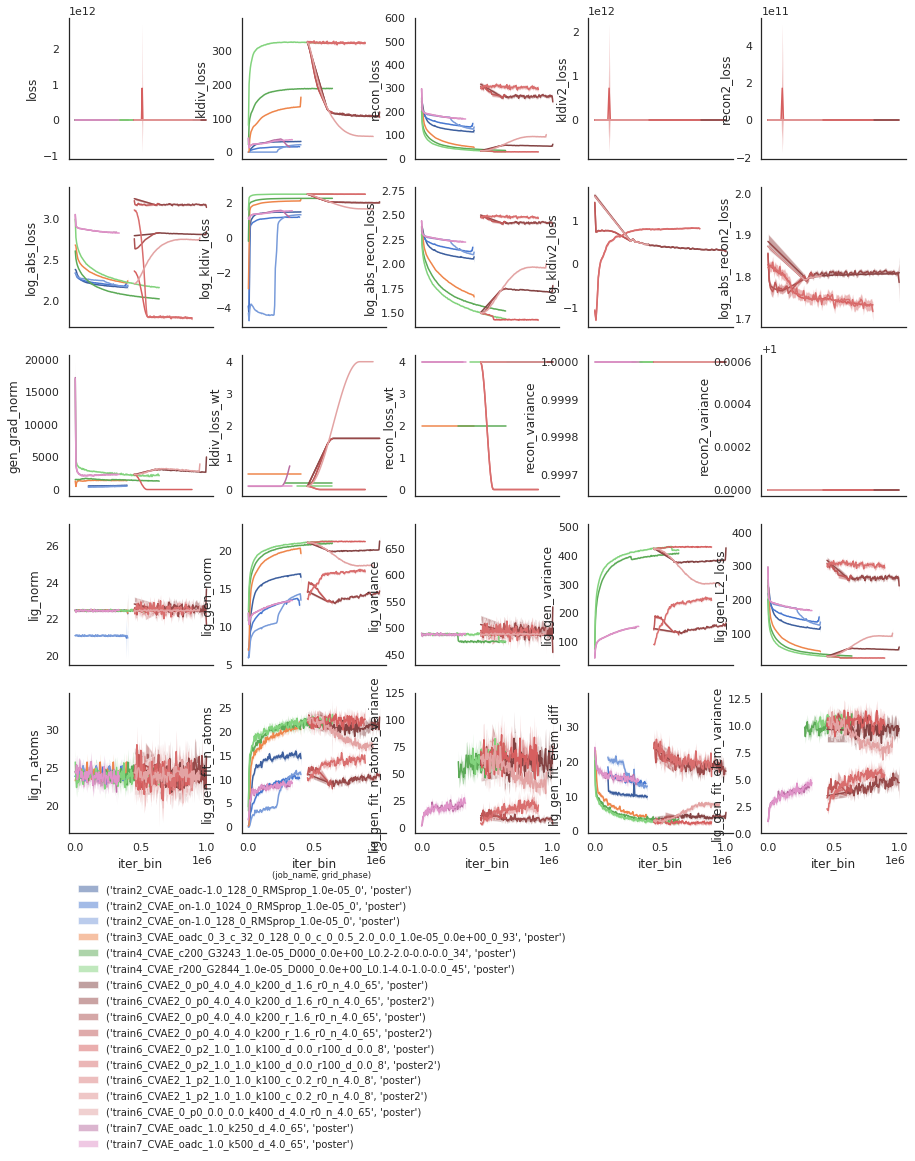

In [526]:
%%time

# plot path of training jobs through hyper param search space
hue = ['job_name', 'grid_phase']

fig = param_search.plot(
    plot_df[
        (
            plot_df['job_name'].isin([
                'train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0',
                'train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0',   # reduce latent space size, use receptor elements
                'train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0', # switch to acceptor/donor/charge atom typer
                'train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93', # < kldiv wt, > recon wt
                'train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34', # spectral norm, < kldiv wt, skip connect
                'train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45', # deeper/narrower, resnet, > recon wt, steric loss
                'train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65', # CVAE1- > kldiv wt w/ loss schedule, gradient clipping
                'train6_CVAE2_0_p0_4.0_4.0_k200_d_1.6_r0_n_4.0_65', # CVAE1 with decay schedule instead of cosine restart
                'train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8', # CVAE2- stage 2 VAE, learn recon variance
                'train6_CVAE2_0_p2_1.0_1.0_k100_d_0.0_r100_d_0.0_8', # CVAE2 but training only the stage 2 VAE
                'train6_CVAE_0_p0_0.0_0.0_k400_d_4.0_r0_n_4.0_65', # CVAE1 but decay kldiv wt to 4.0
                'train7_CVAE_oadc_1.0_k250_d_4.0_65',
                'train7_CVAE_oadc_1.0_k500_d_4.0_65',
            ])
        ) & 
        (
            (plot_df['model_type'] == 'CVAE2') |
            ~plot_df['grid_phase'].isin({'poster2', 'prior2', 'prior'})
        ) &
        (plot_df['log_abs_recon_loss'] < 3)
    ].sort_values([] + hue, ascending=True),
    x='iter_bin',
    y=train_y,
    hue=hue, 
    n_cols=5,
    width=3,
    height=3,
    plot_func=my_plot,
    plot_kws=dict(),
    ylim=dict(recon_loss=[0,600]),
    legend_kws=dict(
        fontsize='small',
        title_fontsize='x-small',
        bbox_to_anchor=[0,-0.2]
    ),
    legend_row=-1,
    legend_col=0,
    tight=False,
)
#fig.suptitle('Training VAEs', y=0.92)
for ext in ['png', 'pdf']:
    fig.savefig(f'plots/training_param_path.{ext}', dpi=400, bbox_inches='tight')

In [533]:
#colors = sns.color_palette('Blues', len(train_param_path))
colors = get_palette(n_hues=6, n_shades=[1,4,4,2], min_val=0.2, max_val=0.8)
sns.set_palette(colors)
colors

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.6505364195855016, 0.3819934866229796, 0.2333556434312955),
 (0.8400705213526654, 0.4755385278162142, 0.2714508285909216),
 (0.9350748931494625, 0.5644184535368749, 0.3563872264566993),
 (0.9392278434802318, 0.6665988080493924, 0.5142276563632476),
 (0.3131560011900274, 0.5609911716493092, 0.2980955585421718),
 (0.38187309926604784, 0.7211779395864744, 0.36113664540157975),
 (0.4678484473272788, 0.8152867576260312, 0.4466238875631494),
 (0.5922351671227958, 0.8517397950419515, 0.5765067928985027),
 (0.7035249873120009, 0.32508933547550056, 0.3250846598709011),
 (0.859323541689595, 0.47754118403460954, 0.47751843778883873)]

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)
/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/numpy/core/_methods.py:202: RuntimeWarning: invalid value encountered in subtract
  x = asanyarray(arr - arrmean)


CPU times: user 42.4 s, sys: 6.92 s, total: 49.3 s
Wall time: 49.3 s


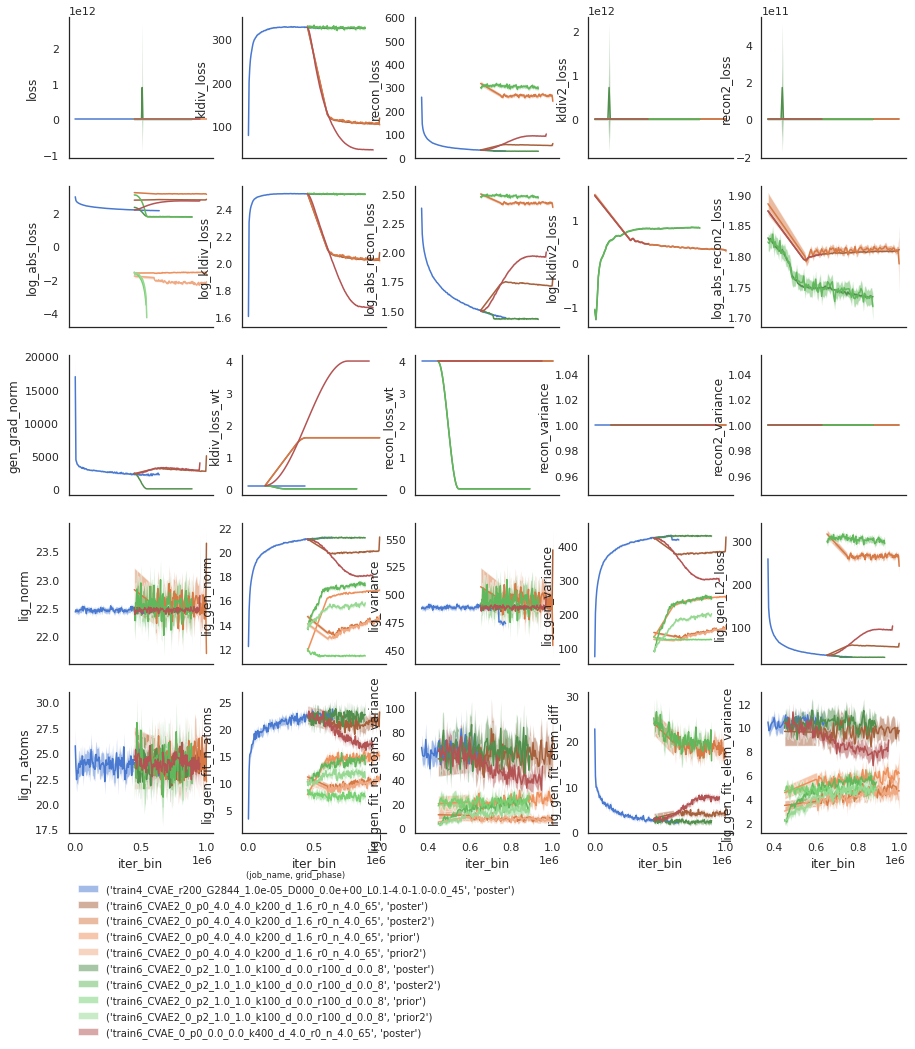

In [534]:
%%time

# plot path of training jobs through hyper param search space
hue = ['job_name', 'grid_phase']

fig = param_search.plot(
    plot_df[
        (
            plot_df['job_name'].isin([
                #'train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0',
                #'train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0',   # reduce latent space size, use receptor elements
                #'train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0', # switch to acceptor/donor/charge atom typer
                #'train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93', # < kldiv wt, > recon wt
                #'train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34', # spectral norm, < kldiv wt, skip connect
                'train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45', # deeper/narrower, resnet, > recon wt, steric loss
                #'train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65', # CVAE1- > kldiv wt w/ loss schedule, gradient clipping
                'train6_CVAE2_0_p0_4.0_4.0_k200_d_1.6_r0_n_4.0_65', # CVAE1 with decay schedule instead of cosine restart
                #'train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8', # CVAE2- stage 2 VAE, learn recon variance
                'train6_CVAE2_0_p2_1.0_1.0_k100_d_0.0_r100_d_0.0_8', # CVAE2 but training only the stage 2 VAE
                'train6_CVAE_0_p0_0.0_0.0_k400_d_4.0_r0_n_4.0_65', # CVAE1 but decay kldiv wt to 4.0
                #'train7_CVAE_oadc_1.0_k250_d_4.0_65',
                #'train7_CVAE_oadc_1.0_k500_d_4.0_65',
            ])
        ) & 
        (
            (plot_df['model_type'] == 'CVAE2') |
            ~plot_df['grid_phase'].isin({'poster2', 'prior2', 'prior'})
        ) &
        ~(plot_df['log_abs_recon_loss'] > 3)
    ].sort_values([] + hue, ascending=True),
    x='iter_bin',
    y=train_y,
    hue=hue, 
    n_cols=5,
    width=3,
    height=3,
    plot_func=my_plot,
    plot_kws=dict(),
    ylim=dict(recon_loss=[0,600]),
    legend_kws=dict(
        fontsize='small',
        title_fontsize='x-small',
        bbox_to_anchor=[0,-0.2]
    ),
    legend_row=-1,
    legend_col=0,
    tight=False,
)
#fig.suptitle('Training VAEs', y=0.92)
for ext in ['png', 'pdf']:
    fig.savefig(f'plots/train_best_models.{ext}', dpi=400, bbox_inches='tight')

In [546]:
#colors = sns.color_palette('Blues', len(train_param_path))
colors = get_palette(n_hues=2, n_shades=2, min_val=0.2, max_val=0.8)
sns.set_palette(colors)
colors

[(0.25353109348142877, 0.40468790890617456, 0.683691368100135),
 (0.4038522223246815, 0.5577364499973815, 0.8404139668720937),
 (0.7768924874302774, 0.4443568474184693, 0.25875243353771293),
 (0.9364815376163359, 0.599027928452405, 0.4098493075540786)]

CPU times: user 6.71 s, sys: 230 ms, total: 6.94 s
Wall time: 6.83 s


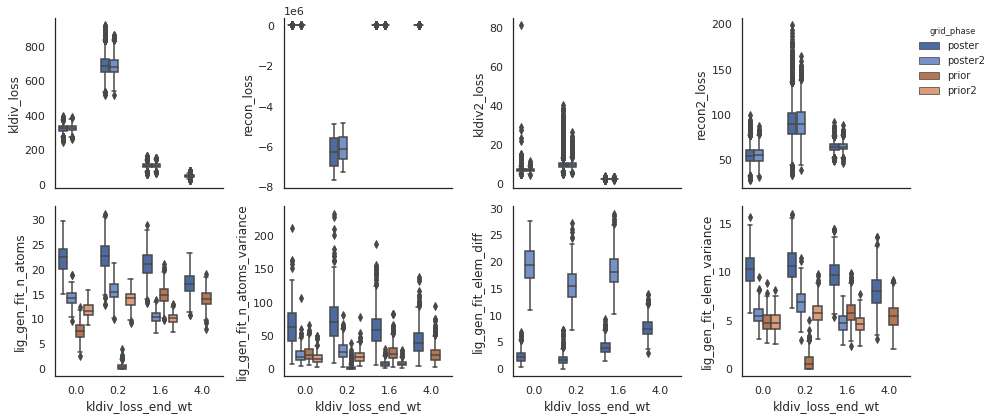

In [548]:
%%time

# plot last iterations of training best models as box plots
fig = param_search.plot(
    plot_df[
        plot_df['job_name'].isin([
            #'train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0',
            #'train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0',   # reduce latent space size, use receptor elements
            #'train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0', # switch to acceptor/donor/charge atom typer
            #'train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93', # < kldiv wt, > recon wt
            #'train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34', # spectral norm, < kldiv wt, skip connect
            #'train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45', # deeper/narrower, resnet, > recon wt, steric loss
            #'train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65', # CVAE1- > kldiv wt w/ loss schedule, gradient clipping
            'train6_CVAE2_0_p0_4.0_4.0_k200_d_1.6_r0_n_4.0_65', # CVAE1 with decay schedule instead of cosine restart
            'train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8', # CVAE2- stage 2 VAE, learn recon variance
            'train6_CVAE2_0_p2_1.0_1.0_k100_d_0.0_r100_d_0.0_8', # CVAE2 but training only the stage 2 VAE
            'train6_CVAE_0_p0_0.0_0.0_k400_d_4.0_r0_n_4.0_65', # CVAE1 but decay kldiv wt to 4.0
            #'train7_CVAE_oadc_1.0_k250_d_4.0_65',
            #'train7_CVAE_oadc_1.0_k500_d_4.0_65',
        ]) &
        (plot_df['iteration'] > 800000)
    ].sort_values('grid_phase'),
    x='kldiv_loss_end_wt',
    y=['kldiv_loss', 'recon_loss', 'kldiv2_loss', 'recon2_loss',
      'lig_gen_fit_n_atoms', 'lig_gen_fit_n_atoms_variance', 'lig_gen_fit_elem_diff', 'lig_gen_fit_elem_variance'],
    hue='grid_phase', 
    n_cols=4,
    width=3.5,
    height=3,
    plot_func=sns.boxplot,
    plot_kws=dict(),
    ylim=dict(),
    legend_kws=dict(
        fontsize='small',
        title_fontsize='x-small',
        bbox_to_anchor=[1,1]
    ),
    legend_row=0,
    legend_col=-1,
    tight=True,
)
#fig.suptitle('Training VAEs', y=0.92)
for ext in ['png', 'pdf']:
    fig.savefig(f'plots/train_best_models_bar_plots.{ext}', dpi=400, bbox_inches='tight')

In [65]:
train_param_path

['train2_CVAE_on-1.0_1024_0_RMSprop_1.0e-05_0',
 'train2_CVAE_on-1.0_128_0_RMSprop_1.0e-05_0',
 'train2_CVAE_oadc-1.0_128_0_RMSprop_1.0e-05_0',
 'train3_CVAE_oadc_0_3_c_32_0_128_0_0_c_0_0.5_2.0_0.0_1.0e-05_0.0e+00_0_93',
 'train4_CVAE_c200_G3243_1.0e-05_D000_0.0e+00_L0.2-2.0-0.0-0.0_34',
 'train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45',
 'train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65',
 'train6_CVAE2_0_p0_4.0_4.0_k200_d_1.6_r0_n_4.0_65',
 'train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8',
 'train6_CVAE2_0_p2_1.0_1.0_k100_d_0.0_r100_d_0.0_8',
 'train6_CVAE_0_p0_0.0_0.0_k400_d_4.0_r0_n_4.0_65']

In [744]:
with open('train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8/6988235.stdout') as f:
    lines = f.readlines()
with open('train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8/7017129.stdout') as f:
    lines += f.readlines()

rows = []
for line in lines:
    if line.startswith('[iteration'):
        index_str, value_str = line[1:].split(']')
        row = dict()
        for field in index_str.rstrip().split(' '):
            key, val = field.split('=')
            row[key] = val
        for field in value_str.strip().split(' '):
            key, val = field.split('=')
            row[key] = val
        rows.append(row)
        
stdout_df = pd.DataFrame(rows)
for c in stdout_df:
    try:
        stdout_df[c] = stdout_df[c].astype(float)
    except:
        pass

fig = param_search.plot(
    stdout_df[
    (stdout_df['data_phase'] == 'train') &
    (stdout_df['grid_phase'] == 'poster2') &
    True
    ],
    x='iteration',
    y=['recon2_log_var', 'lig_gen_fit_type_diff', 'lig_gen_fit_n_atoms'],
    plot_func=my_plot, n_cols=3, legend=False
)

AssertionError: empty data frame

In [864]:
fix_df = train_metrics[
    train_metrics['job_name'] == 'train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45'
][['iteration', 'disc_iter', 'data_phase', 'model_phase', 'grid_phase', 'batch', 'recon_loss', 'kldiv_loss', 'steric_loss', 'loss', 'lig_norm', 'lig_variance', 'lig_gen_norm', 'lig_gen_variance', 'lig_gen_L2_loss', 'lig_gen_fit_n_atoms', 'lig_gen_fit_radius', 'lig_n_atoms', 'lig_radius', 'lig_gen_fit_type_diff', 'lig_gen_fit_exact_types', 'lig_gen_fit_elem_diff', 'lig_gen_fit_exact_elems', 'lig_gen_fit_prop_diff', 'lig_gen_fit_exact_props', 'lig_gen_fit_atom_rmsd', 'forward_data_time', 'forward_gen_time', 'forward_disc_time', 'forward_fit_time', 'forward_metrics_time', 'memory', 'forward_time', 'forward_gpu', 'gen_grad_norm', 'backward_grad_time', 'backward_norm_time', 'backward_update_time', 'backward_time', 'backward_gpu', 'recon_loss_wt', 'recon_log_var', 'kldiv_loss_wt', 'steric_loss_wt', 'lig_gen_fit_n_atoms_variance', 'lig_gen_fit_type_variance', 'lig_gen_fit_elem_variance', 'lig_gen_fit_prop_variance', 'lig_n_atoms_variance', 'lig_type_variance', 'lig_elem_variance', 'lig_prop_variance']]

fix_df.to_csv('train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45/train4_CVAE_r200_G2844_1.0e-05_D000_0.0e+00_L0.1-4.0-1.0-0.0_45.train_metrics', sep=' ', index=False)

# 5. Test evaluations

Perform inference using trained generative models, using different sampling methods to generate novel molecules.

[Table of contents](#Table-of-contents)

In [3]:
gen_expt_dir = os.path.join(base_dir, 'generate')
os.chdir(gen_expt_dir)
os.getcwd()

'/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate'

In [4]:
np.random.seed(0)

# select 10 random test receptors from different pockets with at least 5 ligands
all_test_pockets = pd.read_csv('../../data/TEST_POCKETS', sep=' ', names=['pocket_name', 'data_name', 'n_examples', 'ligands'])
print(all_test_pockets['n_examples'].describe())

test_targets = all_test_pockets[
    (all_test_pockets['n_examples'] > 5)
].groupby('pocket_name').sample(1).sample(10)

test_targets.to_csv('SELECTED_TEST_TARGETS', sep=' ', header=False, index=False)
print(test_targets['n_examples'].sum())
print(len(set(sum((x.split(',') for x in test_targets['ligands']), []))))
test_targets


count    9115.000000
mean       11.576083
std        12.961100
min         1.000000
25%         3.000000
50%         6.000000
75%        16.000000
max        79.000000
Name: n_examples, dtype: float64
90
89


,pocket_name,data_name,n_examples,ligands
935,B4GT1_HUMAN_125_398_0,2ah9_B_rec,6,"bgn,udp,udh,cto,ud2,upg"
4471,KAT2B_HUMAN_715_831_0,5lvq_A_rec,14,"aly,5wv,5wz,2lx,5ws,5wu,2qc,..."
6137,PA2GA_HUMAN_21_144_0,5g3n_A_rec,8,"x28,oap,8in,6in,u8d,bhp,i3n,gel"
3613,G6PI_MOUSE_1_557_0,1u0f_A_rec,6,"g6p,6pg,s6p,der,f6p,a5p"
3279,FABG_PSEAE_1_247_0,4bnw_C_rec,13,"36k,nkh,36i,j2t,fxe,q7u,3x3,..."
2222,CP2B6_HUMAN_20_491_catalytic_0,4i91_A_rec,7,"cpz,85d,cae,sne,tmh,3v4,82s"
7373,PYGL_HUMAN_5_844_0,2ati_A_rec,7,"avf,ave,ihu,055,25d,mrd,avd"
4562,KHK_HUMAN_3_298_0,2hw1_A_rec,11,"tr4,lj9,a4j,tr2,anp,a4g,a3y,..."
4345,INHA_MYCTU_1_269_0,1bvr_C_rec,11,"xt5,tcu,3kx,3ky,2tk,i4i,uud,..."
803,AROK_MYCTU_1_176_0,1zyu_A_rec,7,"adp,skm,anp,acp,s3p,dhk,k2q"


In [5]:
# select and name the models to evaluate  

model_params = ( # these were evaluated first
    param_search.ParamSpace(
        model_name='CVAE',
        model_type='CVAE',
        prior_n_layers=0,
        train_job_name='train6_CVAE2_0_p0_4.0_4.0_k200_r_1.6_r0_n_4.0_65',
        train_iter=600000,
    ) + \
    param_search.ParamSpace(
        model_name='CVAE2',
        model_type='CVAE2',
        prior_n_layers=2,
        train_job_name='train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8',
        train_iter=730000,
    )
)
model_params = ( # these are the final evaluations
    param_search.ParamSpace(
        model_name='CVAE-4.0',
        model_type='CVAE',
        prior_n_layers=0,
        train_job_name='train6_CVAE_0_p0_0.0_0.0_k400_d_4.0_r0_n_4.0_65', # kldiv decay to 4.0 (CVAE only) trained to 1m
        train_iter=1000000,
    ) + \
    param_search.ParamSpace(
        model_name='CVAE-1.6',
        model_type='CVAE',
        prior_n_layers=0,
        train_job_name='train6_CVAE2_0_p0_4.0_4.0_k200_d_1.6_r0_n_4.0_65', # kldiv decay to 1.6 (CVAE1) trained to 1m
        train_iter=1000000,
    ) + \
    param_search.ParamSpace(
        model_name='CVAE-2S',
        model_type='CVAE2',
        prior_n_layers=2,
        train_job_name='train6_CVAE2_1_p2_1.0_1.0_k100_c_0.2_r0_n_4.0_8', # kldiv decay to 0.2 (CVAE2) trained to 1m
        train_iter=1000000,
    )
)
len(model_params)

3

In [6]:
for p in model_params:
    train_job_name = p['train_job_name']
    train_iter = p['train_iter']
    if not os.path.isfile(f'../training/{train_job_name}/{train_job_name}_iter_{train_iter}.gen_model_state'):
        print(train_job_name, train_iter, file=sys.stderr)

In [623]:
import param_search

# evaluate different sampling methods

base_params = param_search.ParamSpace(
    group_name='0',
    name_format='gen{group_name}_{model_name}_{data_name}_{prior}_{var_factor}_{post_factor}',
    random_seed=0,
    data_root=os.environ['CROSSDOCK_ROOT'],
    sbatch_line='#SBATCH -C M12|2080Ti',
    diff_cond_structs=False,
    diff_cond_transform=False,
    random_rotation=True,
    random_translation=2.0,
    interpolate=False,
    spherical=False,
)

sample_params = (
    param_search.ParamSpace( # posterior
        prior=0,
        var_factor=[0.25, 0.5, 1.0, 2.0, 4.0, 8.0],
        post_factor=1.0,
        truncate=False,
    ) + \
    param_search.ParamSpace( # prior
        prior=1,
        var_factor=[0.25, 0.5, 1.0, 2.0, 4.0, 8.0],
        post_factor=0.0,
        truncate=False,
    ) + \
    param_search.ParamSpace( # post/prior interp
        prior=0,
        var_factor=1.0,
        post_factor=[1.0, 0.8, 0.6, 0.4, 0.2, 0.0],
        truncate=False,
    )
)

d = []
for i, target in test_targets.iterrows():
    
    d.append(param_search.ParamSpace(
        pocket_name=target['pocket_name'],
        data_name=target['data_name'],
        n_examples=target['n_examples'],
        n_samples=100,
    ))
    
assert len(d) == 10
data_params = d[0] + d[1] + d[2] + d[3] + d[4] + d[5] + d[6] + d[7] + d[8] + d[9]

gen_sample_params = list(base_params * model_params * sample_params * data_params)

for p in gen_sample_params: # sample from stage2 prior when available
    p['stage2'] = (p['model_type'] == 'CVAE2' and p['prior'])

len(gen_params)

12

In [627]:
# receptor-conditionality/mutation analysis

base_params = param_search.ParamSpace(
    group_name='2',
    name_format='gen{group_name}_{model_name}_{data_name}_{diff_cond_transform}_{post_factor}',
    random_seed=0,
    sbatch_line='#SBATCH -C M12|2080Ti',
    diff_cond_structs=True,
    diff_cond_transform=[0,1],
    random_rotation=True,
    random_translation=2.0,
    interpolate=False,
    spherical=False,
)

sample_params = (
    param_search.ParamSpace( # posterior
        prior=0,
        var_factor=1.0,
        post_factor=[1.0, 0.0],
        truncate=False,
    ) + \
    param_search.ParamSpace( # prior
        prior=1,
        var_factor=1.0,
        post_factor=0.0,
        truncate=False,
    )
)

data_params = param_search.ParamSpace(
    data_root='/net/pulsar/home/koes/mtr22/gan/data/crossdock2020',
    pocket_name='AROK_MYCTU_1_176_0',
    data_name=[
        'fixed_input_1zyu_A_rec_mutants',
        'fixed_input_no_rec_mutants',
        'fixed_cond_1zyu_A_rec_mutants',
        'fixed_cond_no_rec_mutants',
    ],
    n_examples=25,
    n_samples=100,
)

gen_mutant_params = list(base_params * model_params * sample_params * data_params)

for p in gen_mutant_params:
    p['stage2'] = (p['model_type'] == 'CVAE2' and p['prior'])

len(gen_mutant_params)

72

In [628]:
# latent space interpolation

base_params = param_search.ParamSpace(
    group_name='3',
    name_format='gen{group_name}_{model_name}_{data_name}_{spherical}_{post_factor}',
    random_seed=0,
    sbatch_line='#SBATCH -C M12|2080Ti',
    random_rotation=False,
    random_translation=False,
    diff_cond_transform=False,
    diff_cond_structs=False,
    interpolate=True,
    spherical=[0,1],
)

sample_params = (
    param_search.ParamSpace( # posterior
        prior=0,
        var_factor=1.0,
        post_factor=1.0,
        truncate=False,
    ) + \
    param_search.ParamSpace( # prior
        prior=1,
        var_factor=1.0,
        post_factor=0.0,
        truncate=False,
    )
)

data_params = param_search.ParamSpace(
    data_root=os.environ['CROSSDOCK_ROOT'],
    pocket_name='AROK_MYCTU_1_176_0',
    data_name='1zyu_A_rec_interp',
    n_examples=7,
    n_samples=100,
)

gen_interp_params = list(model_params * sample_params * base_params * data_params)

for p in gen_interp_params:
    p['stage2'] = (p['model_type'] == 'CVAE2' and p['prior'])

len(gen_interp_params)

12

In [629]:
# estimate total evaluation time
n_sample_jobs = len(gen_sample_params)
n_mutant_jobs = len(gen_mutant_params)
n_interp_jobs = len(gen_interp_params)
n_total_jobs = n_sample_jobs + n_mutant_jobs + n_interp_jobs

n_examples = (n_sample_jobs*10 + n_mutant_jobs*25 + n_interp_jobs*7) / n_total_jobs
n_samples = (n_sample_jobs*100 + n_mutant_jobs*100 + n_interp_jobs*100)/ n_total_jobs
s_per_sample = 10

h_per_job = n_examples * n_samples * s_per_sample / 3600

n_gpus = 20
total_days = n_total_jobs * h_per_job/24 / n_gpus

h_per_job, total_days

(3.2425213675213675, 4.215277777777778)

In [630]:
gen_job_files = []

for gen_params in [gen_sample_params, gen_mutant_params, gen_interp_params]:

    param_search.setup(
        expt_dir=gen_expt_dir,
        name_format=next(iter(gen_params))['name_format'],
        template_file='generate.config',
        param_space=gen_params,
    )
    gen_job_files.append(param_search.setup(
        expt_dir=gen_expt_dir,
        name_format=next(iter(gen_params))['name_format'],
        template_file='generate.sh',
        param_space=gen_params,
    ))

gen_job_files

[['/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE-4.0_2ah9_B_rec_0_0.25_1.0/generate.sh',
  '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE-4.0_5lvq_A_rec_0_0.25_1.0/generate.sh',
  '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE-4.0_5g3n_A_rec_0_0.25_1.0/generate.sh',
  '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE-4.0_1u0f_A_rec_0_0.25_1.0/generate.sh',
  '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE-4.0_4bnw_C_rec_0_0.25_1.0/generate.sh',
  '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE-4.0_4i91_A_rec_0_0.25_1.0/generate.sh',
  '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE-4.0_2ati_A_rec_0_0.25_1.0/generate.sh',
  '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE-4.0_2hw1_A_rec_0_0.25_1.0/generate.sh',
  '/net/pulsar/home/koes/mtr22/gan/new_atom_typing/generate/gen0_CVAE-4.0_1bvr_C_rec_0_0.25_1.0/generate.sh',
  '/net/pu

In [632]:
for j in gen_job_files:
    print(param_search.submit(j))

[7090118, 7090119, 7090120, 7090121, 7090122, 7090123, 7090124, 7090125, 7090126, 7090127, 7090128, 7090129, 7090130, 7090131, 7090132, 7090133, 7090134, 7090135, 7090136, 7090137, 7090138, 7090139, 7090140, 7090141, 7090142, 7090143, 7090144, 7090145, 7090146, 7090147, 7090148, 7090149, 7090150, 7090151, 7090152, 7090153, 7090154, 7090155, 7090156, 7090157, 7090158, 7090159, 7090160, 7090161, 7090162, 7090163, 7090164, 7090165, 7090166, 7090167, 7090168, 7090169, 7090170, 7090171, 7090172, 7090173, 7090174, 7090175, 7090176, 7090177, 7090178, 7090179, 7090180, 7090181, 7090182, 7090183, 7090184, 7090185, 7090186, 7090187, 7090188, 7090189, 7090190, 7090191, 7090192, 7090193, 7090194, 7090195, 7090196, 7090197, 7090198, 7090199, 7090200, 7090201, 7090202, 7090203, 7090204, 7090205, 7090206, 7090207, 7090208, 7090209, 7090210, 7090211, 7090212, 7090213, 7090214, 7090215, 7090216, 7090217, 7090218, 7090219, 7090220, 7090221, 7090222, 7090223, 7090224, 7090225, 7090226, 7090227, 7090228, 

In [5]:
gen_jobs = pd.DataFrame(dict(
    job_id=[
        # first working gen0 submit
        [7023120, 7023121, 7023122, 7023123, 7023124, 7023125, 7023126, 7023127, 7023128, 7023129, 7023130, 7023131, 7023132, 7023133, 7023134, 7023135, 7023136, 7023137, 7023138, 7023139, 7023140, 7023141, 7023142, 7023143, 7023144, 7023145, 7023146, 7023147, 7023148, 7023149, 7023150, 7023151, 7023152, 7023153, 7023154, 7023155, 7023156, 7023157, 7023158, 7023159, 7023160, 7023161, 7023162, 7023163, 7023164, 7023165, 7023166, 7023167, 7023168, 7023169, 7023170, 7023171, 7023172, 7023173, 7023174, 7023175, 7023176, 7023177, 7023178, 7023179, 7023180, 7023181, 7023182, 7023183, 7023184, 7023185, 7023186, 7023187, 7023188, 7023189, 7023190, 7023191, 7023192, 7023193, 7023194, 7023195, 7023196, 7023197, 7023198, 7023199, 7023200, 7023201, 7023202, 7023203, 7023204, 7023205, 7023206, 7023207, 7023208, 7023209, 7023210, 7023211, 7023212, 7023213, 7023214, 7023215, 7023216, 7023217, 7023218, 7023219, 7023220, 7023221, 7023222, 7023223, 7023224, 7023225, 7023226, 7023227, 7023228, 7023229, 7023230, 7023231, 7023232, 7023233, 7023234, 7023235, 7023236, 7023237, 7023238, 7023239, 7023240, 7023241, 7023242, 7023243, 7023244, 7023245, 7023246, 7023247, 7023248, 7023249, 7023250, 7023251, 7023252, 7023253, 7023254, 7023255, 7023256, 7023257, 7023258, 7023259, 7023260, 7023261, 7023262, 7023263, 7023264, 7023265, 7023266, 7023267, 7023268, 7023269, 7023270, 7023271, 7023272, 7023273, 7023274, 7023275, 7023276, 7023277, 7023278, 7023279, 7023280, 7023281, 7023282, 7023283, 7023284, 7023285, 7023286, 7023287, 7023288, 7023289, 7023290, 7023291, 7023292, 7023293, 7023294, 7023295, 7023296, 7023297, 7023298, 7023299, 7023300, 7023301, 7023302, 7023303, 7023304, 7023305, 7023306, 7023307, 7023308, 7023309, 7023310, 7023311, 7023312, 7023313, 7023314, 7023315, 7023316, 7023317, 7023318, 7023319, 7023320, 7023321, 7023322, 7023323, 7023324, 7023325, 7023326, 7023327, 7023328, 7023329, 7023330, 7023331, 7023332, 7023333, 7023334, 7023335, 7023336, 7023337, 7023338, 7023339, 7023340, 7023341, 7023342, 7023343, 7023344, 7023345, 7023346, 7023347, 7023348, 7023349, 7023350, 7023351, 7023352, 7023353, 7023354, 7023355, 7023356, 7023357, 7023358, 7023359],
        # resubmit gen0 error jobs
        [7023396, 7023397, 7023398, 7023399, 7023400, 7023401, 7023402, 7023403, 7023404, 7023405, 7023406, 7023407, 7023408, 7023409, 7023410, 7023411, 7023412, 7023413, 7023414, 7023415, 7023416, 7023417, 7023418, 7023419, 7023420, 7023421, 7023422, 7023423, 7023424, 7023425, 7023426, 7023427, 7023428, 7023429, 7023430, 7023431, 7023432, 7023433, 7023434, 7023435, 7023436, 7023437, 7023438, 7023439, 7023440, 7023441, 7023442, 7023443, 7023444, 7023445, 7023446, 7023447, 7023448, 7023449, 7023450, 7023451, 7023452, 7023453, 7023454, 7023455, 7023456, 7023457, 7023458, 7023459, 7023460, 7023461, 7023462, 7023463, 7023464, 7023465, 7023466, 7023467, 7023468, 7023469, 7023470, 7023471, 7023472, 7023473, 7023474, 7023475, 7023476, 7023477, 7023478, 7023479, 7023480, 7023481, 7023482, 7023483, 7023484, 7023485, 7023486, 7023487, 7023488, 7023489, 7023490, 7023491, 7023492, 7023493, 7023494, 7023495, 7023496, 7023497],
        # resubmit more error jobs (cancelled redundant)
        [7023506, 7023507, 7023508, 7023509, 7023510, 7023511, 7023512, 7023513, 7023514, 7023515, 7023516, 7023517, 7023518, 7023519, 7023520, 7023521, 7023522, 7023523, 7023524, 7023525, 7023526, 7023527, 7023528, 7023529, 7023530, 7023531, 7023532, 7023533, 7023534, 7023535, 7023536, 7023537, 7023538, 7023539, 7023540, 7023541, 7023542, 7023543, 7023544, 7023545, 7023546, 7023547, 7023548, 7023549, 7023550, 7023551, 7023552, 7023553, 7023554, 7023555, 7023556, 7023557, 7023558, 7023559, 7023560, 7023561, 7023562, 7023563, 7023564, 7023565, 7023566, 7023567, 7023568, 7023569, 7023570, 7023571, 7023572, 7023573, 7023574, 7023575, 7023576, 7023577, 7023578, 7023579, 7023580, 7023581, 7023582, 7023583, 7023584, 7023585, 7023586, 7023587, 7023588, 7023589, 7023590, 7023591, 7023592, 7023593, 7023594, 7023595, 7023596, 7023597, 7023598, 7023599, 7023600, 7023601, 7023602, 7023603, 7023604, 7023605, 7023606, 7023607],
        # fix post_factor bug and resubmit affected jobs
        [7023617, 7023618, 7023619, 7023620, 7023621, 7023622, 7023623, 7023624, 7023625, 7023626, 7023627, 7023628, 7023629, 7023630, 7023631, 7023632, 7023633, 7023634, 7023635, 7023636, 7023637, 7023638, 7023639, 7023640, 7023641, 7023642, 7023643, 7023644, 7023645, 7023646, 7023647, 7023648, 7023649, 7023650, 7023651, 7023652, 7023653, 7023654, 7023655, 7023656, 7023657, 7023658, 7023659, 7023660, 7023661, 7023662, 7023663, 7023664, 7023665, 7023666, 7023667, 7023668, 7023669, 7023670, 7023671, 7023672, 7023673, 7023674, 7023675, 7023676, 7023677, 7023678, 7023679, 7023680, 7023681, 7023682, 7023683, 7023684, 7023685, 7023686, 7023687, 7023688, 7023689, 7023690, 7023691, 7023692, 7023693, 7023694, 7023695, 7023696],
        # resubmit remaining minimizedAffinity key error jobs (were launched before the fix)
        [7023776, 7023777, 7023778, 7023779, 7023780, 7023781, 7023782, 7023783, 7023784, 7023785, 7023786, 7023787, 7023788, 7023789, 7023790, 7023791, 7023792, 7023793, 7023794],
        # extend param ranges of var_factor and post_factor
        [7024330, 7024331, 7024332, 7024333, 7024334, 7024335, 7024336, 7024337, 7024338, 7024339, 7024340, 7024341, 7024342, 7024343, 7024344, 7024345, 7024346, 7024347, 7024348, 7024349, 7024350, 7024351, 7024352, 7024353, 7024354, 7024355, 7024356, 7024357, 7024358, 7024359, 7024360, 7024361, 7024362, 7024363, 7024364, 7024365, 7024366, 7024367, 7024368, 7024369, 7024370, 7024371, 7024372, 7024373, 7024374, 7024375, 7024376, 7024377, 7024378, 7024379, 7024380, 7024381, 7024382, 7024383, 7024384, 7024385, 7024386, 7024387, 7024388, 7024389, 7024390, 7024391, 7024392, 7024393, 7024394, 7024395, 7024396, 7024397, 7024398, 7024399, 7024400, 7024401, 7024402, 7024403, 7024404, 7024405, 7024406, 7024407, 7024408, 7024409, 7024410, 7024411, 7024412, 7024413, 7024414, 7024415, 7024416, 7024417, 7024418, 7024419, 7024420, 7024421, 7024422, 7024423, 7024424, 7024425, 7024426, 7024427, 7024428, 7024429, 7024430, 7024431, 7024432, 7024433, 7024434, 7024435, 7024436, 7024437, 7024438, 7024439, 7024440, 7024441, 7024442, 7024443, 7024444, 7024445, 7024446, 7024447, 7024448, 7024449],
        # extend post_factor even further to 2.0
        [7063809, 7063810, 7063811, 7063812, 7063813, 7063814, 7063815, 7063816, 7063817, 7063818, 7063819, 7063820, 7063821, 7063822, 7063823, 7063824, 7063825, 7063826, 7063827, 7063828, 7063829, 7063830, 7063831, 7063832, 7063833, 7063834, 7063835, 7063836, 7063837, 7063838, 7063839, 7063840, 7063841, 7063842, 7063843, 7063844, 7063845, 7063846, 7063847, 7063848, 7063849, 7063850, 7063851, 7063852, 7063853, 7063854, 7063855, 7063856, 7063857, 7063858, 7063859, 7063860, 7063861, 7063862, 7063863, 7063864, 7063865, 7063866, 7063867, 7063868, 7063869, 7063870, 7063871, 7063872, 7063873, 7063874, 7063875, 7063876, 7063877, 7063878, 7063879, 7063880, 7063881, 7063882, 7063883, 7063884, 7063885, 7063886, 7063887, 7063888],
        # gen1- receptor conditionality on mutants analysis
        [7068712, 7068713, 7068714, 7068715, 7068716, 7068717, 7068718, 7068719, 7068720, 7068721, 7068722, 7068723, 7068724, 7068725, 7068726, 7068727, 7068728, 7068729, 7068730, 7068731, 7068732, 7068733, 7068734, 7068735, 7068736, 7068737, 7068738, 7068739, 7068740, 7068741, 7068742, 7068743, 7068744, 7068745, 7068746, 7068747, 7068748, 7068749, 7068750, 7068751, 7068752, 7068753, 7068754, 7068755, 7068756, 7068757, 7068758, 7068759],
        # gen1- submit again with more mutations and bug fix for fixed condition
        [7082198, 7082199, 7082200, 7082201, 7082202, 7082203, 7082204, 7082205, 7082206, 7082207, 7082208, 7082209, 7082210, 7082211, 7082212, 7082213, 7082214, 7082215, 7082216, 7082217, 7082218, 7082219, 7082220, 7082221, 7082222, 7082223, 7082224, 7082225, 7082226, 7082227, 7082228, 7082229, 7082230, 7082231, 7082232, 7082233, 7082234, 7082235, 7082236, 7082237, 7082238, 7082239, 7082240, 7082241, 7082242, 7082243, 7082244, 7082245],
        # gen1- submit again with n_examples=27, last submit still only did first 5
        [7082259, 7082260, 7082261, 7082262, 7082263, 7082264, 7082265, 7082266, 7082267, 7082268, 7082269, 7082270, 7082271, 7082272, 7082273, 7082274, 7082275, 7082276, 7082277, 7082278, 7082279, 7082280, 7082281, 7082282, 7082283, 7082284, 7082285, 7082286, 7082287, 7082288, 7082289, 7082290, 7082291, 7082292, 7082293, 7082294, 7082295, 7082296, 7082297, 7082298, 7082299, 7082300, 7082301, 7082302, 7082303, 7082304, 7082305, 7082306],
        # gen1 - submit with hopefully fixed receptor conditionality
        [7082381, 7082382, 7082383, 7082384, 7082385, 7082386, 7082387, 7082388, 7082389, 7082390, 7082391, 7082392, 7082393, 7082394, 7082395, 7082396, 7082397, 7082398, 7082399, 7082400, 7082401, 7082402, 7082403, 7082404, 7082405, 7082406, 7082407, 7082408, 7082409, 7082410, 7082411, 7082412, 7082413, 7082414, 7082415, 7082416, 7082417, 7082418, 7082419, 7082420, 7082421, 7082422, 7082423, 7082424, 7082425, 7082426, 7082427, 7082428],
        # gen2 - receptor conditionality using data files
        [7082640, 7082641, 7082642, 7082643, 7082644, 7082645, 7082646, 7082647, 7082648, 7082649, 7082650, 7082651, 7082652, 7082653, 7082654, 7082655, 7082656, 7082657, 7082658, 7082659, 7082660, 7082661, 7082662, 7082663, 7082664, 7082665, 7082666, 7082667, 7082668, 7082669, 7082670, 7082671, 7082672, 7082673, 7082674, 7082675, 7082676, 7082677, 7082678, 7082679, 7082680, 7082681, 7082682, 7082683, 7082684, 7082685, 7082686, 7082687, 7082688, 7082689, 7082690, 7082691, 7082692, 7082693, 7082694, 7082695, 7082696, 7082697, 7082698, 7082699, 7082700, 7082701, 7082702, 7082703, 7082704, 7082705, 7082706, 7082707, 7082708, 7082709, 7082710, 7082711, 7082712, 7082713, 7082714, 7082715, 7082716, 7082717, 7082718, 7082719, 7082720, 7082721, 7082722, 7082723, 7082724, 7082725, 7082726, 7082727, 7082728, 7082729, 7082730, 7082731, 7082732, 7082733, 7082734, 7082735, 7082736, 7082737, 7082738, 7082739, 7082740, 7082741, 7082742, 7082743, 7082744, 7082745, 7082746, 7082747, 7082748, 7082749, 7082750, 7082751, 7082752, 7082753, 7082754, 7082755, 7082756, 7082757, 7082758, 7082759, 7082760, 7082761, 7082762, 7082763, 7082764, 7082765, 7082766, 7082767, 7082768, 7082769, 7082770, 7082771, 7082772, 7082773, 7082774, 7082775, 7082776, 7082777, 7082778, 7082779, 7082780, 7082781, 7082782, 7082783, 7082784, 7082785, 7082786, 7082787, 7082788, 7082789, 7082790, 7082791, 7082792, 7082793, 7082794, 7082795, 7082796, 7082797, 7082798, 7082799, 7082800, 7082801, 7082802, 7082803, 7082804, 7082805, 7082806, 7082807, 7082808, 7082809, 7082810, 7082811, 7082812, 7082813, 7082814, 7082815, 7082816, 7082817, 7082818, 7082819, 7082820, 7082821, 7082822, 7082823, 7082824, 7082825, 7082826, 7082827, 7082828, 7082829, 7082830, 7082831],
        # gen2 - resubmit diff_cond_transform, wasn't getting passed in
        [7083036, 7083037, 7083038, 7083039, 7083040, 7083041, 7083042, 7083043, 7083044, 7083045, 7083046, 7083047, 7083048, 7083049, 7083050, 7083051, 7083052, 7083053, 7083054, 7083055, 7083056, 7083057, 7083058, 7083059, 7083060, 7083061, 7083062, 7083063, 7083064, 7083065, 7083066, 7083067, 7083068, 7083069, 7083070, 7083071, 7083072, 7083073, 7083074, 7083075, 7083076, 7083077, 7083078, 7083079, 7083080, 7083081, 7083082, 7083083],
        # gen3- latent interpolation
        [7083127, 7083128, 7083129, 7083130,7083131, 7083132, 7083133, 7083134],
        # gen2 - resubmit error jobs (failed while I was implementing latent interp)
        [7083135, 7083136, 7083137, 7083138, 7083139, 7083140, 7083141, 7083142, 7083143, 7083144, 7083145, 7083146, 7083147, 7083148, 7083149, 7083150, 7083151, 7083152, 7083153, 7083154, 7083155, 7083156, 7083157, 7083158, 7083159, 7083160, 7083161, 7083162],

        # gen0, gen2, gen3- final evaluations
        [7090118, 7090119, 7090120, 7090121, 7090122, 7090123, 7090124, 7090125, 7090126, 7090127, 7090128, 7090129, 7090130, 7090131, 7090132, 7090133, 7090134, 7090135, 7090136, 7090137, 7090138, 7090139, 7090140, 7090141, 7090142, 7090143, 7090144, 7090145, 7090146, 7090147, 7090148, 7090149, 7090150, 7090151, 7090152, 7090153, 7090154, 7090155, 7090156, 7090157, 7090158, 7090159, 7090160, 7090161, 7090162, 7090163, 7090164, 7090165, 7090166, 7090167, 7090168, 7090169, 7090170, 7090171, 7090172, 7090173, 7090174, 7090175, 7090176, 7090177, 7090178, 7090179, 7090180, 7090181, 7090182, 7090183, 7090184, 7090185, 7090186, 7090187, 7090188, 7090189, 7090190, 7090191, 7090192, 7090193, 7090194, 7090195, 7090196, 7090197, 7090198, 7090199, 7090200, 7090201, 7090202, 7090203, 7090204, 7090205, 7090206, 7090207, 7090208, 7090209, 7090210, 7090211, 7090212, 7090213, 7090214, 7090215, 7090216, 7090217, 7090218, 7090219, 7090220, 7090221, 7090222, 7090223, 7090224, 7090225, 7090226, 7090227, 7090228, 7090229, 7090230, 7090231, 7090232, 7090233, 7090234, 7090235, 7090236, 7090237, 7090238, 7090239, 7090240, 7090241, 7090242, 7090243, 7090244, 7090245, 7090246, 7090247, 7090248, 7090249, 7090250, 7090251, 7090252, 7090253, 7090254, 7090255, 7090256, 7090257, 7090258, 7090259, 7090260, 7090261, 7090262, 7090263, 7090264, 7090265, 7090266, 7090267, 7090268, 7090269, 7090270, 7090271, 7090272, 7090273, 7090274, 7090275, 7090276, 7090277, 7090278, 7090279, 7090280, 7090281, 7090282, 7090283, 7090284, 7090285, 7090286, 7090287, 7090288, 7090289, 7090290, 7090291, 7090292, 7090293, 7090294, 7090295, 7090296, 7090297, 7090298, 7090299, 7090300, 7090301, 7090302, 7090303, 7090304, 7090305, 7090306, 7090307, 7090308, 7090309, 7090310, 7090311, 7090312, 7090313, 7090314, 7090315, 7090316, 7090317, 7090318, 7090319, 7090320, 7090321, 7090322, 7090323, 7090324, 7090325, 7090326, 7090327, 7090328, 7090329, 7090330, 7090331, 7090332, 7090333, 7090334, 7090335, 7090336, 7090337, 7090338, 7090339, 7090340, 7090341, 7090342, 7090343, 7090344, 7090345, 7090346, 7090347, 7090348, 7090349, 7090350, 7090351, 7090352, 7090353, 7090354, 7090355, 7090356, 7090357, 7090358, 7090359, 7090360, 7090361, 7090362, 7090363, 7090364, 7090365, 7090366, 7090367, 7090368, 7090369, 7090370, 7090371, 7090372, 7090373, 7090374, 7090375, 7090376, 7090377, 7090378, 7090379, 7090380, 7090381, 7090382, 7090383, 7090384, 7090385, 7090386, 7090387, 7090388, 7090389, 7090390, 7090391, 7090392, 7090393, 7090394, 7090395, 7090396, 7090397, 7090398, 7090399, 7090400, 7090401, 7090402, 7090403, 7090404, 7090405, 7090406, 7090407, 7090408, 7090409, 7090410, 7090411, 7090412, 7090413, 7090414, 7090415, 7090416, 7090417, 7090418, 7090419, 7090420, 7090421, 7090422, 7090423, 7090424, 7090425, 7090426, 7090427, 7090428, 7090429, 7090430, 7090431, 7090432, 7090433, 7090434, 7090435, 7090436, 7090437, 7090438, 7090439, 7090440, 7090441, 7090442, 7090443, 7090444, 7090445, 7090446, 7090447, 7090448, 7090449, 7090450, 7090451, 7090452, 7090453, 7090454, 7090455, 7090456, 7090457, 7090458, 7090459, 7090460, 7090461, 7090462, 7090463, 7090464, 7090465, 7090466, 7090467, 7090468, 7090469, 7090470, 7090471, 7090472, 7090473, 7090474, 7090475, 7090476, 7090477, 7090478, 7090479, 7090480, 7090481, 7090482, 7090483, 7090484, 7090485, 7090486, 7090487, 7090488, 7090489, 7090490, 7090491, 7090492, 7090493, 7090494, 7090495, 7090496, 7090497, 7090498, 7090499, 7090500, 7090501, 7090502, 7090503, 7090504, 7090505, 7090506, 7090507, 7090508, 7090509, 7090510, 7090511, 7090512, 7090513, 7090514, 7090515, 7090516, 7090517, 7090518, 7090519, 7090520, 7090521, 7090522, 7090523, 7090524, 7090525, 7090526, 7090527, 7090528, 7090529, 7090530, 7090531, 7090532, 7090533, 7090534, 7090535, 7090536, 7090537, 7090538, 7090539, 7090540, 7090541, 7090542, 7090543, 7090544, 7090545, 7090546, 7090547, 7090548, 7090549, 7090550, 7090551, 7090552, 7090553, 7090554, 7090555, 7090556, 7090557, 7090558, 7090559, 7090560, 7090561, 7090562, 7090563, 7090564, 7090565, 7090566, 7090567, 7090568, 7090569, 7090570, 7090571, 7090572, 7090573, 7090574, 7090575, 7090576, 7090577, 7090578, 7090579, 7090580, 7090581, 7090582, 7090583, 7090584, 7090585, 7090586, 7090587, 7090588, 7090589, 7090590, 7090591, 7090592, 7090593, 7090594, 7090595, 7090596, 7090597, 7090598, 7090599, 7090600, 7090601, 7090602, 7090603, 7090604, 7090605, 7090606, 7090607, 7090608, 7090609, 7090610, 7090611, 7090612, 7090613, 7090614, 7090615, 7090616, 7090617, 7090618, 7090619, 7090620, 7090621, 7090622, 7090623, 7090624, 7090625, 7090626, 7090627, 7090628, 7090629, 7090630, 7090631, 7090632, 7090633, 7090634, 7090635, 7090636, 7090637, 7090638, 7090639, 7090640, 7090641, 7090642, 7090643, 7090644, 7090645, 7090646, 7090647, 7090648, 7090649, 7090650, 7090651, 7090652, 7090653, 7090654, 7090655, 7090656, 7090657],
        [7090658, 7090659, 7090660, 7090661, 7090662, 7090663, 7090664, 7090665, 7090666, 7090667, 7090668, 7090669, 7090670, 7090671, 7090672, 7090673, 7090674, 7090675, 7090676, 7090677, 7090678, 7090679, 7090680, 7090681, 7090682, 7090683, 7090684, 7090685, 7090686, 7090687, 7090688, 7090689, 7090690, 7090691, 7090692, 7090693, 7090694, 7090695, 7090696, 7090697, 7090698, 7090699, 7090700, 7090701, 7090702, 7090703, 7090704, 7090705, 7090706, 7090707, 7090708, 7090709, 7090710, 7090711, 7090712, 7090713, 7090714, 7090715, 7090716, 7090717, 7090718, 7090719, 7090720, 7090721, 7090722, 7090723, 7090724, 7090725, 7090726, 7090727, 7090728, 7090729],
        [7090730, 7090731, 7090732, 7090733, 7090734, 7090735, 7090736, 7090737, 7090738, 7090739, 7090740, 7090741],
    ],
    group_name=[0,0,0,0,0,0,0,1,1,1,1,2,2,3,2,0,2,3]
)).explode('job_id')

gen_jobs = gen_jobs[gen_jobs['group_name'] != 1]

In [6]:
%%time
import param_search

def find_work_dir(x):
    if 'work_dir' in x and not pd.isnull(x['work_dir']):
        return x['work_dir']
    return work_dir_map[x['job_id']]

print('Getting queue status')
qstat = param_search.status(job=gen_jobs.job_id)

print('Merging data frames')
gen_jobs = gen_jobs.merge(qstat, on='job_id', how='left')

print('Finding work dirs')
work_dir_map = find_work_dirs()
gen_jobs['work_dir'] = gen_jobs.apply(find_work_dir, axis=1)

print('Getting job names and files')
gen_jobs['job_name'] = gen_jobs['work_dir'].map(catch_exc(os.path.basename, TypeError))
gen_jobs['job_file'] = gen_jobs.apply(lambda x: '{work_dir}/generate.sh'.format(**x), axis=1)
gen_jobs['stdout_file'] = gen_jobs.apply(lambda x: '{work_dir}/{job_id}.stdout'.format(**x), axis=1)
gen_jobs['stderr_file'] = gen_jobs.apply(lambda x: '{work_dir}/{job_id}.stderr'.format(**x), axis=1)
gen_jobs['metrics_file'] = gen_jobs.apply(lambda x: '{work_dir}/{job_name}.gen_metrics'.format(**x), axis=1)

Getting queue status
Merging data frames
Finding work dirs
Getting job names and files
CPU times: user 414 ms, sys: 89.5 ms, total: 504 ms
Wall time: 769 ms


In [7]:
%%time

print('Reading stdout files')
gen_jobs['stdout'] = gen_jobs['stdout_file'].apply(
    catch_exc(param_search.job_output.read_stdout_file, FileNotFoundError),
    output_pat=r'^(\[example_idx=\d+ .+\].*)'
)
print()

print('Reading stderr files')
gen_jobs['stderr'] = gen_jobs['stderr_file'].apply(
    catch_exc(param_search.job_output.read_stderr_file, FileNotFoundError),
    break_pat='^==============================',
    error_pat=r'^(.*(Error|Exception|error|fault|failed|Errno|Killed).*)$'
) #
print()
gen_jobs['job_state'] = gen_jobs.apply(find_job_state, axis=1)

# make the order that job_names appear explicit so we can use it
#   to easily view different job_ids associated with each job_name
job_name_idx = {j:i for i, j in enumerate(gen_jobs['job_name'].unique())}
gen_jobs['job_name_idx'] = gen_jobs['job_name'].map(job_name_idx)

Reading stdout files
...................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

In [8]:
# read in generative evaluation params
gen_params = gen_jobs[
    ~gen_jobs['work_dir'].isnull()
].groupby(['job_name']).last()['job_file'].apply(
    param_search.params.read_params, line_start='# '
)
gen_params = pd.DataFrame(gen_params.tolist()).set_index('job_name')
gen_params['group_name'] = gen_params['group_name'].astype(int)
gen_jobs = gen_jobs.merge(gen_params, on=['group_name', 'job_name'])

In [9]:
pd.set_option('display.max_rows', 524)

data_n_examples = test_targets.set_index('data_name')['n_examples']
data_n_examples.loc['fixed_input_1zyu_A_rec_mutants'] = 25
data_n_examples.loc['fixed_input_no_rec_mutants'] = 25
data_n_examples.loc['fixed_cond_1zyu_A_rec_mutants'] = 25
data_n_examples.loc['fixed_cond_no_rec_mutants'] = 25
data_n_examples.loc['1zyu_A_rec_interp'] = 7

has = lambda x: not pd.isnull(x)

gen_jobs['n_examples'] = gen_jobs['data_name'].map(
    lambda x: data_n_examples[x] if has(x) else x
)
gen_jobs['example_idx'] = gen_jobs['stdout'].map(
    lambda x: int(re.match(r'^\[example_idx=(\d+) ', x).group(1)) if has(x) else x
)
gen_jobs['sample_idx'] = gen_jobs['stdout'].map(
    lambda x: int(re.match(r'^\[example_idx=\d+ sample_idx=(\d+) ', x).group(1)) if has(x) else np.nan
)
gen_jobs['pct_done'] = (gen_jobs['example_idx']*100 + gen_jobs['sample_idx'])/(gen_jobs['n_examples']*100-1)

gen_jobs['t_left'] = gen_jobs['runtime'].map(as_timedelta) / gen_jobs['pct_done'] * (1-gen_jobs['pct_done'])
#gen_jobs['t_left'] = gen_jobs['t_left'].map(lambda x: x.total_seconds() / 3600 if has(x) else x)

running_jobs = (gen_jobs.groupby('job_name')['job_state'].last() == 'R')
running_jobs = running_jobs[running_jobs] # drop non-running jobs

gen_jobs[
    #(gen_jobs['group_name'] == 2) &
    (~gen_jobs['job_name'].isnull()) &
    #gen_jobs['job_name'].isin(running_jobs.index) &
    True
].set_index(['group_name', 'job_name', 'job_id']).sort_values(['job_name_idx','job_id'])[
    ['queue', 'job_state', 'runtime',
     'n_examples', 'pct_done', 't_left',
     'stdout', 'stderr']
]

queue job_state  runtime  n_examples  pct_done  t_left                           stdout stderr
group_name job_name                         job_id                                                                                                 
0          gen0_CVAE_2ah9_B_rec_0_1.0_1.0   7023120    NaN        OK      NaN           6       1.0     NaN  [example_idx=5 sample_idx=99...   None
           gen0_CVAE_5lvq_A_rec_0_1.0_1.0   7023121    NaN        OK      NaN          14       1.0     NaN  [example_idx=13 sample_idx=9...   None
           gen0_CVAE_5g3n_A_rec_0_1.0_1.0   7023122    NaN        OK      NaN           8       1.0     NaN  [example_idx=7 sample_idx=99...   None
           gen0_CVAE_1u0f_A_rec_0_1.0_1.0   7023123    NaN        OK      NaN           6       1.0     NaN  [example_idx=5 sample_idx=99...   None
           gen0_CVAE_4bnw_C_rec_0_1.0_1.0   7023124    NaN        OK      NaN          13       1.0     NaN  [example_idx=12 sample_idx=9...   None
...                                                    ...       ...      ...         ...       ...     ...                              ...    ...
3          gen3_CVAE-1.6_1zyu_A_rec_inte... 7090737    NaN        OK      NaN           7       1.0     NaN  [example_idx=6 sample_idx=99...   None
           gen3_CVAE-2S_1zyu_A_rec_inter... 7090738    NaN        OK      NaN           7       1.0     NaN  [example_idx=6 sample_idx=99...   None
           gen3_CVAE-2S_1zyu_A_rec_inter... 7090739    NaN        OK      NaN           7       1.0     NaN  [example_idx=6 sample_idx=99...   None
           gen3_CVAE-2S_1zyu_A_rec_inter... 7090740    NaN        OK      NaN           7       1.0     NaN  [example_idx=6 sample_idx=99...   None
           gen3_CVAE-2S_1zyu_A_rec_inter... 7090741    NaN        OK      NaN           7       1.0     NaN  [example_idx=6 sample_idx=99...   None

[1456 rows x 8 columns]

In [50]:
# resubmit jobs whose latest submission errored out
error_jobs = (gen_jobs.groupby('job_name')['job_state'].last() == 'ERR')
error_jobs = error_jobs[error_jobs ] # drop non-error jobs

error_jobs = gen_jobs[
    gen_jobs['job_name'].isin(error_jobs.index)
]
error_jobs[['job_name', 'job_id', 'stderr']] #job_ids = param_search.submit(error_jobs['job_file'].unique()); repr(job_ids)

,job_name,job_id,stderr
460,gen0_CVAE_4bnw_C_rec_1_8.0_0.0,7024364,ValueError: Maximum BFS sear...
898,gen0_CVAE-4.0_2ati_A_rec_0_8...,7090174,ValueError: Maximum BFS sear...
945,gen0_CVAE-4.0_1u0f_A_rec_1_4...,7090221,ValueError: Maximum BFS sear...
949,gen0_CVAE-4.0_2hw1_A_rec_1_4...,7090225,ValueError: Maximum BFS sear...
950,gen0_CVAE-4.0_1bvr_C_rec_1_4...,7090226,ValueError: Maximum BFS sear...
1123,gen0_CVAE-1.6_5lvq_A_rec_1_4...,7090399,ValueError: Maximum BFS sear...
1133,gen0_CVAE-1.6_5lvq_A_rec_1_8...,7090409,ValueError: Maximum BFS sear...


In [10]:
%%time

# read in test generative metrics for completed jobs
done_jobs = (gen_jobs.groupby('job_name')['job_state'].last() == 'OK')
done_jobs = done_jobs[done_jobs] # drop incomplete jobs

done_jobs = gen_jobs[
    gen_jobs['job_name'].isin(done_jobs.index)
]

gen_metrics = param_search.metrics(gen_jobs.reset_index()['job_file'].unique())

CPU times: user 48.6 s, sys: 4.27 s, total: 52.8 s
Wall time: 53.9 s


In [11]:
gen_param_cols = ['group_name', 'model_name', 'data_name', 'n_examples', 'var_factor', 'post_factor', 'diff_cond_transform', 'interpolate', 'spherical']
gen_metrics.groupby(gen_param_cols)[['sample_idx']].count()

sample_idx
group_name model_name data_name         n_examples var_factor post_factor diff_cond_transform interpolate spherical            
0          CVAE-1.6   1bvr_C_rec        11         0.25       0.0         0                   False       0                1100
                                                              1.0         0                   False       0                1100
                                                   0.50       0.0         0                   False       0                1100
                                                              1.0         0                   False       0                1100
                                                   1.00       0.0         0                   False       0                2200
...                                                                                                                         ...
3          CVAE1      1zyu_A_rec_interp 7          1.00       1.0         0                   True        1                 700
           CVAE2      1zyu_A_rec_interp 7          1.00       0.0         0                   True        0                 700
                                                                                                          1                 700
                                                              1.0         0                   True        0                 700
                                                                                                          1                 700

[1084 rows x 1 columns]

In [50]:
import matplotlib as mpl
has = lambda x: not pd.isnull(x)

def my_gen_plot(y, *args, **kwargs):
    lw = mpl.rcParams["lines.linewidth"]
    gray = get_gray_color(colors)
    if y in pct_cols:
        ax = sns.barplot(y=y, *args, **kwargs)
        plt.setp(ax.patches, linewidth=lw, edgecolor=gray)
    else:
        ax = sns.boxplot(y=y, *args, **kwargs)
    return ax

mol_val_col = 'Valid'
mol_nov_col = 'Novel'
mol_unq_col = 'Unique'
higher_cnn_aff_col = '$\Delta$CNN affinity > 0'
lower_vina_aff_col = '$\Delta$Vina energy < 0'

mol_wt_col = 'Molecular weight'
mol_sim_col = 'Sim. to real ligand'
vina_aff_col = '$\Delta$Vina energy'
cnn_aff_col = '$\Delta$CNN affinity'
fcd_col = 'Fréchet ChemNet distance'

model_col = 'Model'
target_col = 'PDB ID'
var_factor_col = 'Variation factor'
post_factor_col = 'Posterior factor'
post_prior_col = 'Posterior/prior'
fixed_col = 'Fixed input/condition'

plot_df = gen_metrics.copy()
plot_df[mol_val_col] = plot_df['lig_gen_fit_add_valid']*100
plot_df[mol_wt_col] = plot_df['lig_gen_fit_add_MW']
plot_df[mol_sim_col] = plot_df['lig_gen_fit_add_ob_sim']
plot_df[vina_aff_col] = plot_df['lig_gen_fit_add_vina_aff_diff']
plot_df[cnn_aff_col] = plot_df['lig_gen_fit_add_cnn_aff_diff']
plot_df[higher_cnn_aff_col] = (plot_df['lig_gen_fit_add_cnn_aff_diff'] > 0)*100
plot_df[lower_vina_aff_col] = (plot_df['lig_gen_fit_add_vina_aff_diff'] < 0)*100

plot_df[model_col] = plot_df['model_name']
plot_df[target_col] = plot_df['data_name'].map(lambda x: x.split('_', 1)[0])
plot_df[var_factor_col] = plot_df['var_factor']
plot_df[post_factor_col] = plot_df['post_factor']
plot_df[post_prior_col] = plot_df['prior'].map(['Posterior', 'Prior'].__getitem__)

# replace invalid smiles with nan
plot_df['lig_gen_fit_add_SMILES'] = \
    plot_df['lig_gen_fit_add_SMILES'].where(plot_df['lig_gen_fit_add_valid'])

if False: # remove Hs from smiles
    plot_df['lig_gen_fit_add_SMILES_noh'] = plot_df['lig_gen_fit_add_SMILES'].map(
        lambda x: liGAN.molecules.Molecule.from_smi(x, sanitize=False).remove_hs().to_smi() if has(x) else x
    )

gen_y = [
    mol_wt_col,
    mol_sim_col,
    fcd_col,
    vina_aff_col,
    cnn_aff_col,
]

pct_cols = {mol_val_col, mol_nov_col, mol_unq_col, 0, higher_cnn_aff_col}
ylim = {k:[0,100] for k in pct_cols}
ylim[mol_sim_col] = [0,1]
ylim[mol_wt_col] = [0,1000]
ylim[fcd_col] = [0,70]
ylim[vina_aff_col] = [-10, 250]
ylim[cnn_aff_col] = [-6.5, 5]

colors = get_palette(
    n_hues=2,
    n_shades=1,
)
colors = sns.palettes._ColorPalette(colors)

sns.set_palette(colors)
colors

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726)]

In [51]:
import pickle
import fcd_torch

# load training set molecules
data_root = os.environ['CROSSDOCK_ROOT']
ligan_root = os.environ['LIGAN_ROOT']
train_file = os.path.join(ligan_root, 'data/it2_tt_0_lowrmsd_valid_mols_train0.types')

if False:
    train_mols = set()
    with open(train_file) as f:
        for i, line in enumerate(f):
            mol_file = os.path.join(data_root, line.split()[4])
            mol = liGAN.molecules.Molecule.from_sdf(mol_file)
            train_mols.add(mol.to_smi())
            if i % 10000 == 0:
                print(i, end=' ')

    with open('train_mols', 'wb') as f:
        pickle.dump(train_mols, f)
else:
    with open('train_mols', 'rb') as f:
        train_mols = pickle.load(f)

# setup Frechet ChemNet distance
train_mol_list = list(train_mols)
fcd = fcd_torch.FCD(device='cuda')
fcd_pgen = fcd.precalc(train_mol_list)
        
len(train_mols)

9409

In [52]:
gen_param_cols

['group_name',
 'Model',
 'PDB ID',
 'n_examples',
 'Posterior/prior',
 'Posterior factor',
 'Variation factor']

In [53]:
gen_param_cols = [ # target_col not included
    'group_name', model_col, post_prior_col, post_factor_col, var_factor_col
]
plot_df[model_col] = plot_df['model_name']
agg_df = plot_df.groupby(gen_param_cols).mean()

agg_df[mol_unq_col] = 100 * \
    plot_df.groupby(gen_param_cols)['lig_gen_fit_add_SMILES'].agg(lambda x: x.nunique() / x.count())

agg_df[mol_nov_col] = 100 * \
    plot_df.groupby(gen_param_cols)['lig_gen_fit_add_SMILES'].agg(
    lambda x: len(set(x) - train_mols) / len(set(x))
)

agg_df[fcd_col] = \
    plot_df.groupby(gen_param_cols)['lig_gen_fit_add_SMILES'].agg(
    lambda x: fcd(list(x[~x.isnull()].values), pgen=fcd_pgen)
)

# insert FCD values back into original data frame
plot_df = plot_df.set_index(gen_param_cols)
plot_df[fcd_col] = agg_df[fcd_col]
plot_df = plot_df.reset_index()

agg_df = agg_df.reset_index()

In [54]:
agg_df

,group_name,Model,Posterior/prior,Posterior factor,Variation factor,...,$\Delta$CNN affinity > 0,$\Delta$Vina energy < 0,Unique,Novel,Fréchet ChemNet distance
0,0,CVAE-1.6,Posterior,0.0,1.00,...,15.733333,17.866667,99.926606,100.0,21.253187
1,0,CVAE-1.6,Posterior,0.2,1.00,...,11.566667,15.900000,99.823405,100.0,21.867995
2,0,CVAE-1.6,Posterior,0.4,1.00,...,8.966667,15.244444,99.815944,100.0,21.485480
3,0,CVAE-1.6,Posterior,0.6,1.00,...,8.588889,15.566667,99.793341,100.0,19.125016
4,0,CVAE-1.6,Posterior,0.8,1.00,...,10.244444,20.477778,97.075688,100.0,14.785018
5,0,CVAE-1.6,Posterior,1.0,0.25,...,16.555556,34.355556,50.302826,100.0,12.373753
6,0,CVAE-1.6,Posterior,1.0,0.50,...,16.466667,33.366667,57.912420,100.0,12.009620
7,0,CVAE-1.6,Posterior,1.0,1.00,...,15.400000,30.811111,77.732657,100.0,11.651345
8,0,CVAE-1.6,Posterior,1.0,2.00,...,16.766667,23.577778,98.532002,100.0,13.177311
9,0,CVAE-1.6,Posterior,1.0,4.00,...,20.422222,16.555556,99.742046,100.0,19.201542


In [55]:
colors = get_palette(
    n_hues=2,
    n_shades=1,
    #min_val=0.2
)
colors = sns.palettes._ColorPalette(colors)
sns.set_palette(colors)
colors

[(0.2823529411764706, 0.47058823529411764, 0.8156862745098039),
 (0.9333333333333333, 0.5215686274509804, 0.2901960784313726)]

In [56]:
agg_df['group_name'].unique()

array(['0', '2', '3'], dtype=object)

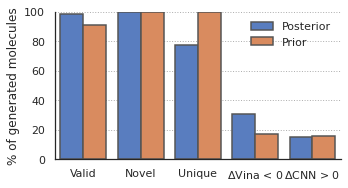

In [61]:
new_lower_vina_aff_col = lower_vina_aff_col.replace(' energy < 0', ' < 0')
new_higher_cnn_aff_col = higher_cnn_aff_col.replace(' affinity > 0', ' > 0')
agg_df[new_lower_vina_aff_col] = agg_df[lower_vina_aff_col]
agg_df[new_higher_cnn_aff_col] = agg_df[higher_cnn_aff_col]

y = [mol_val_col, mol_nov_col, mol_unq_col, new_lower_vina_aff_col, new_higher_cnn_aff_col]
hue = post_prior_col

fig = param_search.plot(
    agg_df[
        (agg_df['group_name'] == '0') &
        (agg_df[model_col] == 'CVAE-1.6') &
        (agg_df[var_factor_col] == 1.0) &
        (agg_df[post_factor_col] == (1.0 - agg_df['prior'])) &
        True
    ].set_index(hue)[y].stack().reset_index(),
    y=0,
    x='level_1',
    hue=hue,
    n_cols=2,
    width=5,
    height=3, #8,
    ylim=ylim,
    plot_func=my_gen_plot,
    legend_kws=dict(loc='upper right', ncol=1, bbox_to_anchor=[1,1], title=None),
    debug=False,

)
ax = fig.axes[0]
ax.grid(axis='y', linestyle=':', color='#b0b0b0')
ax.set_ylabel('% of generated molecules')
_ = ax.set_xlabel(None)
#txt = fig.suptitle(f'Generating molecules', y=1.05)
lgd = ax.get_legend()
plt.setp(lgd.get_title(), fontsize='small')
for ext in ['png', 'pdf']:
    fig.savefig(f'plots/post_prior_bar_plots.{ext}', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)


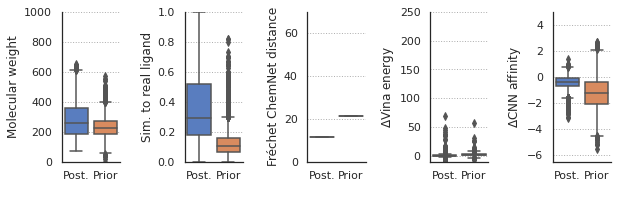

In [62]:
fig = param_search.plot(
    plot_df[
        (plot_df['group_name'] == '0') &
        (plot_df[model_col] == 'CVAE-1.6') &
        (plot_df[var_factor_col] == 1.0) &
        (plot_df[post_factor_col] == (1.0 - plot_df['prior'])) &
        True
    ],
    y=gen_y,
    x=post_prior_col,
    hue=None,
    n_cols=5,
    width=1.75,
    height=3,
    ylim=ylim,
    plot_func=my_gen_plot,
    legend_kws=dict(title=False, bbox_to_anchor=[0,-0.1], loc='upper left'),
    tight=True
)
for ax in fig.axes:
    ax.grid(axis='y', linestyle=':', color='#b0b0b0')
    ax.set_xlabel(None)
    ax.set_xticklabels(['Post.', 'Prior'])
lgd = ax.get_legend()
plt.setp(lgd.get_title(), fontsize='small')
for ext in ['pdf', 'png']:
    fig.savefig(f'plots/post_prior_box_plots.{ext}', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)

,Posterior/prior,level_1,value
0,Posterior,Valid,98.500000
1,Posterior,Novel,100.000000
2,Posterior,Unique,77.732657
3,Posterior,$\Delta$Vina < 0,30.811111
4,Posterior,$\Delta$CNN > 0,15.400000
5,Prior,Valid,90.877778
6,Prior,Novel,100.000000
7,Prior,Unique,99.926641
8,Prior,$\Delta$Vina < 0,17.300000
9,Prior,$\Delta$CNN > 0,15.922222


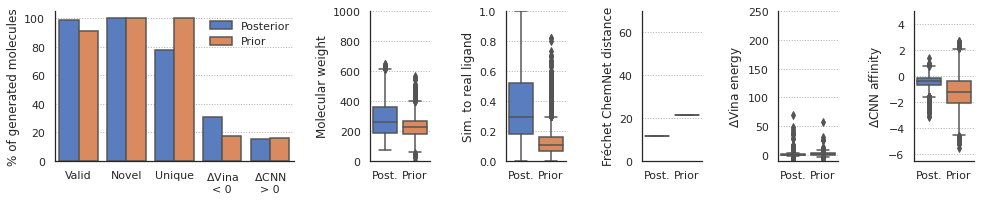

In [116]:
import param_search

new_lower_vina_aff_col = lower_vina_aff_col.replace(' energy < 0', '\n< 0')
new_higher_cnn_aff_col = higher_cnn_aff_col.replace(' affinity > 0', '\n> 0')
agg_df[new_lower_vina_aff_col] = agg_df[lower_vina_aff_col]
agg_df[new_higher_cnn_aff_col] = agg_df[higher_cnn_aff_col]

def my_skip_gen_plot(y, ax, *args, **kwargs):
    if y is None:
        return ax
    else:
        return my_gen_plot(y=y, ax=ax, *args, **kwargs)

fig = param_search.plot(
    plot_df[
        (plot_df['group_name'] == '0') &
        (plot_df[model_col] == 'CVAE-1.6') &
        (plot_df[var_factor_col] == 1.0) &
        (plot_df[post_factor_col] == (1.0 - plot_df['prior'])) &
        True
    ],
    y=[None] + gen_y,
    x=post_prior_col,
    hue=None,
    n_cols=6,
    width=2.25,
    height=3,
    ylim=ylim,
    plot_func=my_skip_gen_plot,
    legend_kws=dict(title=False, bbox_to_anchor=[0,-0.1], loc='upper left'),
    tight=True,
    debug=False,
    gridspec_kw=dict(width_ratios=[4,1,1,1,1,1])
)

# add bar plot
ax = fig.axes[0]
y = [mol_val_col, mol_nov_col, mol_unq_col, new_lower_vina_aff_col, new_higher_cnn_aff_col]

my_gen_plot(
    data=agg_df[
        (agg_df['group_name'] == '0') &
        (agg_df[model_col] == 'CVAE-1.6') &
        (agg_df[var_factor_col] == 1.0) &
        (agg_df[post_factor_col] == (1.0 - agg_df['prior'])) &
        True
    ].set_index(post_prior_col)[y].stack().reset_index(),
    x='level_1',
    y=0,
    hue=post_prior_col,
    ax=ax,
)

lgd = ax.legend(
    loc='upper right', ncol=1,
    bbox_to_anchor=[1.025, 1],
    frameon=False,
    title=None
)

for i, ax in enumerate(fig.axes):
    ax.grid(axis='y', linestyle=':', color='#b0b0b0')
    ax.set_xlabel(None)
    if i > 0:
        ax.set_xticklabels(['Post.', 'Prior'])
    else:
        ax.set_ylabel('% of generated molecules')

lgd = ax.get_legend()
#plt.setp(lgd.get_title(), fontsize='small')
for ext in ['pdf', 'png']:
    fig.savefig(f'plots/post_prior_all_plots.{ext}', bbox_extra_artists=(), bbox_inches='tight', dpi=400)
    
bar_df

In [97]:
bar_df = bar_df.rename({
    '0': 'value'
}, axis=1) #sns.barplot(bar_df, x='level_1', y=0, hue=str(post_prior_col))bar
bar_df

,Posterior/prior,level_1,value
0,Posterior,Valid,98.500000
1,Posterior,Novel,100.000000
2,Posterior,Unique,77.732657
3,Posterior,$\Delta$Vina < 0,30.811111
4,Posterior,$\Delta$CNN > 0,15.400000
5,Prior,Valid,90.877778
6,Prior,Novel,100.000000
7,Prior,Unique,99.926641
8,Prior,$\Delta$Vina < 0,17.300000
9,Prior,$\Delta$CNN > 0,15.922222


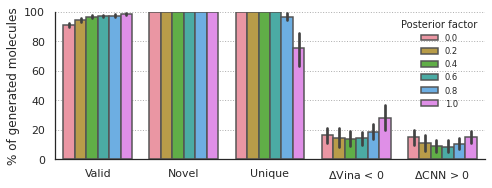

In [183]:
y = [mol_val_col, mol_nov_col, mol_unq_col, new_lower_vina_aff_col, new_higher_cnn_aff_col]
hue = [post_factor_col]

fig = param_search.plot(
    agg_df[
        (agg_df['group_name'] == '0') &
        (agg_df[model_col] == 'CVAE-1.6') &
        (agg_df[var_factor_col] == 1.0) &
        #(agg_df[post_factor_col] == 1.0) &
        True
    ].set_index(hue)[y].stack().reset_index(),
    y=0,
    x='level_1',
    hue=hue,
    n_cols=2,
    width=7,
    height=3, #8,
    ylim=ylim,
    plot_func=my_gen_plot,
    legend_kws=dict(loc='upper right', ncol=1, bbox_to_anchor=[1,1], fontsize='x-small'),

)
ax = fig.axes[0]
ax.grid(axis='y', linestyle=':', color='#b0b0b0')
ax.set_ylabel('% of generated molecules')
_ = ax.set_xlabel(None)
#txt = fig.suptitle(f'Generating molecules', y=1.05)
lgd = ax.get_legend()
plt.setp(lgd.get_title(), fontsize='small')
for ext in ['png', 'pdf']:
    fig.savefig(f'plots/post_factor_bar_plots.{ext}', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)


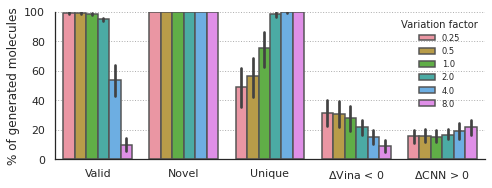

In [131]:
hue = [var_factor_col]

fig = param_search.plot(
    agg_df[
        (agg_df['group_name'] == '0') &
        (agg_df[model_col] == 'CVAE-1.6') &
        #(agg_df[var_factor_col] == 1.0) &
        (agg_df[post_factor_col] == 1.0) &
        True
    ].set_index(hue)[y].stack().reset_index(),
    y=0,
    x='level_1',
    hue=hue,
    n_cols=2,
    width=7,
    height=3, #8,
    ylim=ylim,
    plot_func=my_gen_plot,
    legend_kws=dict(loc='upper right', ncol=1, bbox_to_anchor=[1,1], fontsize='x-small'),

)
ax = fig.axes[0]
ax.grid(axis='y', linestyle=':', color='#b0b0b0')
ax.set_ylabel('% of generated molecules')
_ = ax.set_xlabel(None)
#txt = fig.suptitle(f'Generating molecules', y=1.05)
lgd = ax.get_legend()
plt.setp(lgd.get_title(), fontsize='small')
for ext in ['png', 'pdf']:
    fig.savefig(f'plots/var_factor_post_bar_plots.{ext}', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)


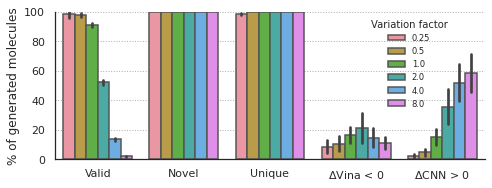

In [133]:
hue = [var_factor_col]

fig = param_search.plot(
    agg_df[
        (agg_df['group_name'] == '0') &
        (agg_df[model_col] == 'CVAE-1.6') &
        #(agg_df[var_factor_col] == 1.0) &
        (agg_df[post_factor_col] == 0.0) &
        True
    ].set_index(hue)[y].stack().reset_index(),
    y=0,
    x='level_1',
    hue=hue,
    n_cols=2,
    width=7,
    height=3, #8,
    ylim=ylim,
    plot_func=my_gen_plot,
    legend_kws=dict(loc='upper right', ncol=1, bbox_to_anchor=[0.93,1], fontsize='x-small'),

)
ax = fig.axes[0]
ax.grid(axis='y', linestyle=':', color='#b0b0b0')
ax.set_ylabel('% of generated molecules')
_ = ax.set_xlabel(None)
#txt = fig.suptitle(f'Generating molecules', y=1.05)
lgd = ax.get_legend()
plt.setp(lgd.get_title(), fontsize='small')
for ext in ['png', 'pdf']:
    fig.savefig(f'plots/var_factor_prior_bar_plots.{ext}', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)


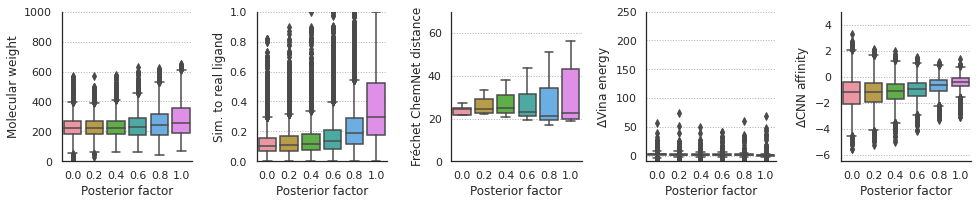

In [154]:
fig = param_search.plot(
    plot_df[
        (plot_df['group_name'] == '0') &
        (plot_df[model_col] == 'CVAE-1.6') &
        (plot_df[var_factor_col] == 1.0) &
        #(agg_df[post_factor_col] == 1.0) &
        True
    ],
    y=gen_y,
    x=post_factor_col,
    hue=None,
    n_cols=5,
    width=2.75,
    height=3,
    ylim=ylim,
    plot_func=my_gen_plot,
    legend_kws=dict(title=False, bbox_to_anchor=[0,-0.1], loc='upper left'),
    tight=True
)
for ax in fig.axes:
    ax.grid(axis='y', linestyle=':', color='#b0b0b0')
lgd = ax.get_legend()
plt.setp(lgd.get_title(), fontsize='small')
for ext in ['pdf', 'png']:
    fig.savefig(f'plots/post_factor_box_plots.{ext}', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)

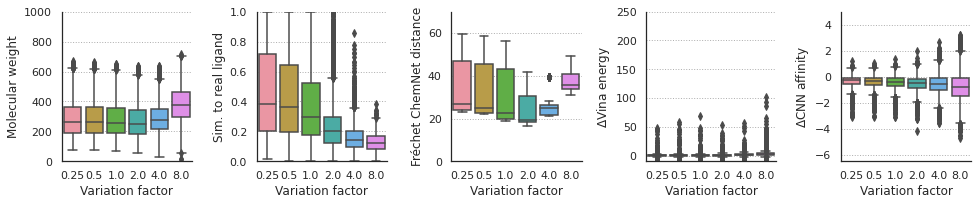

In [155]:
fig = param_search.plot(
    plot_df[
        (plot_df['group_name'] == '0') &
        (plot_df[model_col] == 'CVAE-1.6') &
        #(plot_df[var_factor_col] == 1.0) &
        (plot_df[post_factor_col] == 1.0) &
        True
    ],
    y=gen_y,
    x=var_factor_col,
    hue=None,
    n_cols=5,
    width=2.75,
    height=3,
    ylim=ylim,
    plot_func=my_gen_plot,
    legend_kws=dict(title=False, bbox_to_anchor=[0,-0.1], loc='upper left'),
    tight=True
)
for ax in fig.axes:
    ax.grid(axis='y', linestyle=':', color='#b0b0b0')
lgd = ax.get_legend()
plt.setp(lgd.get_title(), fontsize='small')
for ext in ['pdf', 'png']:
    fig.savefig(f'plots/var_factor_post_box_plots.{ext}', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)

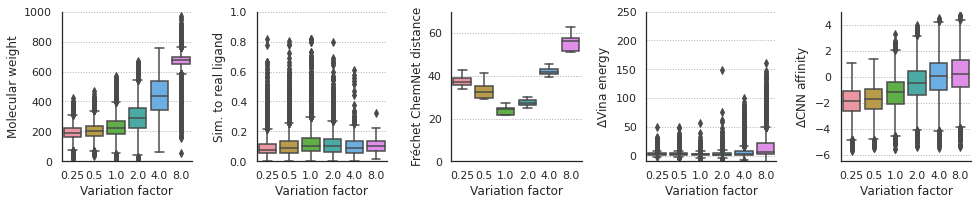

In [156]:
fig = param_search.plot(
    plot_df[
        (plot_df['group_name'] == '0') &
        (plot_df[model_col] == 'CVAE-1.6') &
        #(plot_df[var_factor_col] == 1.0) &
        (plot_df[post_factor_col] == 0.0) &
        True
    ],
    y=gen_y,
    x=var_factor_col,
    hue=None,
    n_cols=5,
    width=2.75,
    height=3,
    ylim=ylim,
    plot_func=my_gen_plot,
    legend_kws=dict(title=False, bbox_to_anchor=[0,-0.1], loc='upper left'),
    tight=True
)
for ax in fig.axes:
    ax.grid(axis='y', linestyle=':', color='#b0b0b0')
lgd = ax.get_legend()
plt.setp(lgd.get_title(), fontsize='small')
for ext in ['pdf', 'png']:
    fig.savefig(f'plots/var_factor_prior_box_plots.{ext}', bbox_extra_artists=(lgd,), bbox_inches='tight', dpi=400)

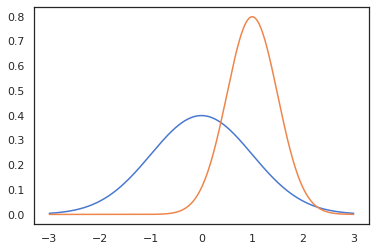

In [305]:
from scipy.stats import norm
x = np.linspace(-3, 3, 1000)
fig, ax = plt.subplots()
for mean, std in [(0, 1), (1,0.5)]:
    y = norm(mean, std).pdf(x)
    ax.plot(x,y)

In [417]:
list(plot_df[
    (plot_df['group_name'] == '2')
]['data_name'].unique())

['fixed_input_1zyu_A_rec_mutants',
 'fixed_input_no_rec_mutants',
 'fixed_cond_1zyu_A_rec_mutants',
 'fixed_cond_no_rec_mutants']

1.0
0.0


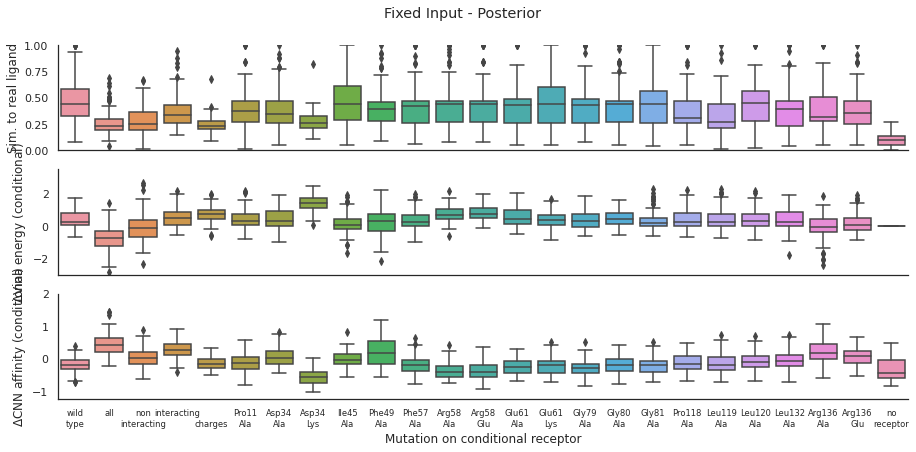

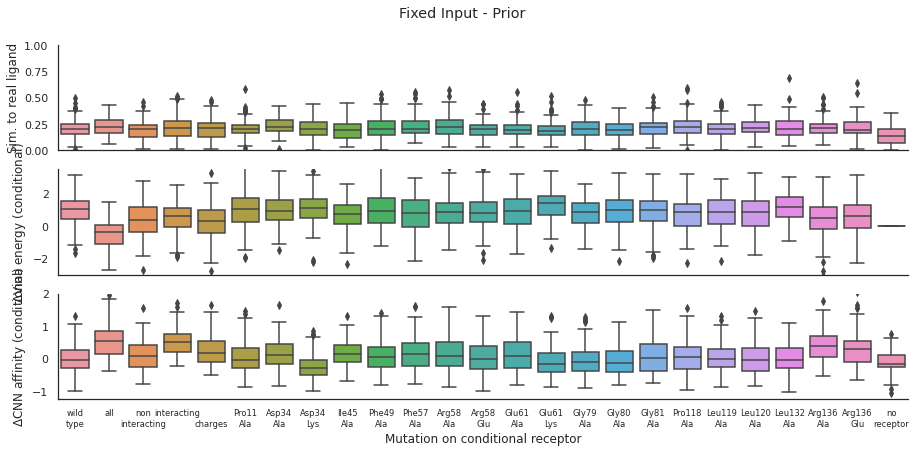

In [468]:
mutant_map = {
    '1zyu_A_rec': 'wild\ntype',
    '1zyu_A_rec_mut_11_PRO_ALA': 'Pro11\nAla',
    '1zyu_A_rec_mut_34_ASP_ALA': 'Asp34\nAla',
    '1zyu_A_rec_mut_34_ASP_LYS': 'Asp34\nLys',
    '1zyu_A_rec_mut_45_ILE_ALA': 'Ile45\nAla',
    '1zyu_A_rec_mut_49_PHE_ALA': 'Phe49\nAla',
    '1zyu_A_rec_mut_57_PHE_ALA': 'Phe57\nAla',
    '1zyu_A_rec_mut_58_ARG_ALA': 'Arg58\nAla',
    '1zyu_A_rec_mut_58_ARG_GLU': 'Arg58\nGlu',
    '1zyu_A_rec_mut_61_GLU_ALA': 'Glu61\nAla',
    '1zyu_A_rec_mut_61_GLU_LYS': 'Glu61\nLys',
    '1zyu_A_rec_mut_79_GLY_ALA': 'Gly79\nAla',
    '1zyu_A_rec_mut_80_GLY_ALA': 'Gly80\nAla',
    '1zyu_A_rec_mut_81_GLY_ALA': 'Gly81\nAla',
    '1zyu_A_rec_mut_118_PRO_ALA': 'Pro118\nAla',
    '1zyu_A_rec_mut_119_LEU_ALA': 'Leu119\nAla',
    '1zyu_A_rec_mut_120_LEU_ALA': 'Leu120\nAla',
    '1zyu_A_rec_mut_132_LEU_ALA': 'Leu132\nAla',
    '1zyu_A_rec_mut_136_ARG_ALA': 'Arg136\nAla',
    '1zyu_A_rec_mut_136_ARG_GLU': 'Arg136\nGlu',
    '1zyu_A_rec_mut_all': 'all',
    '1zyu_A_rec_mut_all_inter': 'interacting',
    '1zyu_A_rec_mut_all_noninter': 'non\ninteracting',
    '1zyu_A_rec_mut_all_charges': '\ncharges',
    'O_100_100_100': 'no\nreceptor',
}
mutant_order = [
    '1zyu_A_rec',
    '1zyu_A_rec_mut_all',
    '1zyu_A_rec_mut_all_noninter',
    '1zyu_A_rec_mut_all_inter',
    '1zyu_A_rec_mut_all_charges',
    '1zyu_A_rec_mut_11_PRO_ALA',
    '1zyu_A_rec_mut_34_ASP_ALA',
    '1zyu_A_rec_mut_34_ASP_LYS',
    '1zyu_A_rec_mut_45_ILE_ALA',
    '1zyu_A_rec_mut_49_PHE_ALA',
    '1zyu_A_rec_mut_57_PHE_ALA',
    '1zyu_A_rec_mut_58_ARG_ALA',
    '1zyu_A_rec_mut_58_ARG_GLU',
    '1zyu_A_rec_mut_61_GLU_ALA',
    '1zyu_A_rec_mut_61_GLU_LYS',
    '1zyu_A_rec_mut_79_GLY_ALA',
    '1zyu_A_rec_mut_80_GLY_ALA',
    '1zyu_A_rec_mut_81_GLY_ALA',
    '1zyu_A_rec_mut_118_PRO_ALA',
    '1zyu_A_rec_mut_119_LEU_ALA',
    '1zyu_A_rec_mut_120_LEU_ALA',
    '1zyu_A_rec_mut_132_LEU_ALA',
    '1zyu_A_rec_mut_136_ARG_ALA',
    '1zyu_A_rec_mut_136_ARG_GLU',
    'O_100_100_100'
]
mutant_col = 'Mutation on conditional receptor'
plot_df[mutant_col] = plot_df['cond_rec_name'].map(lambda x: mutant_map.get(x, x))
plot_df['mutant_idx'] = plot_df['cond_rec_name'].map(lambda x: mutant_order.index(x) if x in mutant_order else 1000)

cond_vina_aff_col = '$\Delta$Vina energy (conditional)'
cond_cnn_aff_col = '$\Delta$CNN affinity (conditional)'

plot_df[cond_vina_aff_col] = plot_df['lig_gen_fit_add_cond_vina_aff_diff']
plot_df[cond_cnn_aff_col] = plot_df['lig_gen_fit_add_cond_cnn_aff_diff']
plot_df['cnn aff diff diff'] = plot_df[cond_cnn_aff_col] - plot_df[cnn_aff_col]

ylim = {
    mol_wt_col: [50,400],
    mol_sim_col: [0,1],
    vina_aff_col: [-3,3.5],
    cnn_aff_col: [-1.25, 2],
    cond_vina_aff_col: [-3,3.5],
    cond_cnn_aff_col: [-1.25, 2],
}

cond_gen_y = [
    mol_wt_col,
    mol_sim_col,
    vina_aff_col,
    cond_vina_aff_col,
    cnn_aff_col,
    cond_cnn_aff_col,
]

for post_factor in [1.0, 0.0]:
    print(post_factor)

    fig = param_search.plot(
        plot_df[
            (plot_df['group_name'] == '2') &
            (plot_df['data_name'] == 'fixed_input_1zyu_A_rec_mutants') &
            (plot_df['diff_cond_transform'] == 0) &
            (plot_df[model_col] == 'CVAE1') &
            (plot_df[post_factor_col] == post_factor) &
            True
        ].sort_values('mutant_idx'),
        y=[mol_sim_col, cond_vina_aff_col, cond_cnn_aff_col], #'lig_gen_rec_prod', 'lig_gen_cond_rec_prod', 'cnn aff diff diff'],
        x=mutant_col,
        hue=None, #'diff_cond_transform',
        n_cols=1,
        width=13,
        height=2,
        ylim=ylim,
        plot_func=sns.boxplot,
        legend_kws=dict(title=False, bbox_to_anchor=[0,-0.1], loc='upper left'),
        tight=True
    )
    txt = fig.suptitle(['Fixed Input - Prior','Fixed Input - Posterior'][int(post_factor)], y=1.05)
    #for ax in fig.axes:
    #    ax.set_xlabel(None)
    for ax in fig.axes:
        ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-small')

    for ext in ['pdf', 'png']:
        fig.savefig(
            f'plots/fixed_input_{post_factor}_box_plots.{ext}',
            bbox_extra_artists=(txt,),
            bbox_inches='tight',
            dpi=400,
        )

In [437]:
test_df = plot_df[plot_df['group_name'] == '2']
test_df.shape

(240000, 187)

In [438]:
cnn_aff_col, cond_cnn_aff_col

('$\\Delta$CNN affinity', '$\\Delta$CNN affinity (conditional)')

In [439]:
(test_df[cond_cnn_aff_col] - test_df[cnn_aff_col]).describe()

count    203319.000000
mean          0.038266
std           0.453878
min          -1.931581
25%          -0.212275
50%           0.008129
75%           0.322318
max           2.109717
dtype: float64

In [430]:
(test_df['lig_gen_cond_rec_prod'] - test_df['lig_gen_rec_prod']).describe()

count    240000.000000
mean        -17.758082
std          42.727041
min        -577.855713
25%          -5.297171
50%          -0.000192
75%           0.000000
max          47.416771
dtype: float64

In [191]:
(test_df['lig_gen_fit_add_cond_cnn_aff_diff'] - test_df['lig_gen_fit_add_cnn_aff_diff']).describe()

count    93839.000000
mean        -0.001602
std          0.332790
min         -2.214074
25%         -0.204647
50%          0.000000
75%          0.191547
max          1.860880
dtype: float64

In [487]:
test_df = pd.read_csv('gen2_CVAE_fixed_input_1zyu_A_rec_mutants_0_1.0/TEST.gen_metrics', sep=' ')
test_df.set_index(['example_idx', 'sample_idx'])[[
    'input_rec_name',
    'input_lig_name',
    'cond_rec_name',
    'cond_lig_name',
    'lig_gen_grid_norm',
    'lig_gen_rec_prod',
    'lig_gen_cond_rec_prod',
    'lig_gen_fit_add_cnn_aff',
    'lig_gen_fit_add_cond_cnn_aff'
]].transpose()

example_idx,0,1
sample_idx,0,0
input_rec_name,1zyu_A_rec,1zyu_A_rec
input_lig_name,1we2_dhk_lig_tt_docked_8,1we2_dhk_lig_tt_docked_8
cond_rec_name,1zyu_A_rec,1zyu_A_rec_mut_all
cond_lig_name,1we2_dhk_lig_tt_docked_8,1we2_dhk_lig_tt_docked_8
lig_gen_grid_norm,15.9373,16.8211
lig_gen_rec_prod,0.000105255,61.207
lig_gen_cond_rec_prod,0.000105255,0
lig_gen_fit_add_cnn_aff,3.15176,2.9995
lig_gen_fit_add_cond_cnn_aff,3.15176,3.18723


In [481]:
[c for c in test_df.columns if 'cond' in c]

['cond_rec_name',
 'cond_lig_name',
 'cond_lig_grid_norm',
 'cond_lig_grid_elem_norm',
 'cond_lig_grid_prop_norm',
 'cond_lig_rec_prod',
 'cond_lig_rec_elem_prod',
 'cond_lig_rec_prop_prod',
 'cond_lig_n_atoms',
 'cond_lig_radius',
 'lig_gen_cond_L2_loss',
 'lig_gen_cond_elem_L2_loss',
 'lig_gen_cond_prop_L2_loss',
 'lig_gen_cond_rec_prod',
 'lig_gen_cond_rec_elem_prod',
 'lig_gen_cond_rec_prop_prod',
 'lig_gen_fit_cond_n_atoms_diff',
 'lig_gen_fit_cond_type_diff',
 'lig_gen_fit_cond_elem_diff',
 'lig_gen_fit_cond_prop_diff',
 'lig_gen_fit_cond_RMSD',
 'lig_gen_fit_add_cond_n_atoms_diff',
 'lig_gen_fit_add_cond_SMILES_match',
 'lig_gen_fit_add_cond_ob_sim',
 'lig_gen_fit_add_cond_rdkit_sim',
 'lig_gen_fit_add_cond_morgan_sim',
 'lig_gen_fit_add_cond_maccs_sim',
 'lig_gen_fit_add_cond_UFF_init',
 'lig_gen_fit_add_cond_UFF_min',
 'lig_gen_fit_add_cond_UFF_rmsd',
 'lig_gen_fit_add_cond_UFF_error',
 'lig_gen_fit_add_cond_UFF_time',
 'lig_gen_fit_add_cond_UFF_init_diff',
 'lig_gen_fit_add_c

<AxesSubplot:>

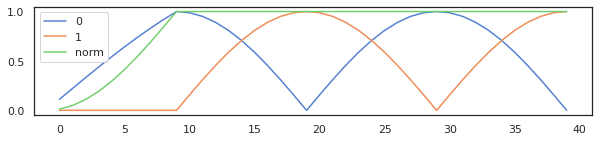

In [287]:
slerp = pd.DataFrame([
    [1.1096e-01, 9.1846e-07],
    [2.2123e-01, 8.3125e-07],
    [3.3014e-01, 7.3892e-07],
    [4.3702e-01, 6.4204e-07],
    [5.4120e-01, 5.4120e-07],
    [6.4204e-01, 4.3702e-07],
    [7.3892e-01, 3.3014e-07],
    [8.3125e-01, 2.2123e-07],
    [9.1846e-01, 1.1096e-07],
    [1.0000e+00, 0.0000e+00],
    [0.9877, 0.1564],
    [0.9511, 0.3090],
    [0.8910, 0.4540],
    [0.8090, 0.5878],
    [0.7071, 0.7071],
    [0.5878, 0.8090],
    [0.4540, 0.8910],
    [0.3090, 0.9511],
    [0.1564, 0.9877],
    [0.0000, 1.0000],
    [0.1564, 0.9877],
    [0.3090, 0.9511],
    [0.4540, 0.8910],
    [0.5878, 0.8090],
    [0.7071, 0.7071],
    [0.8090, 0.5878],
    [0.8910, 0.4540],
    [0.9511, 0.3090],
    [0.9877, 0.1564],
    [1.0000, 0.0000],
    [0.9877, 0.1564],
    [0.9511, 0.3090],
    [0.8910, 0.4540],
    [0.8090, 0.5878],
    [0.7071, 0.7071],
    [0.5878, 0.8090],
    [0.4540, 0.8910],
    [0.3090, 0.9511],
    [0.1564, 0.9877],
    [0.0000, 1.0000],
])

slerp['norm'] = (slerp**2).sum(axis=1)

slerp.plot(figsize=(10,2))

In [444]:
interp_col = 'Interpolation step'
plot_df[interp_col] = plot_df.apply(lambda x: x['example_idx']*100 + x['sample_idx'], axis=1)
plot_df[plot_df['group_name'] == '3']

,lig_name,sample_idx,lig_grid_norm,lig_grid_elem_norm,lig_grid_prop_norm,lig_rec_prod,lig_rec_elem_prod,lig_rec_prop_prod,lig_n_atoms,lig_radius,lig_n_frags,lig_valid,lig_reason,lig_MW,lig_logP,lig_QED,lig_SAS,lig_NPS,lig_SMILES,lig_UFF_init,lig_UFF_min,lig_UFF_rmsd,lig_UFF_error,lig_UFF_time,lig_vina_aff,lig_vina_rmsd,lig_cnn_pose,lig_cnn_aff,lig_gen_grid_norm,lig_gen_grid_elem_norm,lig_gen_grid_prop_norm,lig_gen_L2_loss,lig_gen_elem_L2_loss,lig_gen_prop_L2_loss,lig_gen_rec_prod,lig_gen_rec_elem_prod,lig_gen_rec_prop_prod,lig_latent_norm,lig_latent_variance,lig_gen_fit_grid_norm,lig_gen_fit_grid_elem_norm,lig_gen_fit_grid_prop_norm,lig_gen_fit_L2_loss,lig_gen_fit_elem_L2_loss,lig_gen_fit_prop_L2_loss,lig_gen_fit_rec_prod,lig_gen_fit_rec_elem_prod,lig_gen_fit_rec_prop_prod,lig_gen_fit_n_atoms,lig_gen_fit_radius,...,lig_gen_cond_prop_L2_loss,lig_gen_cond_rec_prod,lig_gen_cond_rec_elem_prod,lig_gen_cond_rec_prop_prod,lig_gen_fit_cond_n_atoms_diff,lig_gen_fit_cond_type_diff,lig_gen_fit_cond_elem_diff,lig_gen_fit_cond_prop_diff,lig_gen_fit_cond_RMSD,lig_gen_fit_add_cond_n_atoms_diff,lig_gen_fit_add_cond_SMILES_match,lig_gen_fit_add_cond_ob_sim,lig_gen_fit_add_cond_rdkit_sim,lig_gen_fit_add_cond_morgan_sim,lig_gen_fit_add_cond_maccs_sim,lig_gen_fit_add_cond_UFF_init,lig_gen_fit_add_cond_UFF_min,lig_gen_fit_add_cond_UFF_rmsd,lig_gen_fit_add_cond_UFF_error,lig_gen_fit_add_cond_UFF_time,lig_gen_fit_add_cond_UFF_init_diff,lig_gen_fit_add_cond_UFF_min_diff,lig_gen_fit_add_cond_UFF_rmsd_diff,lig_gen_fit_add_cond_vina_aff,lig_gen_fit_add_cond_vina_rmsd,lig_gen_fit_add_cond_cnn_pose,lig_gen_fit_add_cond_cnn_aff,lig_gen_fit_add_cond_gnina_error,lig_gen_fit_add_cond_vina_aff_diff,lig_gen_fit_add_cond_vina_rmsd_diff,lig_gen_fit_add_cond_cnn_pose_diff,lig_gen_fit_add_cond_cnn_aff_diff,Valid,Molecular weight,Sim. to real ligand,$\Delta$Vina energy,$\Delta$CNN affinity,$\Delta$CNN affinity > 0,$\Delta$Vina energy < 0,Model,PDB ID,Variation factor,Posterior factor,Posterior/prior,Mutation on conditional receptor,mutant_idx,$\Delta$Vina energy (conditional),$\Delta$CNN affinity (conditional),cnn aff diff diff,Interpolation step
0,NaN,0,17.080868,8.681408,14.710172,0.000000,0.000000,0.000000,22.0,3.424302,1.0,True,Valid molecule,174.152,-1.5162,0.386923,7.026208,0.074434,[H]OC(=O)C1=C([H])C([H])(O[H...,559.166917,508.646687,0.649277,NaN,1.118764,-6.39616,0.01326,0.301621,3.469995,16.028955,7.342150,14.248519,154.988998,44.024254,110.964737,0.000121,0.0,0.000383,10.877439,NaN,15.775915,8.206852,13.473198,36.671455,10.439250,26.232204,0.0,0.0,0.0,12.0,4.832745,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,218.082,0.054348,2.34366,-0.421185,0,0,CVAE1,1zyu,1.0,1.0,Posterior,wild\ntype,0,NaN,NaN,NaN,0.0
1,NaN,1,17.080868,8.681408,14.710172,0.000000,0.000000,0.000000,22.0,3.424302,1.0,True,Valid molecule,174.152,-1.5162,0.386923,7.026208,0.074434,[H]OC(=O)C1=C([H])C([H])(O[H...,559.166917,508.646687,0.649277,NaN,1.118764,-6.39616,0.01326,0.301621,3.469995,15.956838,7.293869,14.192256,152.931458,43.615269,109.316200,0.000164,0.0,0.000405,10.873824,NaN,18.367233,9.678141,15.610538,33.595085,12.196959,21.398125,0.0,0.0,0.0,16.0,4.647364,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100,294.073,0.049587,1.28541,0.051759,100,0,CVAE1,1zyu,1.0,1.0,Posterior,wild\ntype,0,NaN,NaN,NaN,1.0
2,NaN,2,17.080868,8.681408,14.710172,0.000000,0.000000,0.000000,22.0,3.424302,1.0,True,Valid molecule,174.152,-1.5162,0.386923,7.026208,0.074434,[H]OC(=O)C1=C([H])C([H])(O[H...,559.166917,508.646687,0.649277,NaN,1.118764,-6.39616,0.01326,0.301621,3.469995,15.882132,7.243449,14.134163,150.848236,43.181679,107.666557,0.000242,0.0,0.000450,10.869533,NaN,18.261745,9.594747,15.538090,33.341568,12.253600,21.087971,0.0,0.0,0.0,16.0,4.844416,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

1.0


/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


0.0


/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator


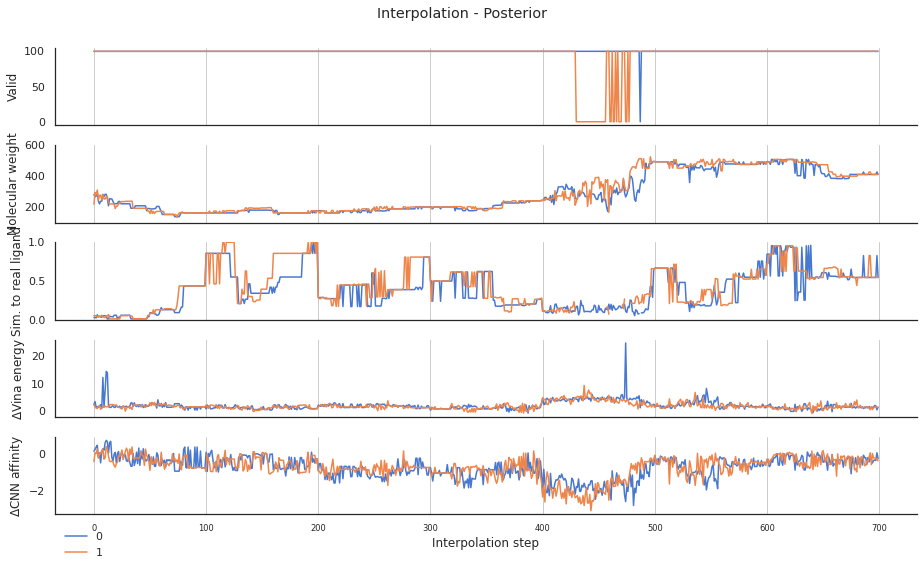

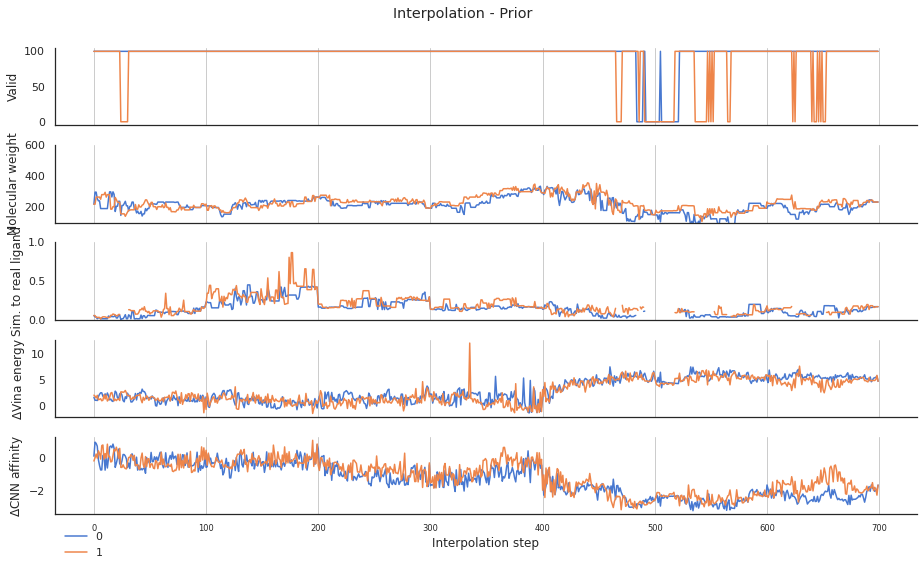

In [466]:
ylim = {
    mol_wt_col: [100,600],
    mol_sim_col: [0,1],
}

interp_gen_y = [
    mol_val_col,
    mol_wt_col,
    mol_sim_col,
    vina_aff_col,
    cnn_aff_col,
]

for post_factor in [1.0, 0.0]:
    print(post_factor)

    fig = param_search.plot(
        plot_df[
            (plot_df['group_name'] == '3') &
            (plot_df['diff_cond_transform'] == 0) &
            (plot_df[model_col] == 'CVAE1') &
            (plot_df[post_factor_col] == post_factor) &
            True
        ],
        y=interp_gen_y,
        x=interp_col,
        hue='spherical',
        n_cols=1,
        width=13,
        height=1.5,
        ylim=ylim,
        plot_func=sns.lineplot,
        legend_kws=dict(title=False, bbox_to_anchor=[0,-0.1], loc='upper left'),
        tight=True
    )
    txt = fig.suptitle(['Interpolation - Prior','Interpolation - Posterior'][int(post_factor)], y=1.05)
    #for ax in fig.axes:
    #    ax.set_xlabel(None)
    for ax in fig.axes:
        ax.set_xticklabels(ax.get_xticklabels(), fontsize='x-small') 
        ax.grid(axis='x')

    for ext in ['pdf', 'png']:
        fig.savefig(
            f'plots/interp_{post_factor}_box_plots.{ext}',
            bbox_extra_artists=(txt,),
            bbox_inches='tight',
            dpi=400,
        )